In [56]:
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque, namedtuple
from itertools import count
import random
import math

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Notebook의 경우, matplotlib 출력 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# env = gym.make("CartPole-v1")

In [57]:
from pathlib import Path
import pandas as pd
from itertools import count
from tqdm import tqdm
from collections import namedtuple
import random

HoldInfo = namedtuple('HoldInfo', ('hold', 'price'))

class ActionSpace():
    def __init__(self, n):
        self.n = n

    def sample(self):
        return random.sample(range(self.n), 1)[0]

def rsi(ohlc: pd.DataFrame, period: int = 14):
    delta = ohlc["현재가"].diff()
    ups, downs = delta.copy(), delta.copy()
    ups[ups < 0] = 0
    downs[downs > 0] = 0

    AU = ups.ewm(com = period-1, min_periods = period).mean()
    AD = downs.abs().ewm(com = period-1, min_periods = period).mean()
    RS = AU/AD

    return pd.Series(100 - (100/(1 + RS)), name = "RSI")

class StockEnvironment():
    # 키움증권 수수료 0.015%
    def __init__(self, date: str, window_sz=50, trading_charge_percent=0.5):
        self.action_space = ActionSpace(3)

        self.date = date
        self.data_path = Path('.') / 'data'
        self.codes_path = list(self.data_path.iterdir())

        self.data = self.codes_path[0]
        self.data_index = 0

        dtype = {'체결시간': 'str'}
        df = pd.read_csv(self.data / (self.date + '.csv'), index_col=0, dtype=dtype).iloc[::-1]
        df = df[df['체결시간'].str[:8] == self.date]
        df['env3'] = df['120이평'] * 0.97
        df['env5'] = df['120이평'] * 0.95
        df['RSI'] = rsi(df)
        df = df.dropna().reset_index(drop=True)
        self.df = df

        self.window_sz = window_sz
        self.step_index = 0
        self.hold = HoldInfo(False, 0)
        self.trading_charge_percent = trading_charge_percent

    def next_data(self, **kwargs):
        '''
        data_code = (str): (example) '001360'
        data_index = (int): data_code가 없으면 data_index가 제공돼야 함.
        next = (Bool): True(바로 다음 data code로 넘어감) default=False 위 옵션은 무시됨.

        위 3개 중 아무것도 kwarg가 없을 시 처음 요소로 데이터 초기화
        Return: self.data_index (데이터 인덱스)
        '''
        if 'next' in kwargs and kwargs['next']:
            self.data = self.codes_path[(self.data_index + 1) % len(self.codes_path)]
        elif ('data_code' in kwargs):
            self.data = self.data_path / kwargs['data_code']
        elif ('data_index' in kwargs):
            self.data = self.codes_path[kwargs['data_index']]
        else:
            self.data = self.codes_path[0]
        
        self.data_index = self.codes_path.index(self.data)

        dtype = {'체결시간': 'str'}
        df = pd.read_csv(self.data / (self.date + '.csv'), index_col=0, dtype=dtype).iloc[::-1]
        df = df[df['체결시간'].str[:8] == self.date]
        df['env3'] = df['120이평'] * 0.97
        df['env5'] = df['120이평'] * 0.95
        df['RSI'] = rsi(df)
        df = df.dropna().reset_index(drop=True)
        self.df = df

        self.step_index = 0
        self.hold = HoldInfo(False, 0)

        return self.data_index

    def reset(self):
        '''
        Return: observation, reward(None), terminated(None), truncated(None), info(None)
        '''
        self.hold = HoldInfo(False, 0)
        self.step_index = 0

        next_df = self.df.iloc[self.step_index:self.step_index+self.window_sz].copy()
        items = ['20이평', '60이평', '120이평', 'env3', 'env5']
        이격도 = list(map(lambda item: item + '이격도', items))
        for item in items:
            next_df[item + '이격도'] = (next_df[item] / next_df['현재가'] - 1) * 100
        next_df['RSI'] = next_df['RSI'] / 100

        return ((next_df[[*이격도, 'RSI']].values.reshape(-1, len(items) + 1), self.hold.hold), {'price': next_df.iloc[0]['현재가']})

    def step(self, action):
        '''
        action: (int) 0(Do nothing), 1(Buy or Hold), 2(Sell or Hold)

        Return: observation, reward, terminated, truncated, info
        '''

        # # dataframe 내에 null 데이터가 포함될 경우
        # if (df_part.isnull().any().any()):
        #     next = self.next_data(next=True)
        #     if (next == 0): return (self.df.iloc[self.step_index:self.step_index+self.window_sz], None, True, None, None)

        reward = 0
        info = {}
        # data 반복이 끝날 경우
        while (self.step_index+self.window_sz >= len(self.df)):
            next = self.next_data(next=True)
            info['next'] = True
            info['price'] = self.df.iloc[0]['현재가']
            
            if (next == 0): return (None, reward, True, True, info)
        
        current_price = self.df.iloc[self.step_index+self.window_sz-1]['현재가']
        info['price'] = current_price
        if action == 0:
            if self.hold.hold:
                reward = (current_price / self.hold.price - 1) * 1
            else:
                pass
        elif action == 1:
            if self.hold.hold:
                reward = (current_price / self.hold.price - 1) * 1
            else:
                self.hold = HoldInfo(True, current_price)

                info['bought'] = True
        elif action == 2:
            if self.hold.hold:
                if current_price > self.hold.price:
                    reward = (current_price / self.hold.price - 1) * ((1 - self.trading_charge_percent / 100) ** 2) * 100
                else:
                    reward = (current_price / self.hold.price - 1) * ((1 + self.trading_charge_percent / 100) ** 2) * 100
                self.hold = HoldInfo(False, 0)

                info['sold'] = True
            else:
                pass

        self.step_index += 1

        next_df = self.df.iloc[self.step_index:self.step_index+self.window_sz].copy()
        items = ['20이평', '60이평', '120이평', 'env3', 'env5']
        이격도 = list(map(lambda item: item + '이격도', items))
        for item in items:
            next_df[item + '이격도'] = (next_df[item] / next_df['현재가'] - 1) * 100
        next_df['RSI'] = next_df['RSI'] / 100

        return ((next_df[[*이격도, 'RSI']].values.reshape(-1, len(items) + 1), self.hold.hold), reward, False, False, info)

env = StockEnvironment(date='20240223', window_sz=30)

In [58]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [59]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 2048)
        self.layer2 = nn.Linear(2048, 2048)
        self.layer3 = nn.Linear(2048, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [60]:
class DQN_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, discrete_size, n_actions):
        super(DQN_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, batch_first=True)
        self.linear = nn.Linear(discrete_size, 64)
        self.output_layer = nn.Linear(64 + hidden_size, n_actions)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x[0])
        if len(lstm_out.shape) == 3:
            lstm_out = lstm_out[:, -1, :]
        elif len(lstm_out.shape) == 2:
            lstm_out = lstm_out[-1, :]
        
        discrete_out = self.linear(x[1])
        return self.output_layer(torch.cat((lstm_out, discrete_out), dim=1))

In [61]:
# net = DQN_LSTM(6, 256, 3, 1, 3).to(device)

# net(torch.tensor(state[0], device=device, dtype=torch.float32), torch.tensor(False, dtype=torch.float32, device=device).unsqueeze(0))
# # net(state)

In [62]:
# BATCH_SIZE: 리플레이 버퍼에서 뽑히는 샘플 개수
# GAMMA: 할인 계수
# EPS_DECAY: 높을수록 EPS_END 도달하는 데 오래 걸림
# TAU: 목표 네트워크의 업데이트 속도
# LR: Learning Rate(AdamW)

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

# policy_net = DQN(n_observations, n_actions).to(device)
# target_net = DQN(n_observations, n_actions).to(device)

policy_net = DQN_LSTM(6, 256, 3, 1, 3).to(device)
target_net = DQN_LSTM(6, 256, 3, 1, 3).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, use_threshold=True):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if use_threshold:
        if sample > eps_threshold:
            with torch.no_grad():
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)


episode_durations = []
episode_rewards = []

def plot_durations():
    plt.figure(1, clear=True)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t)

    if len(durations_t) >= 100:
        means = durations_t.unfold(dimension=0, size=100, step=1).mean(dim=1)
        means = torch.cat([torch.zeros(99), means])
        plt.plot(means)

    
    if is_ipython:
        display.update_display(obj=plt.gcf(), display_id='durations_plot')

def plot_rewards():
    plt.figure(2, clear=True)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Reward(Sum)')
    plt.plot(rewards_t)

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(dimension=0, size=100, step=1).mean(dim=1)
        means = torch.cat([torch.zeros(99), means])
        plt.plot(means)

    
    if is_ipython:
        display.update_display(obj=plt.gcf(), display_id='rewards_plot')
        

In [63]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # non_final_next_states = torch.cat([s for s in batch.next_state
    #                                             if s is not None])
    non_final_next_states = [s for s in batch.next_state if s is not None]
    non_final_next_states_seqs = torch.cat([s[0] for s in non_final_next_states])
    non_final_next_states_dess = torch.cat([s[1] for s in non_final_next_states])

    state_batch = batch.state
    state_batch_seqs = torch.cat([s[0] for s in state_batch])
    state_batch_dess = torch.cat([s[1] for s in state_batch])

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net((state_batch_seqs, state_batch_dess)).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net((non_final_next_states_seqs, non_final_next_states_dess)).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

모델 학습

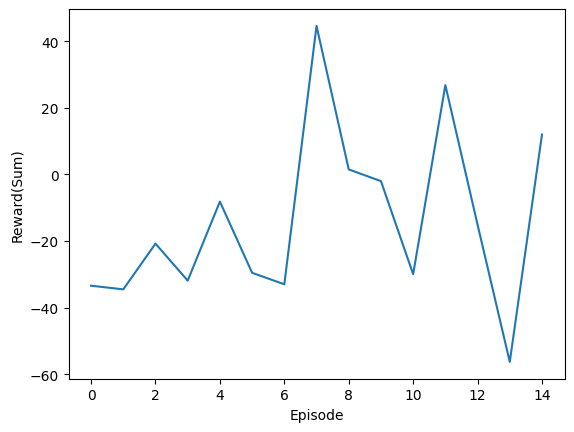

episode:   0%|          | 0/600 [00:00<?, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

count: 0it [00:00, ?it/s]

KeyboardInterrupt: 

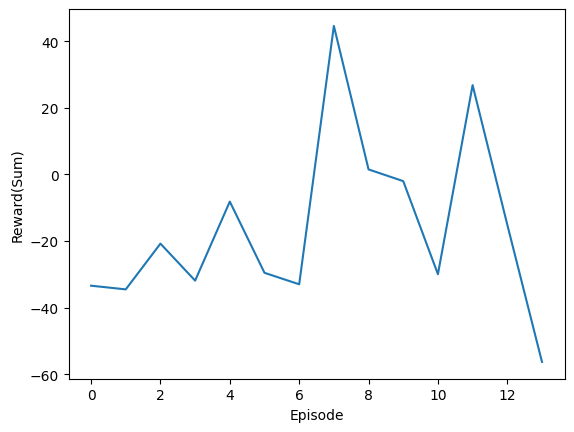

In [64]:
from tqdm.notebook import tqdm
display.display(None, display_id='rewards_plot')

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in tqdm(range(num_episodes), desc='episode', position=0):
    # 환경과 상태 초기화
    state, info = env.reset()
    # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = (torch.tensor(state[0], device=device, dtype=torch.float32).unsqueeze(0), torch.tensor(state[1], dtype=torch.float32, device=device).view(1, 1))

    # 통계
    rewards_sum = 0
    bought_idx = []
    sold_idx = []
    next_idx = []

    for t in tqdm(count(), desc='count', position=1, leave=False):
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # 통계
        rewards_sum += reward.item()
        if 'next' in info:
            next_idx.append(t)
        elif 'bought' in info:
            bought_idx.append(t)
        elif 'sold' in info:
            sold_idx.append(t)

        if terminated:
            next_state = None
        else:
            next_state = (torch.tensor(observation[0], device=device, dtype=torch.float32).unsqueeze(0), torch.tensor(observation[1], dtype=torch.float32, device=device).view(1, 1))
            # next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(rewards_sum)
            plot_rewards()
            break

print('Complete')

모델 평가하기

Complete


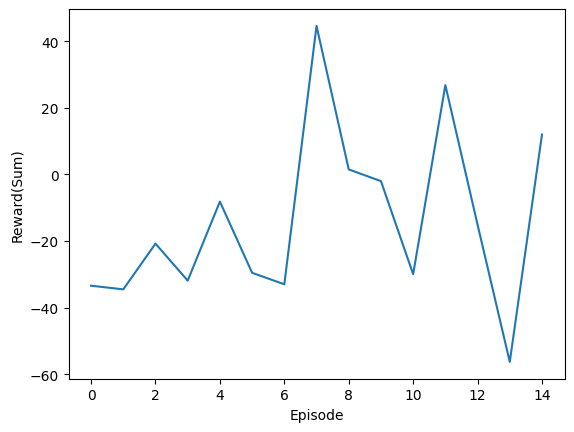

In [68]:
# 환경과 상태 초기화
state, info = env.reset()
state = (torch.tensor(state[0], device=device, dtype=torch.float32).unsqueeze(0), torch.tensor(state[1], dtype=torch.float32, device=device).view(1, 1))

# 통계
rewards_sum = 0
bought_idx = []
sold_idx = []
next_idx = []
price_lst = []

for t in count():
    action = select_action(state, use_threshold=False)
    observation, reward, terminated, truncated, info = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    # 통계
    rewards_sum += reward.item()
    price_lst.append(info['price'])
    if 'next' in info:
        next_idx.append(t)
    elif 'bought' in info:
        bought_idx.append(t)
    elif 'sold' in info:
        sold_idx.append(t)

    if terminated:
        next_state = None
    else:
        next_state = (torch.tensor(observation[0], device=device, dtype=torch.float32).unsqueeze(0), torch.tensor(observation[1], dtype=torch.float32, device=device).view(1, 1))

    # 메모리에 변이 저장
    # memory.push(state, action, next_state, reward)

    # 다음 상태로 이동
    state = next_state

    # (정책 네트워크에서) 최적화 한단계 수행
    # optimize_model()

    # 목표 네트워크의 가중치를 소프트 업데이트
    # θ′ ← τ θ + (1 −τ )θ′
    # target_net_state_dict = target_net.state_dict()
    # policy_net_state_dict = policy_net.state_dict()
    # for key in policy_net_state_dict:
    #     target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    # target_net.load_state_dict(target_net_state_dict)

    if done:
        episode_durations.append(t + 1)
        episode_rewards.append(rewards_sum)
        plot_rewards()
        break

print('Complete')

C:\Users\dhjja\AppData\Local\Temp\ipykernel_14968\2420688678.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(50, 20))


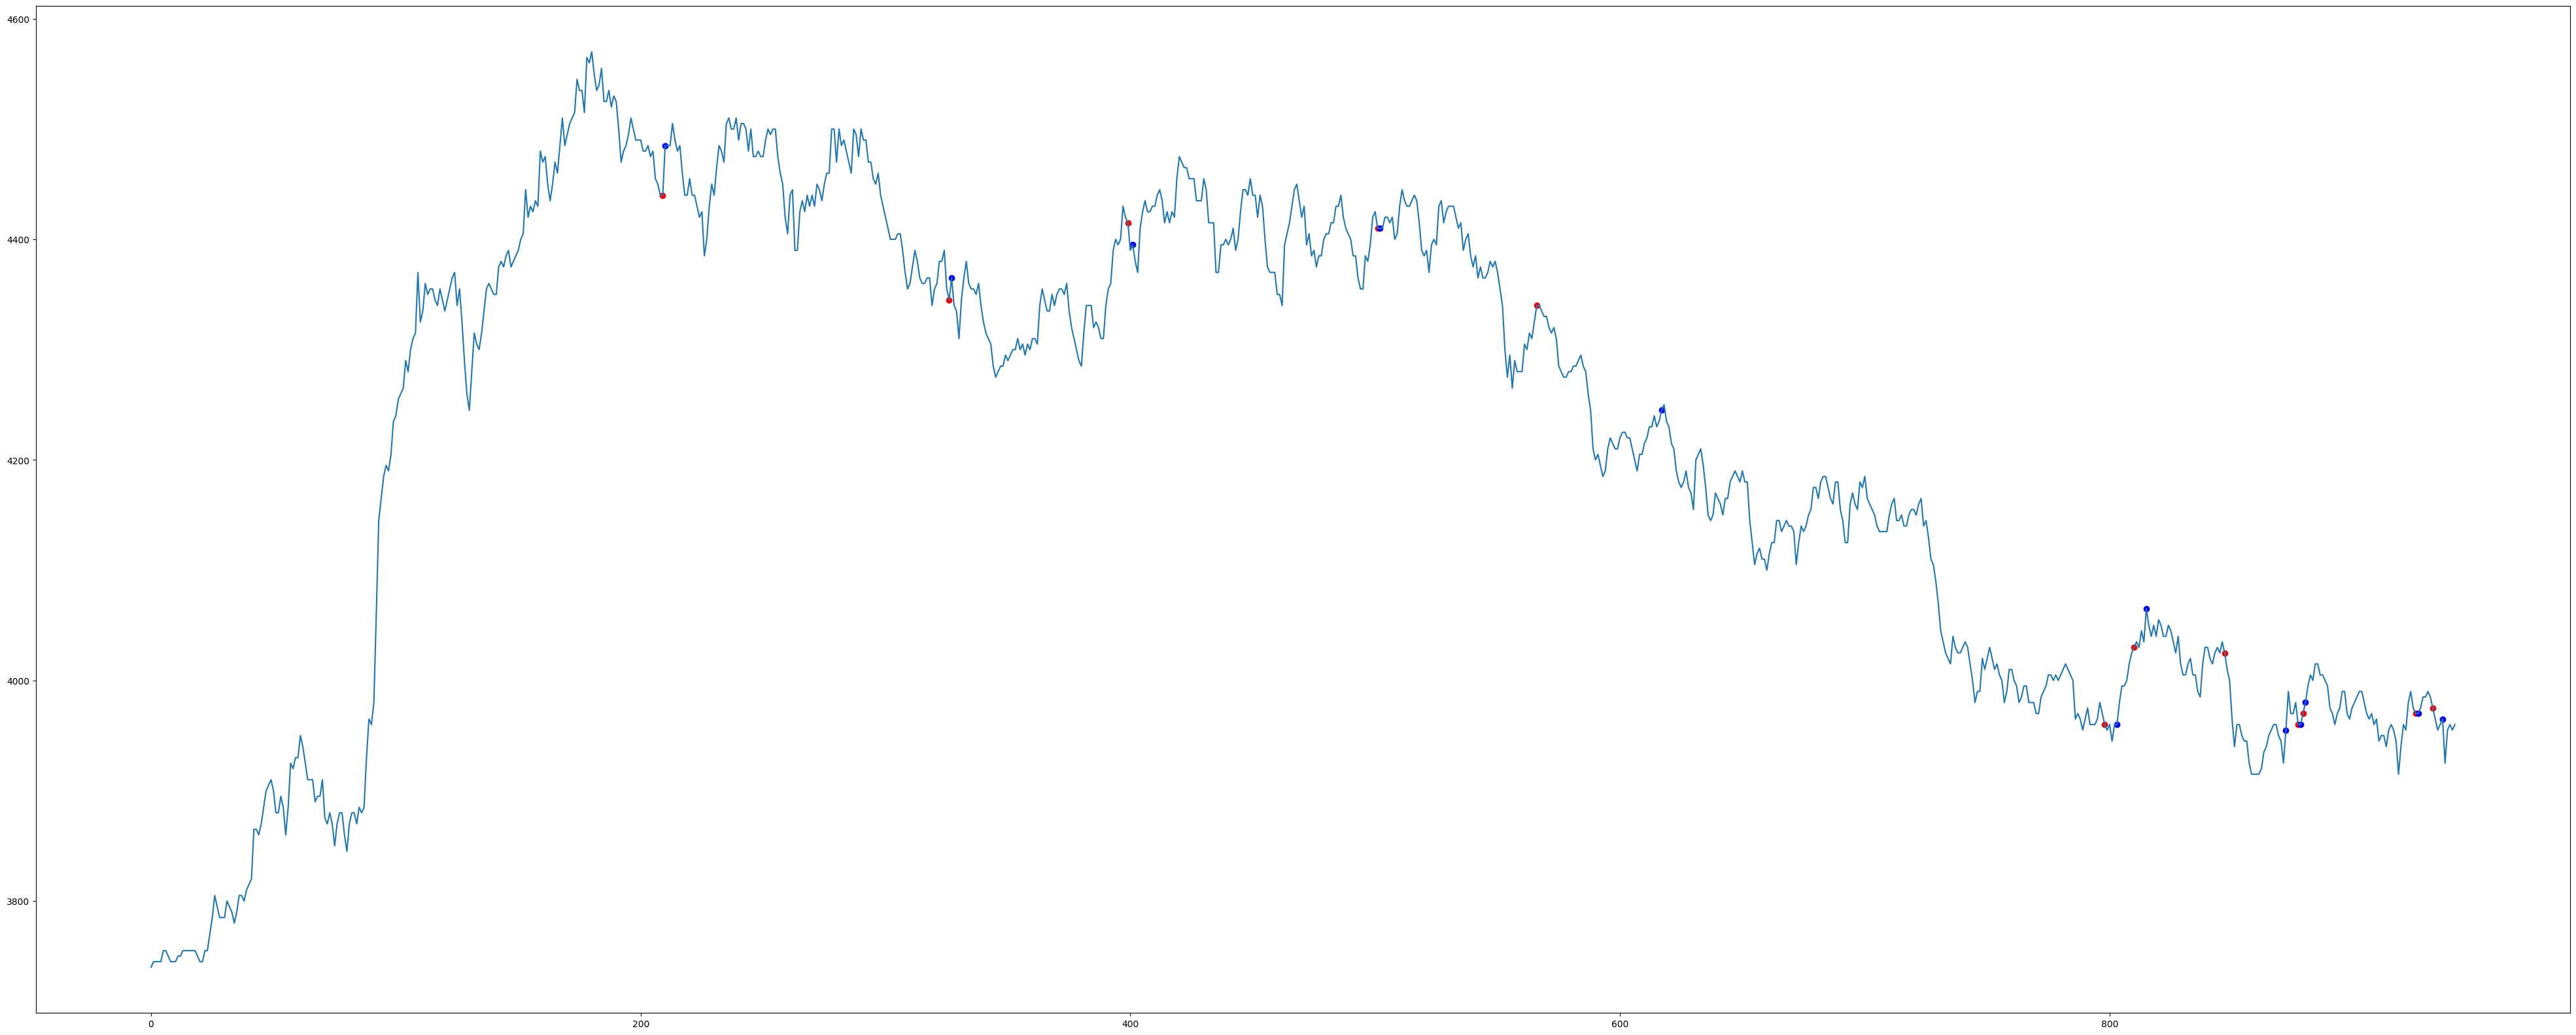

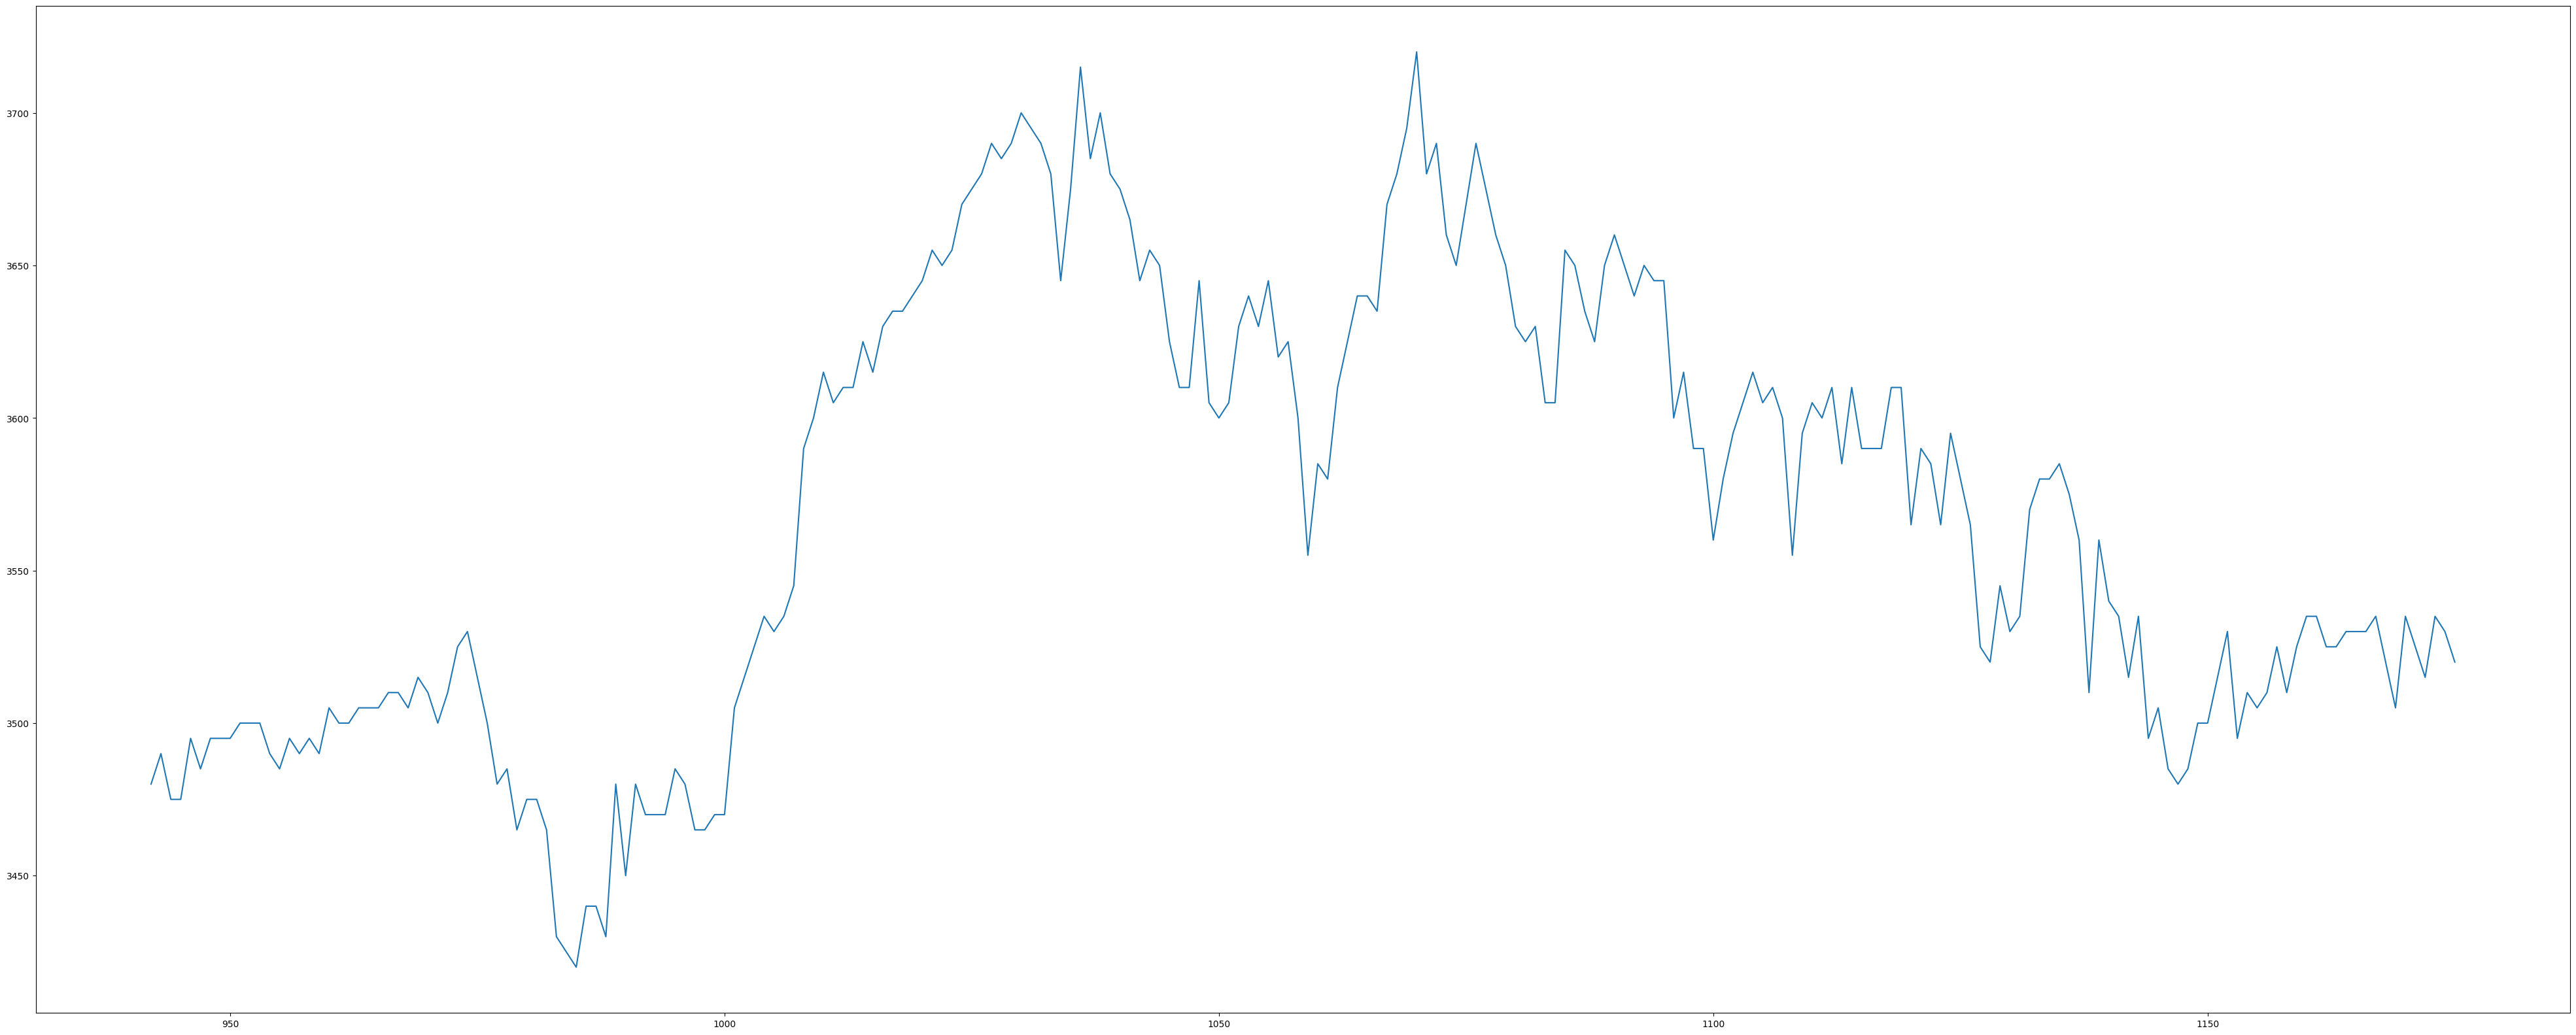

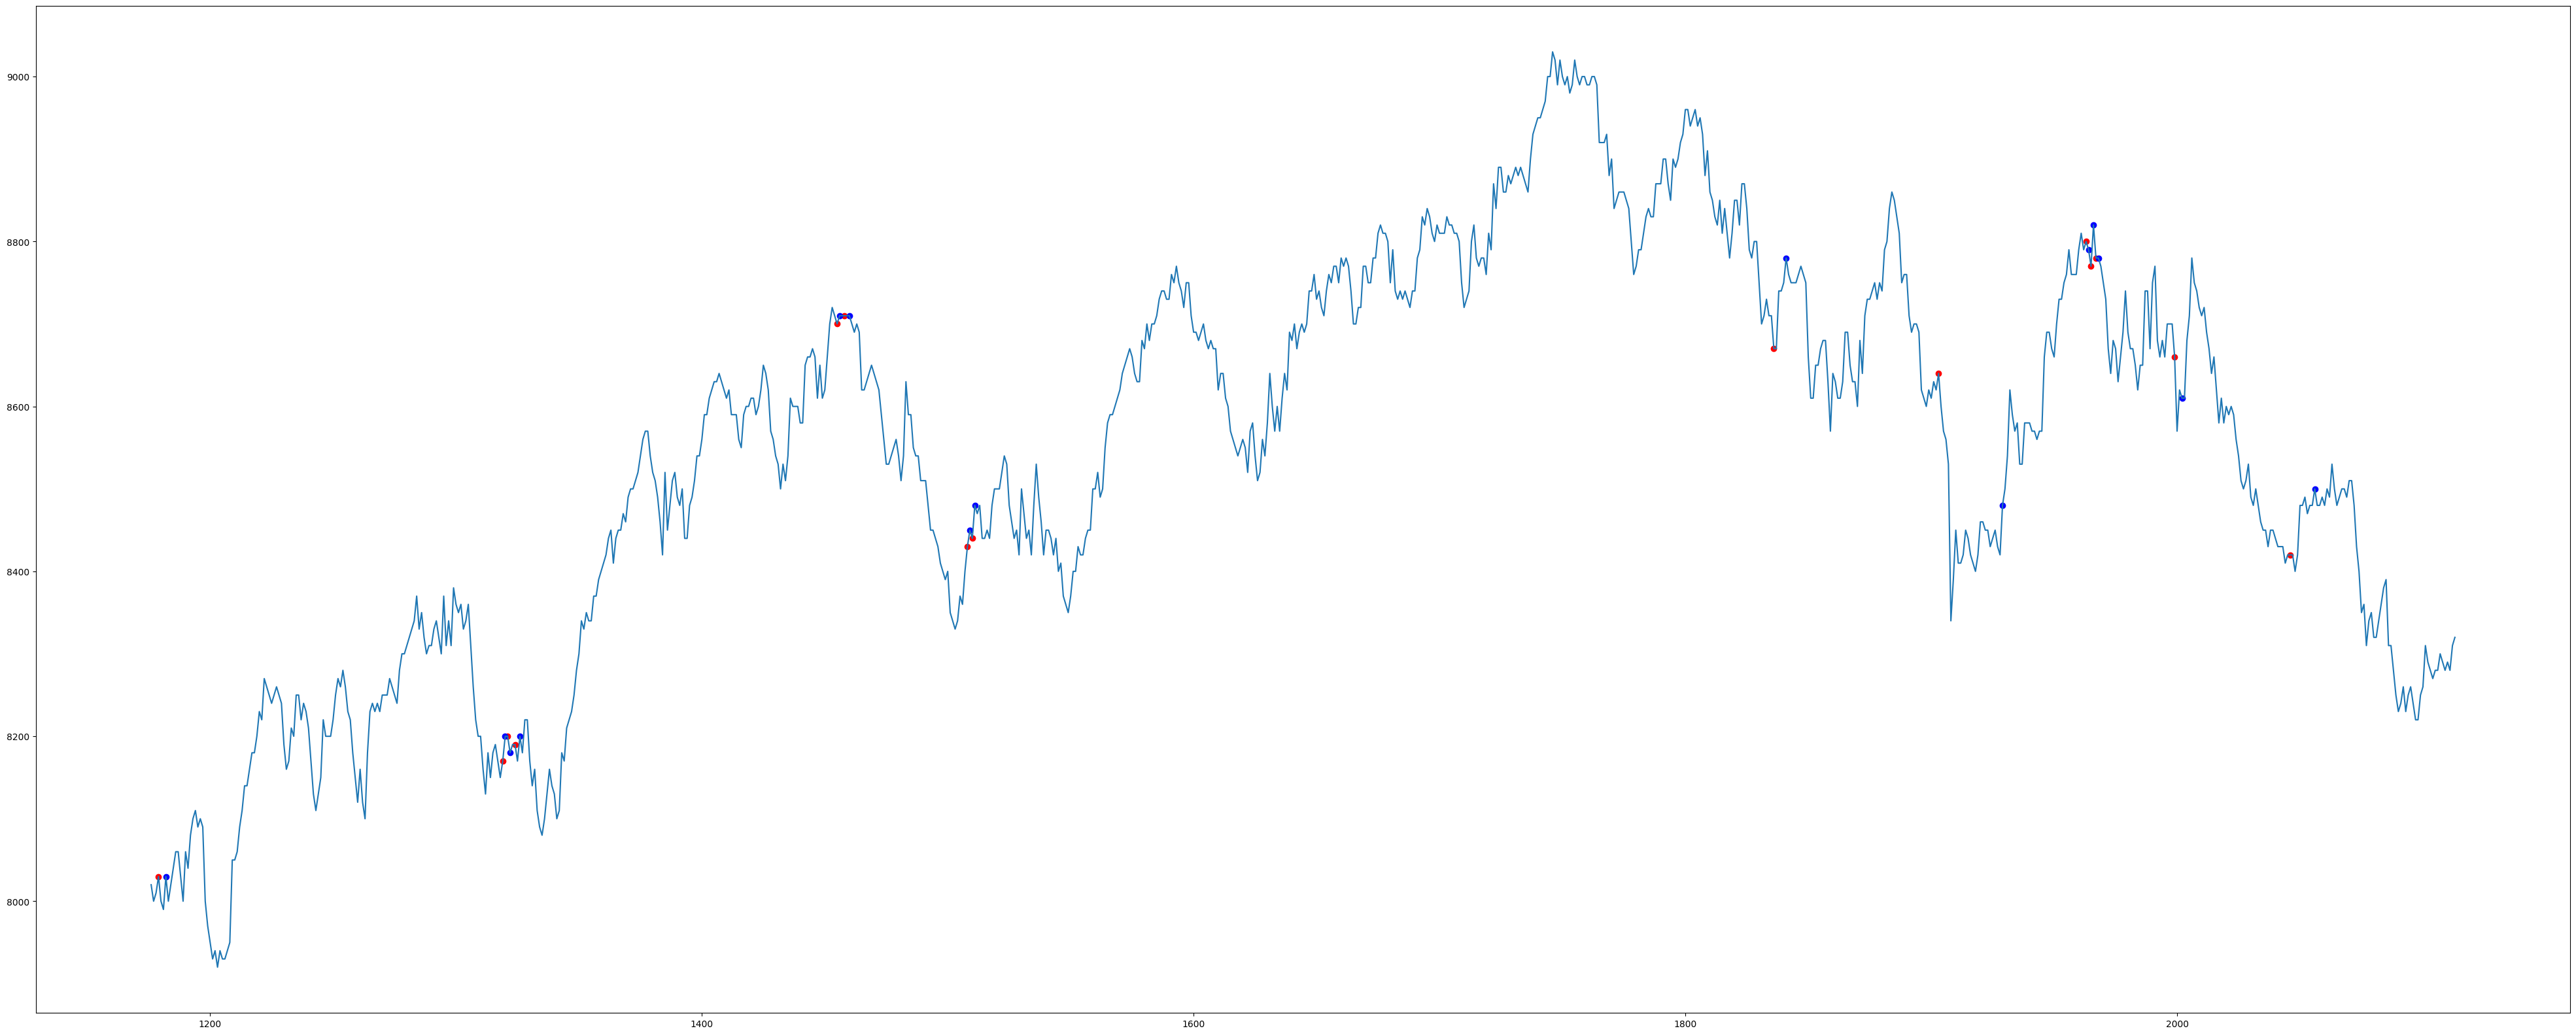

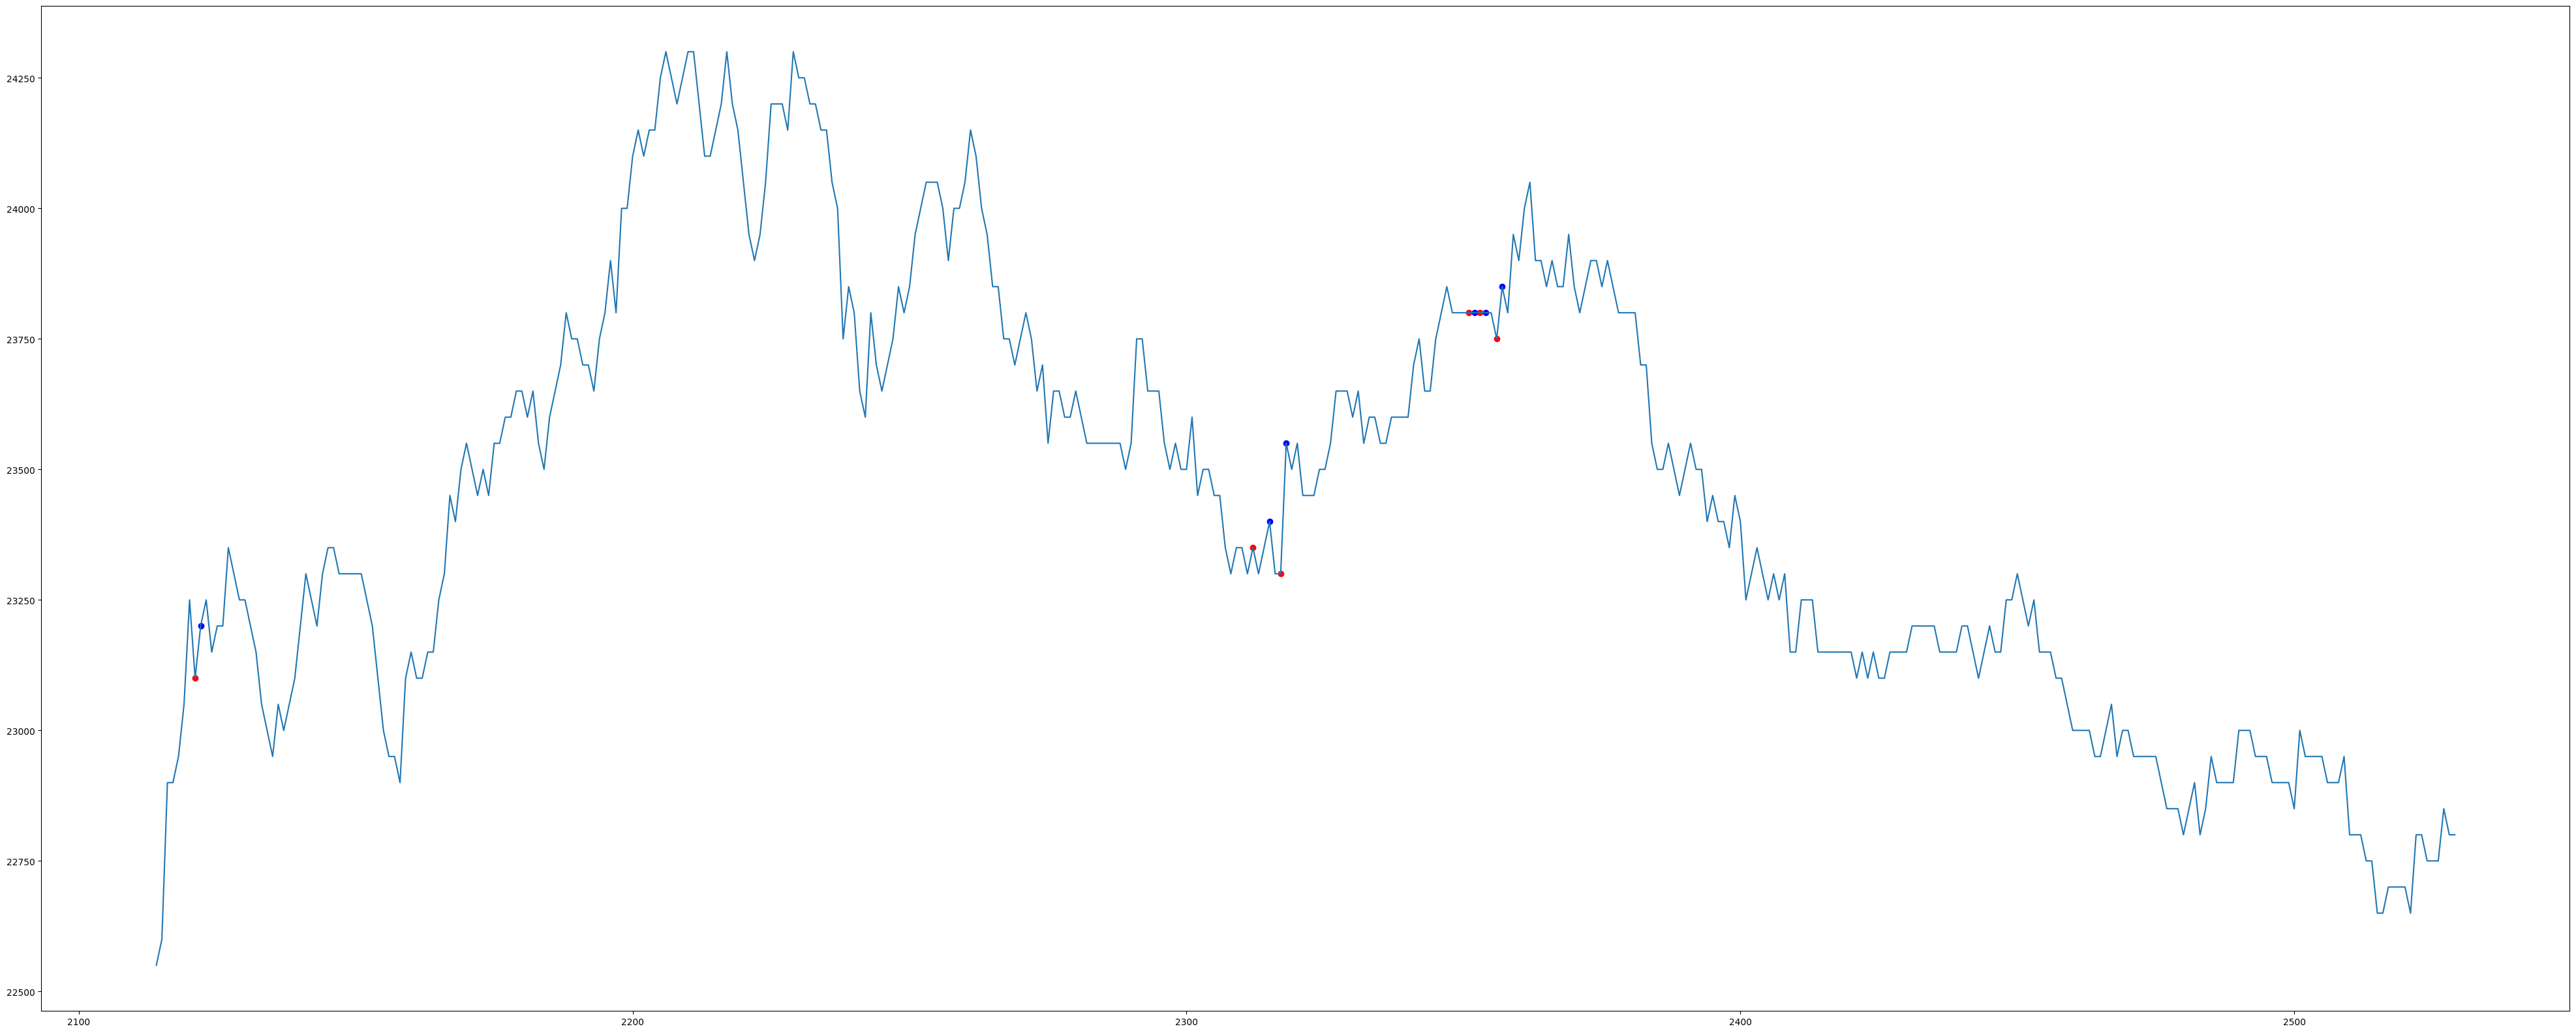

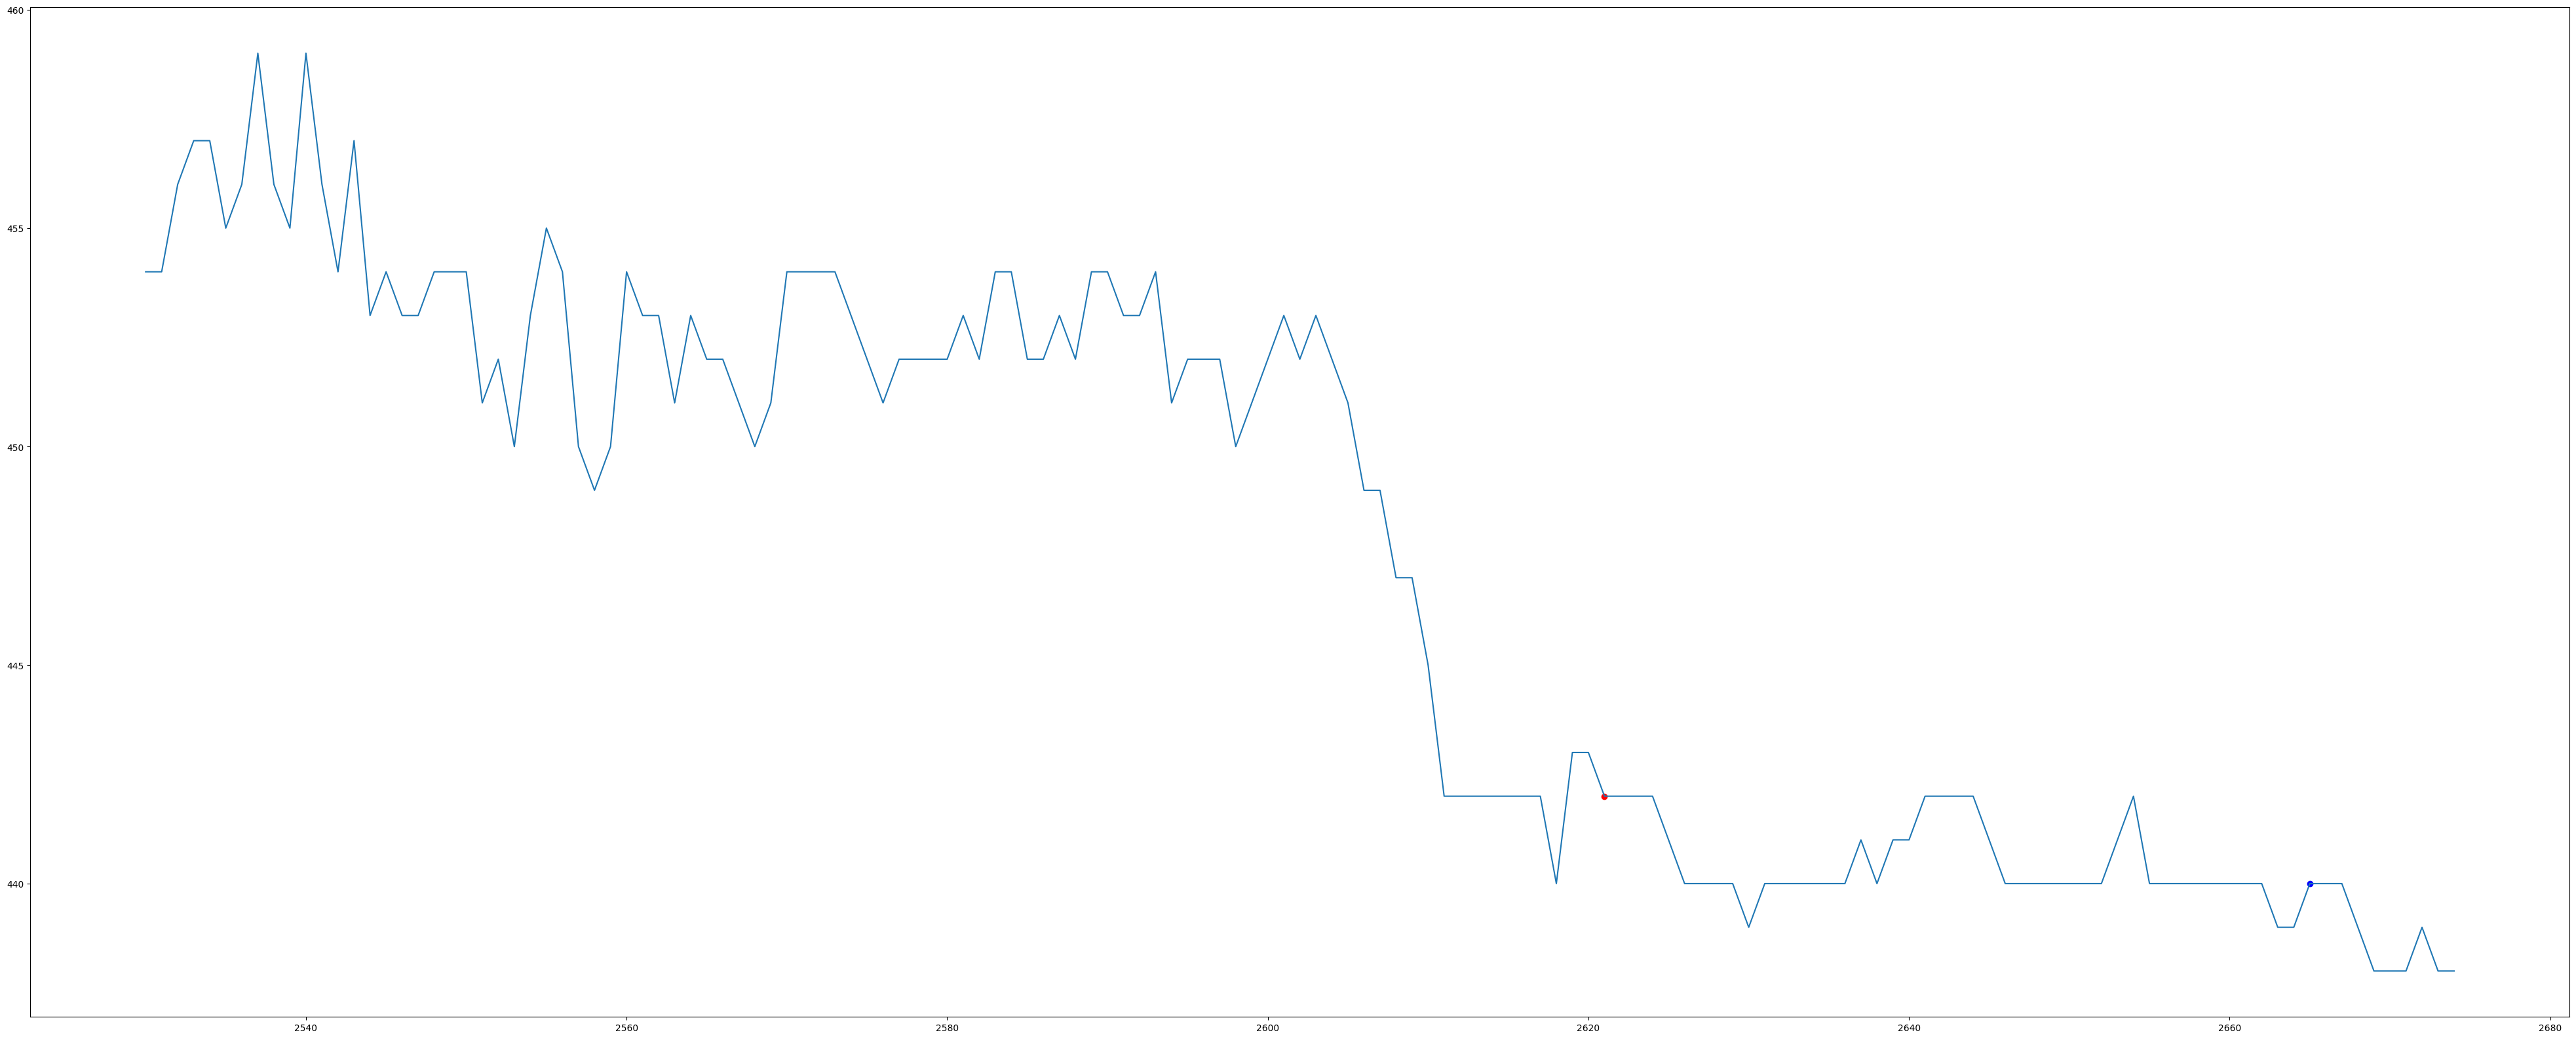

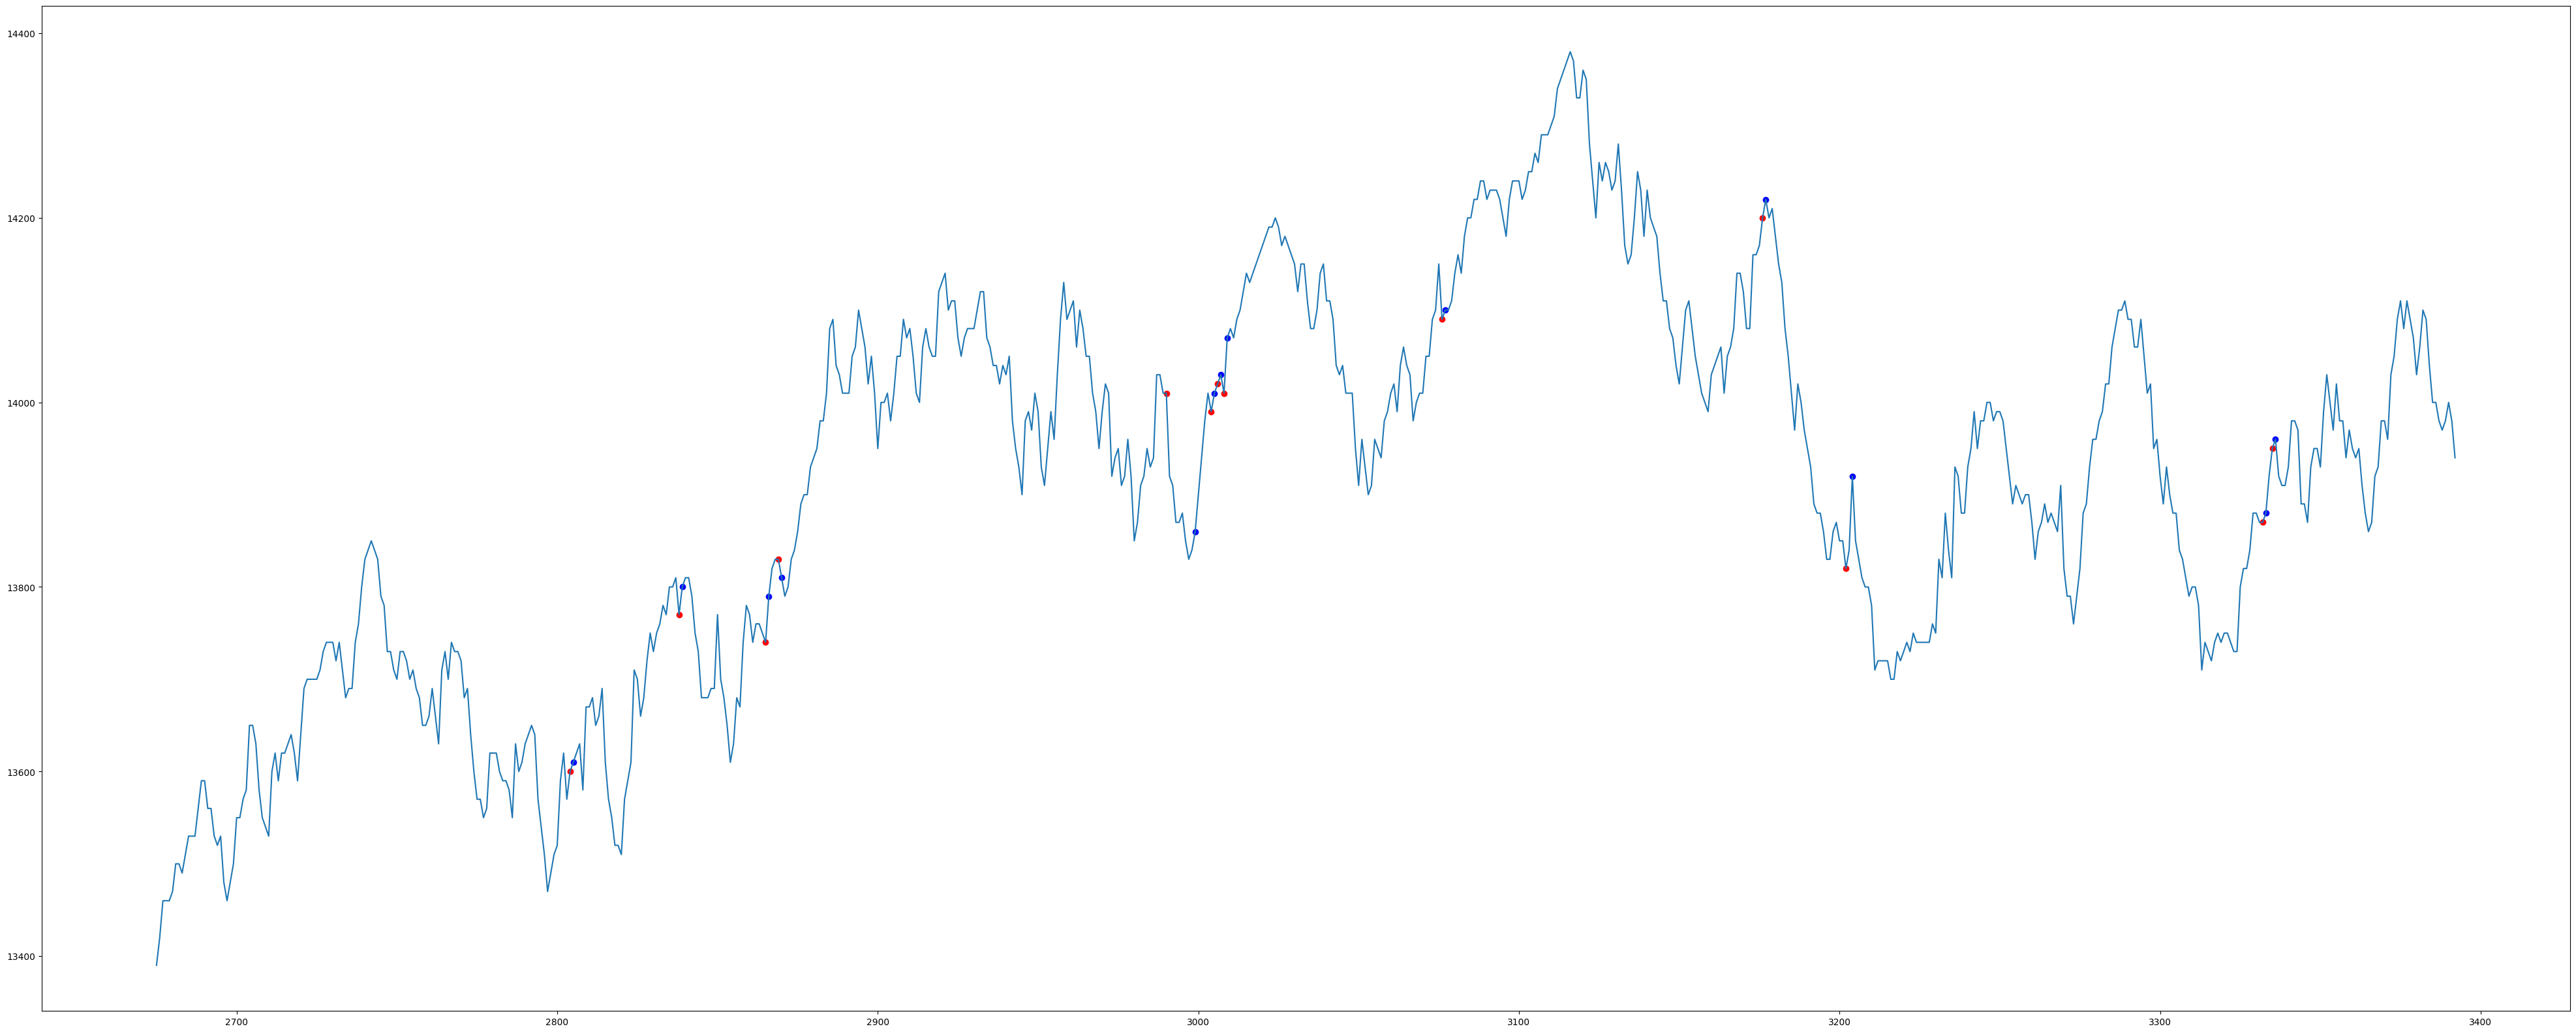

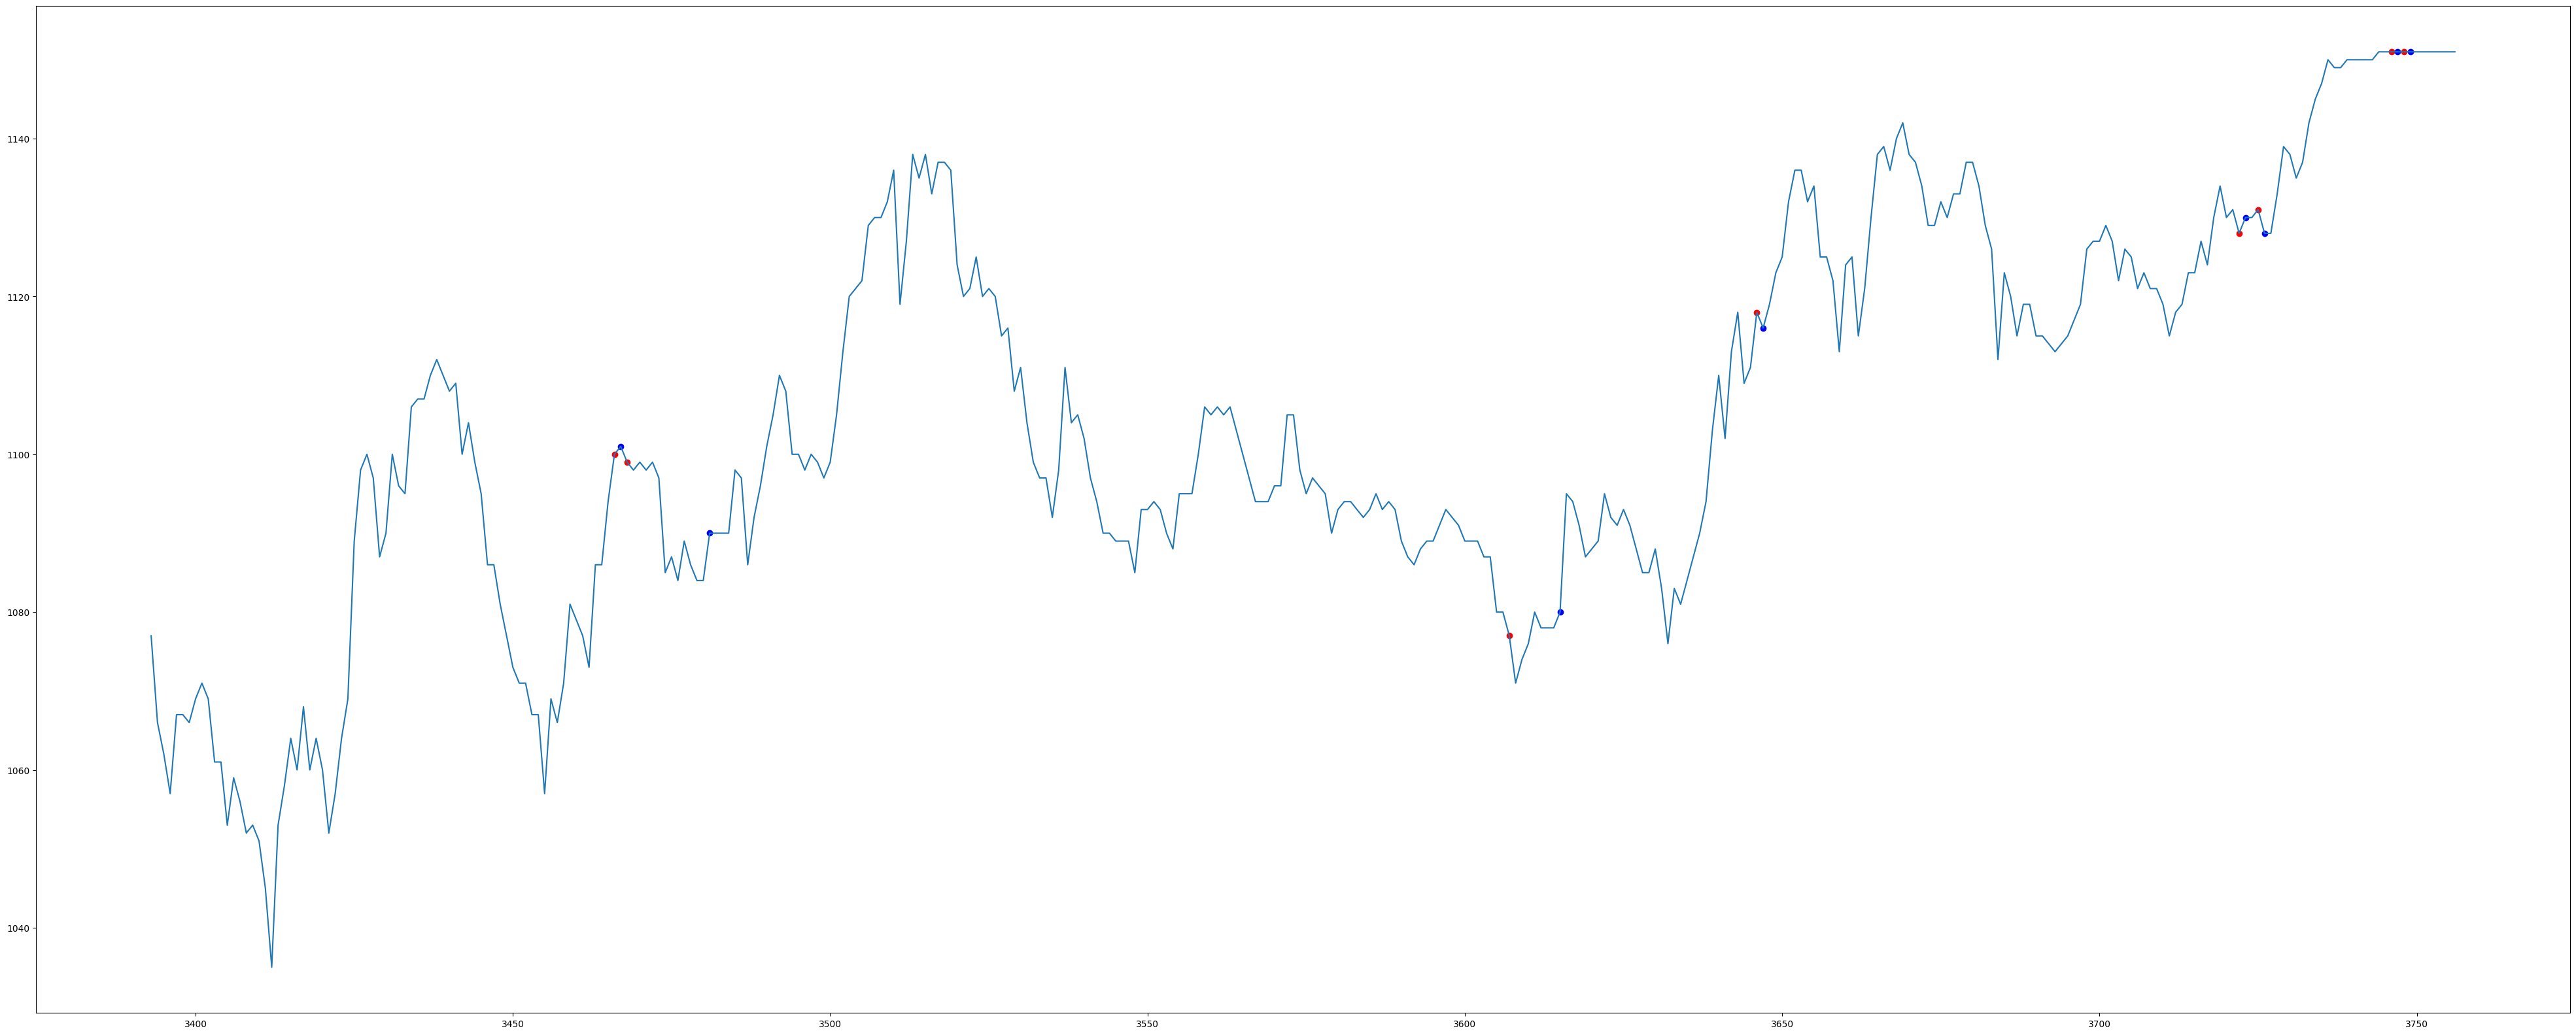

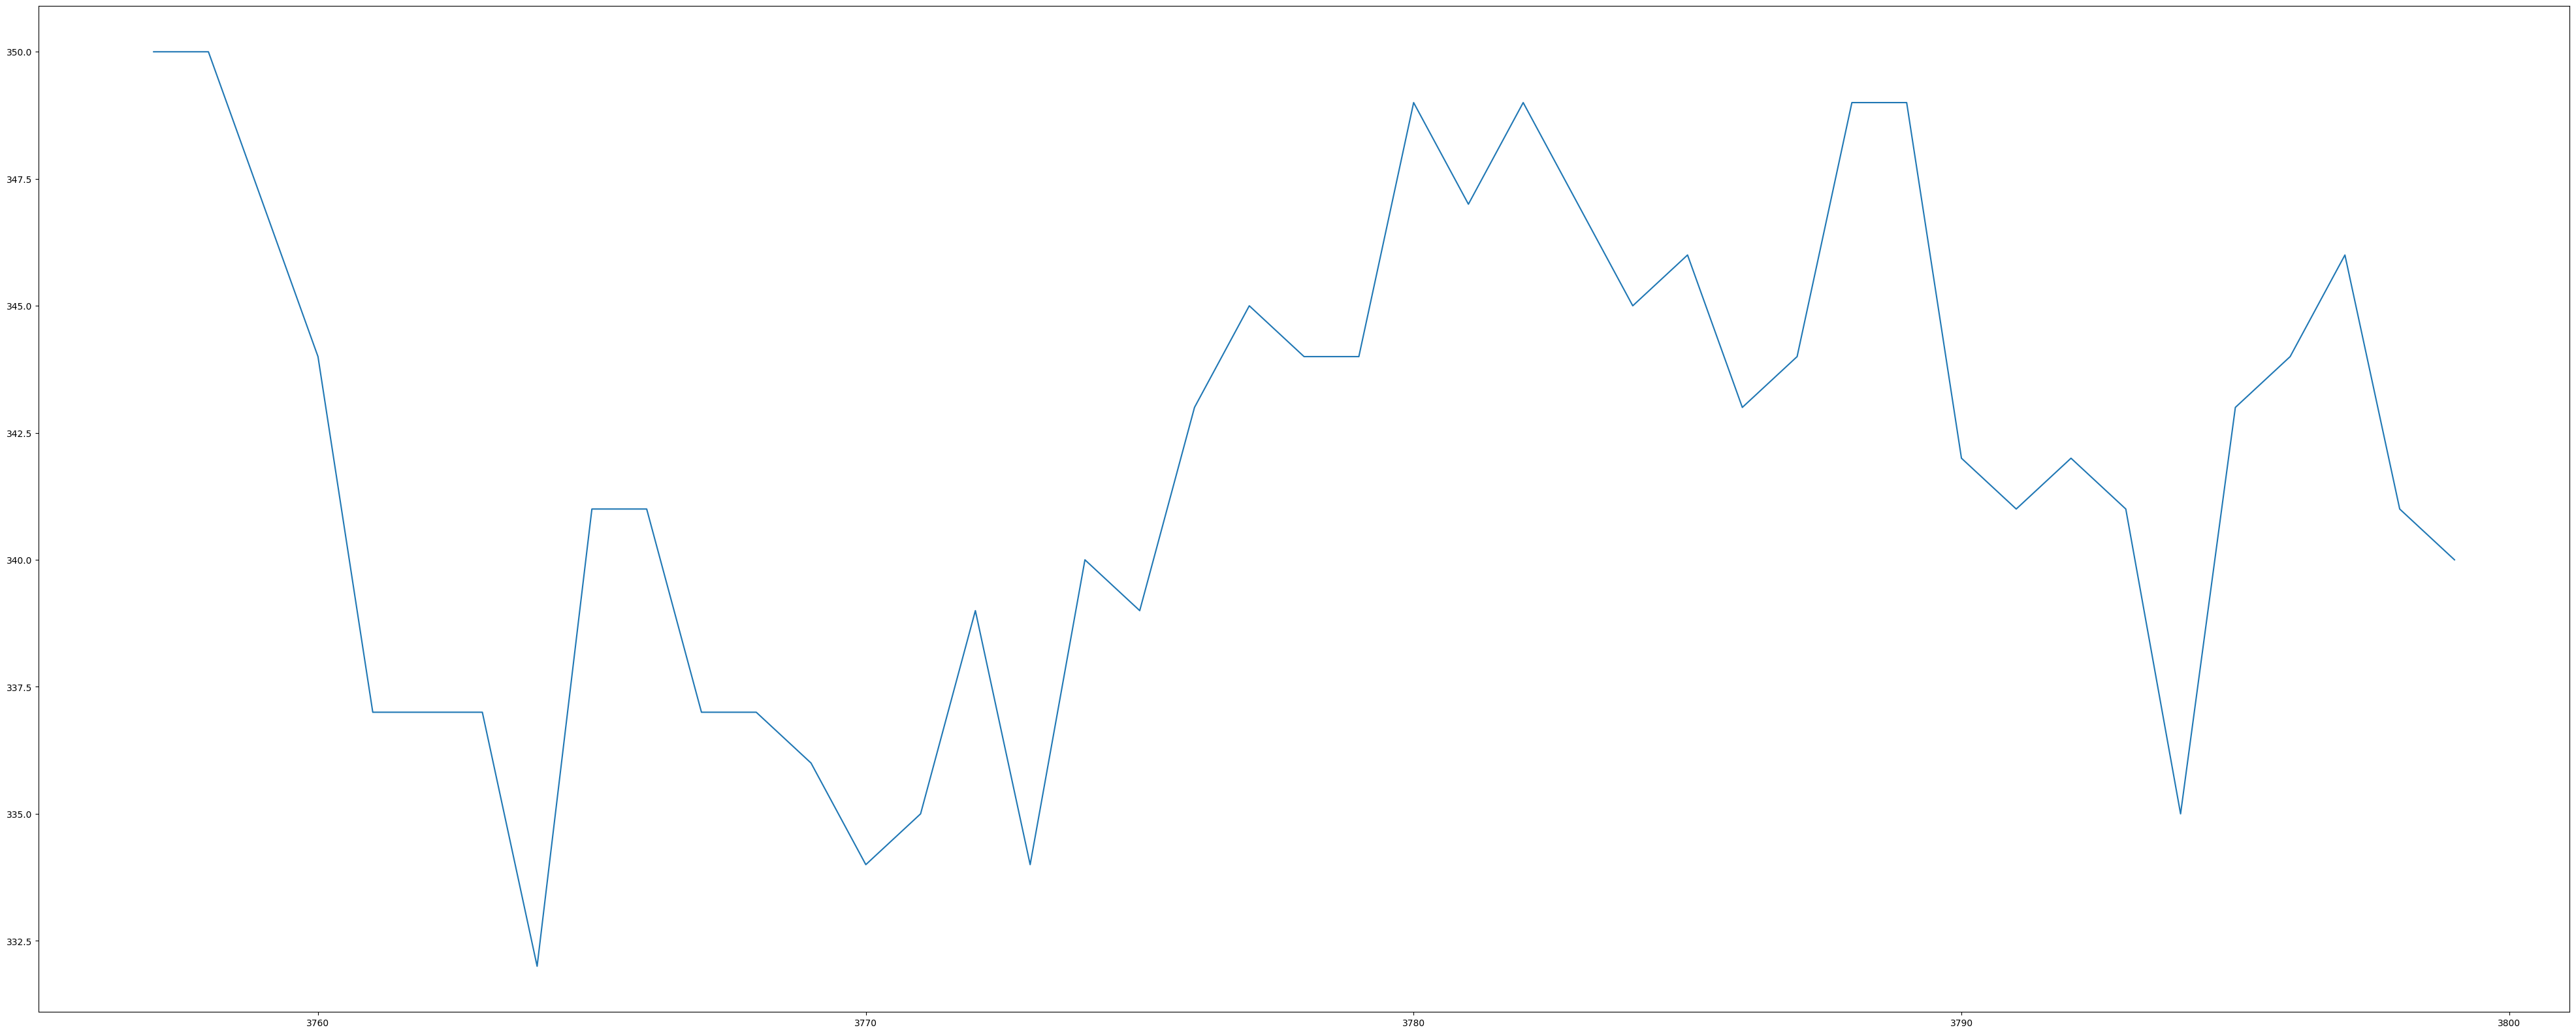

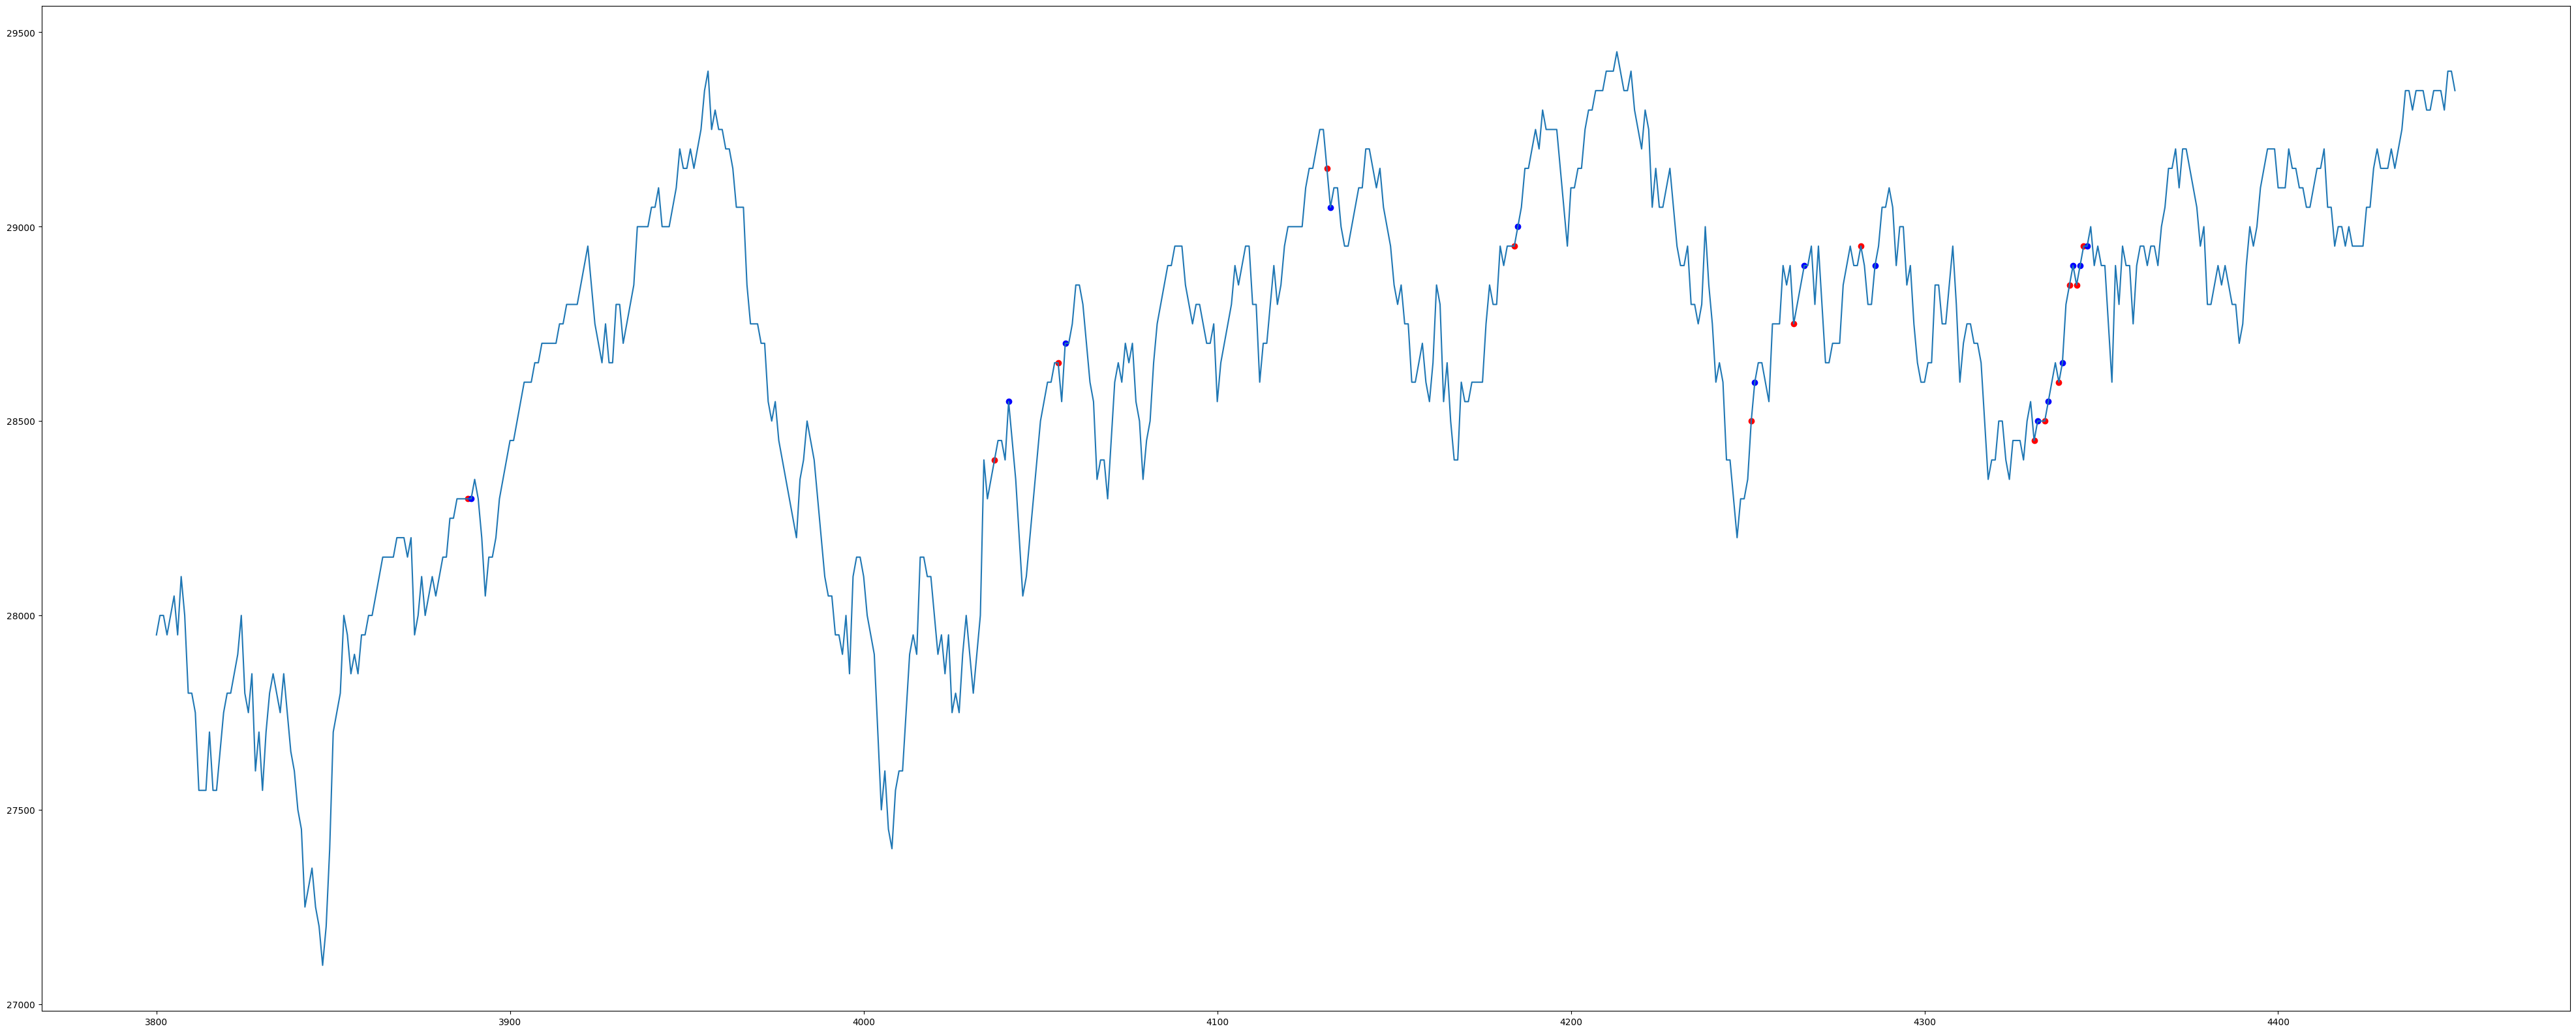

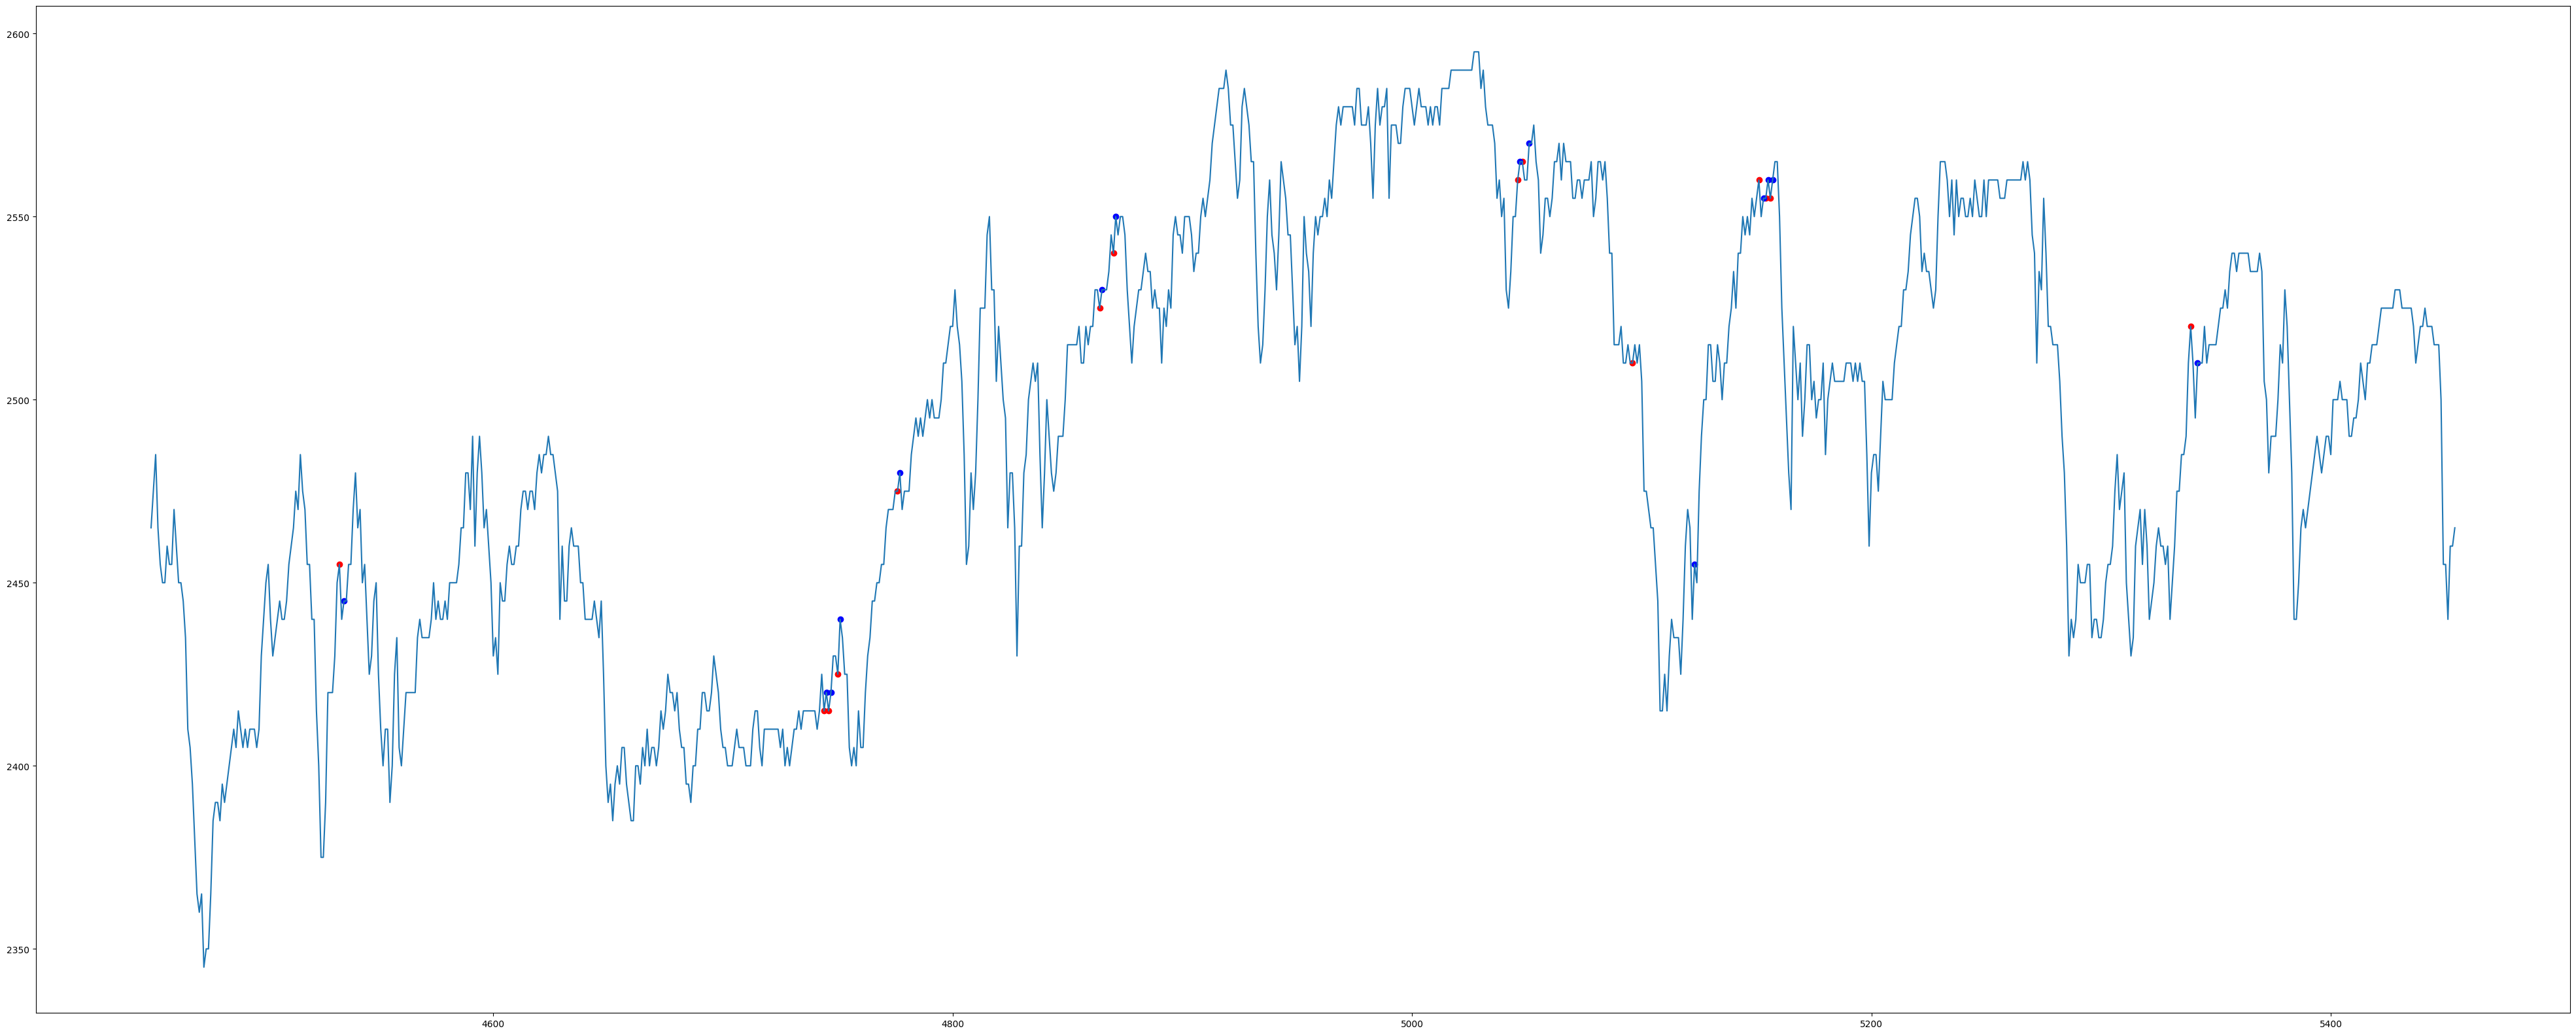

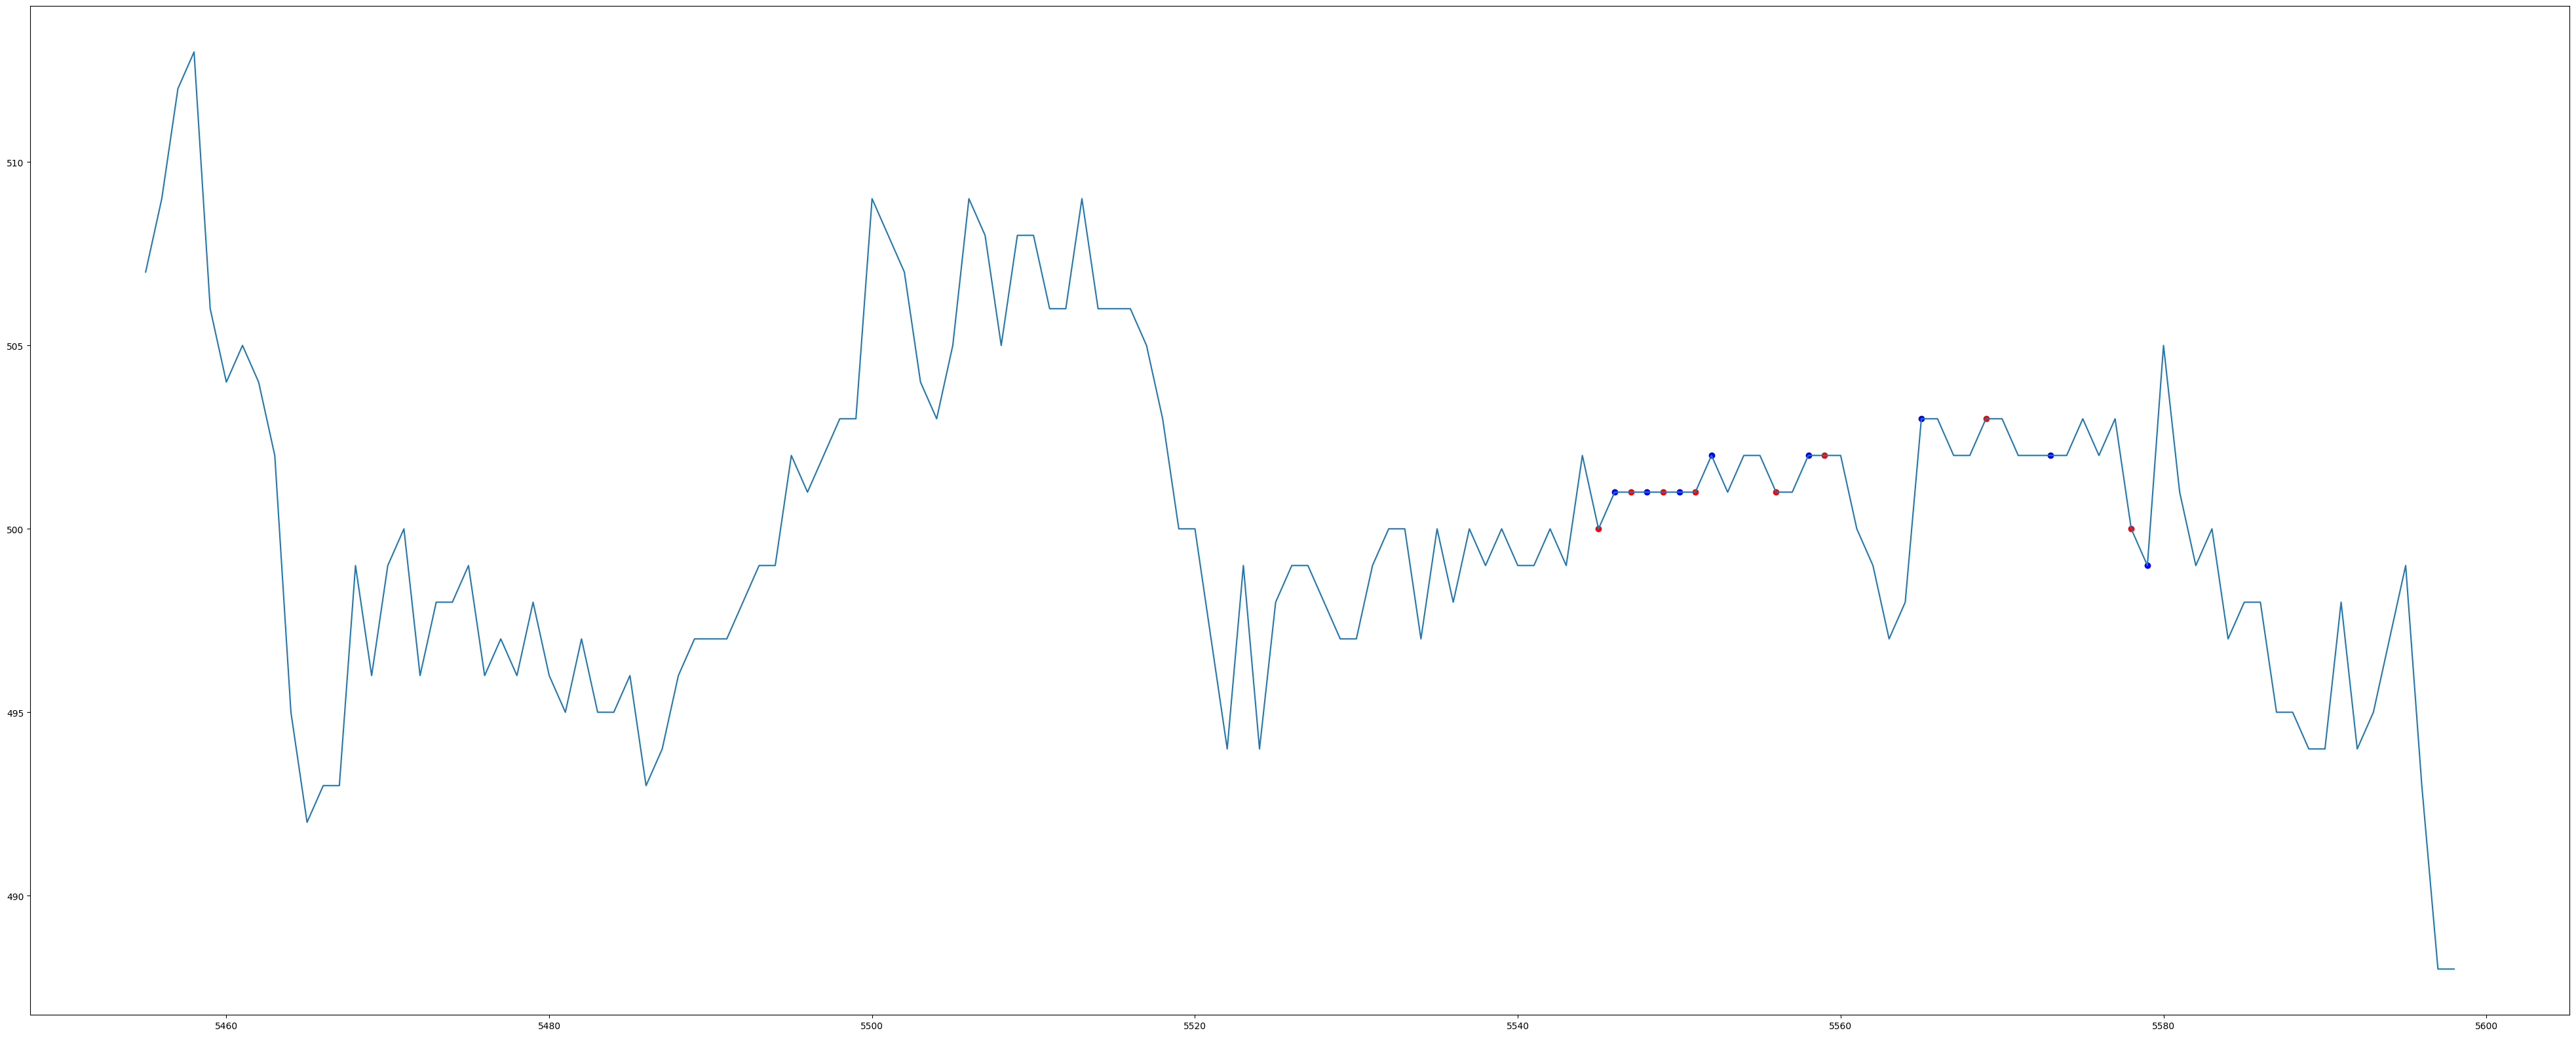

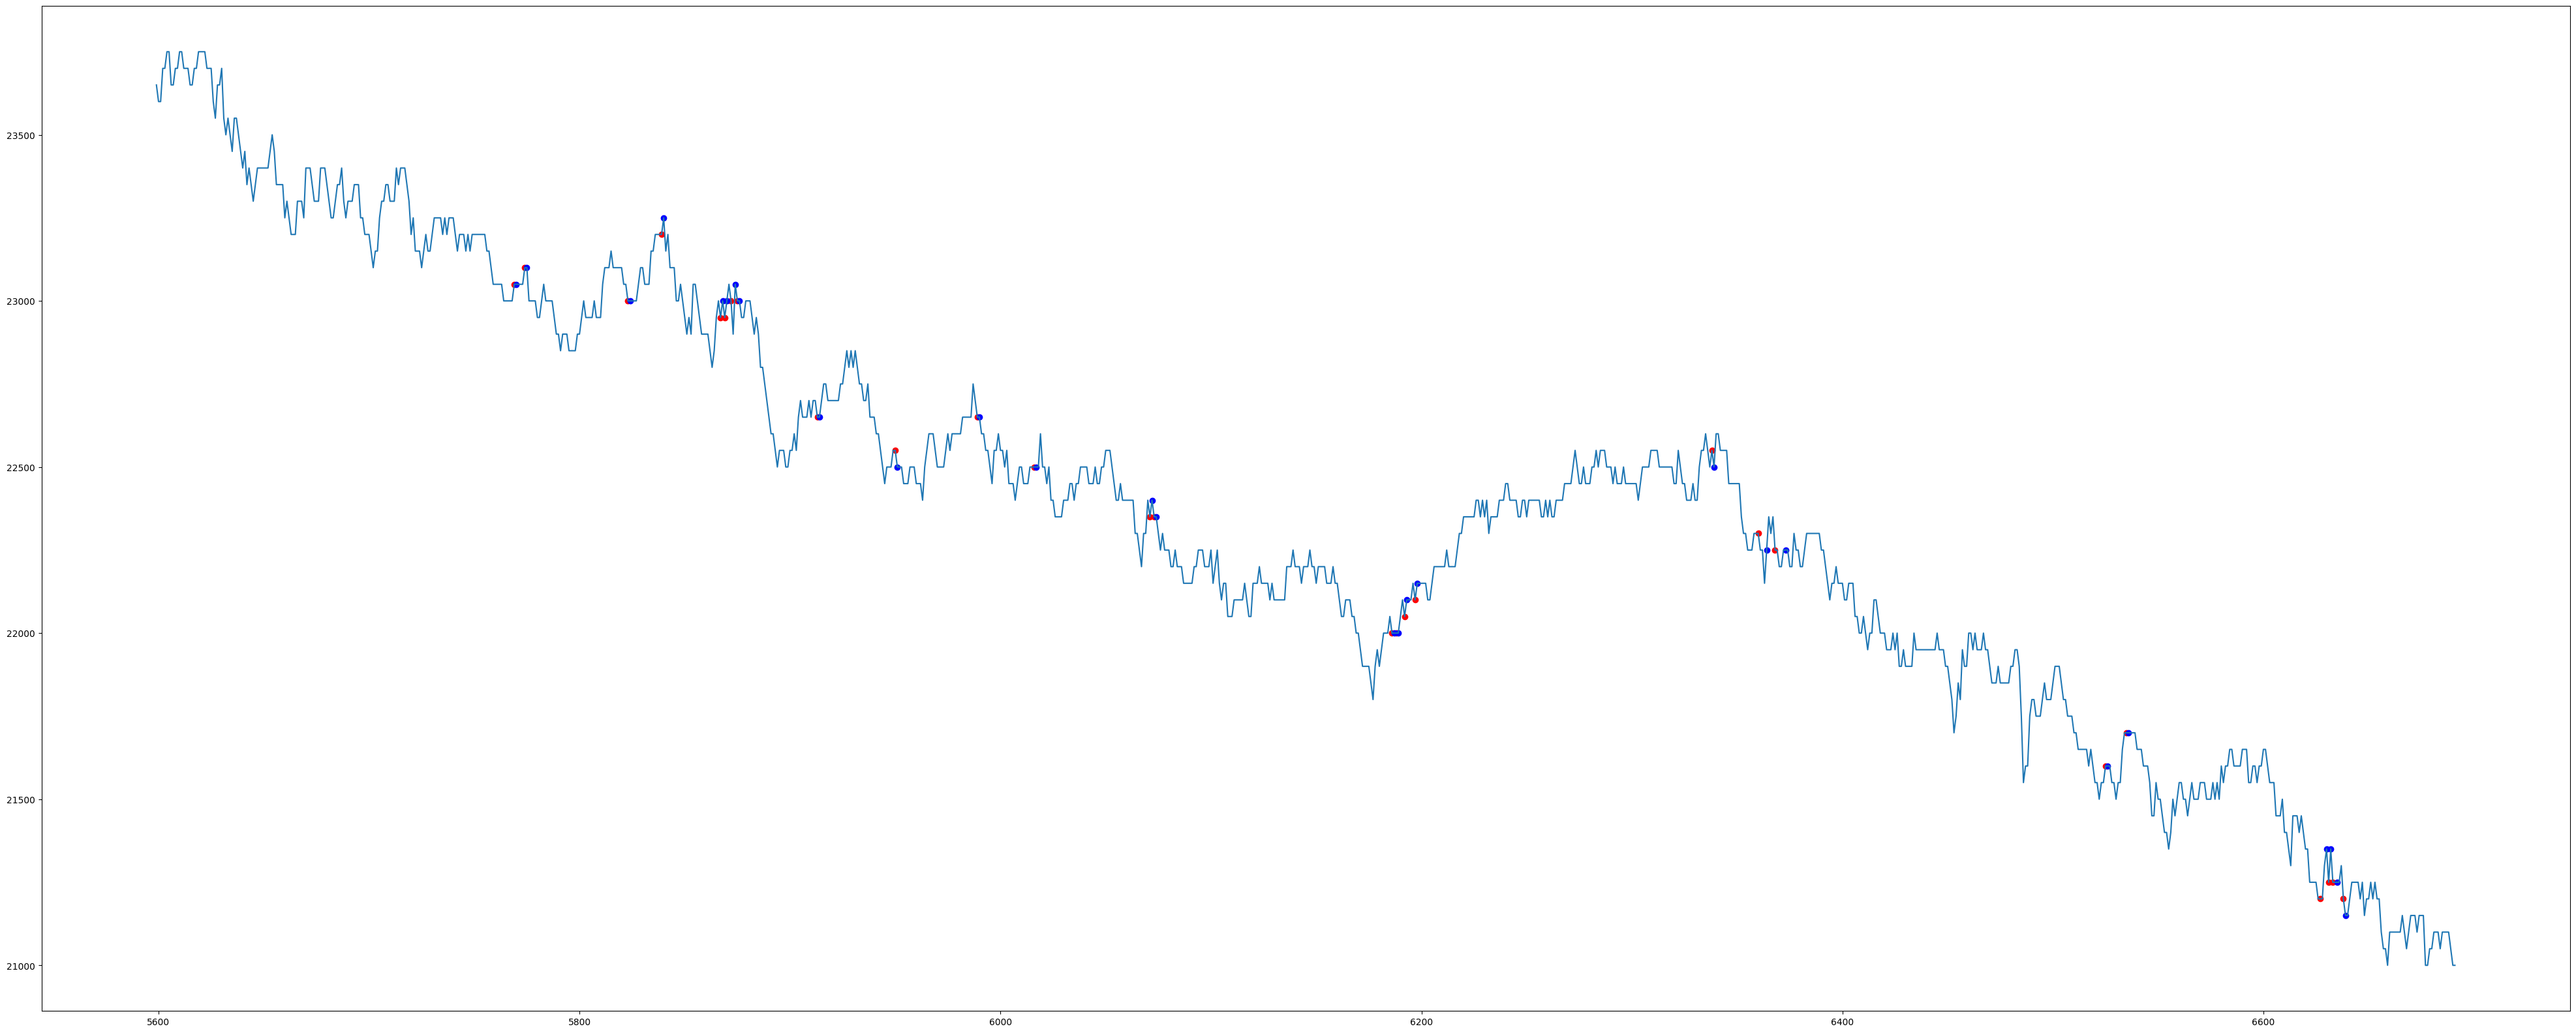

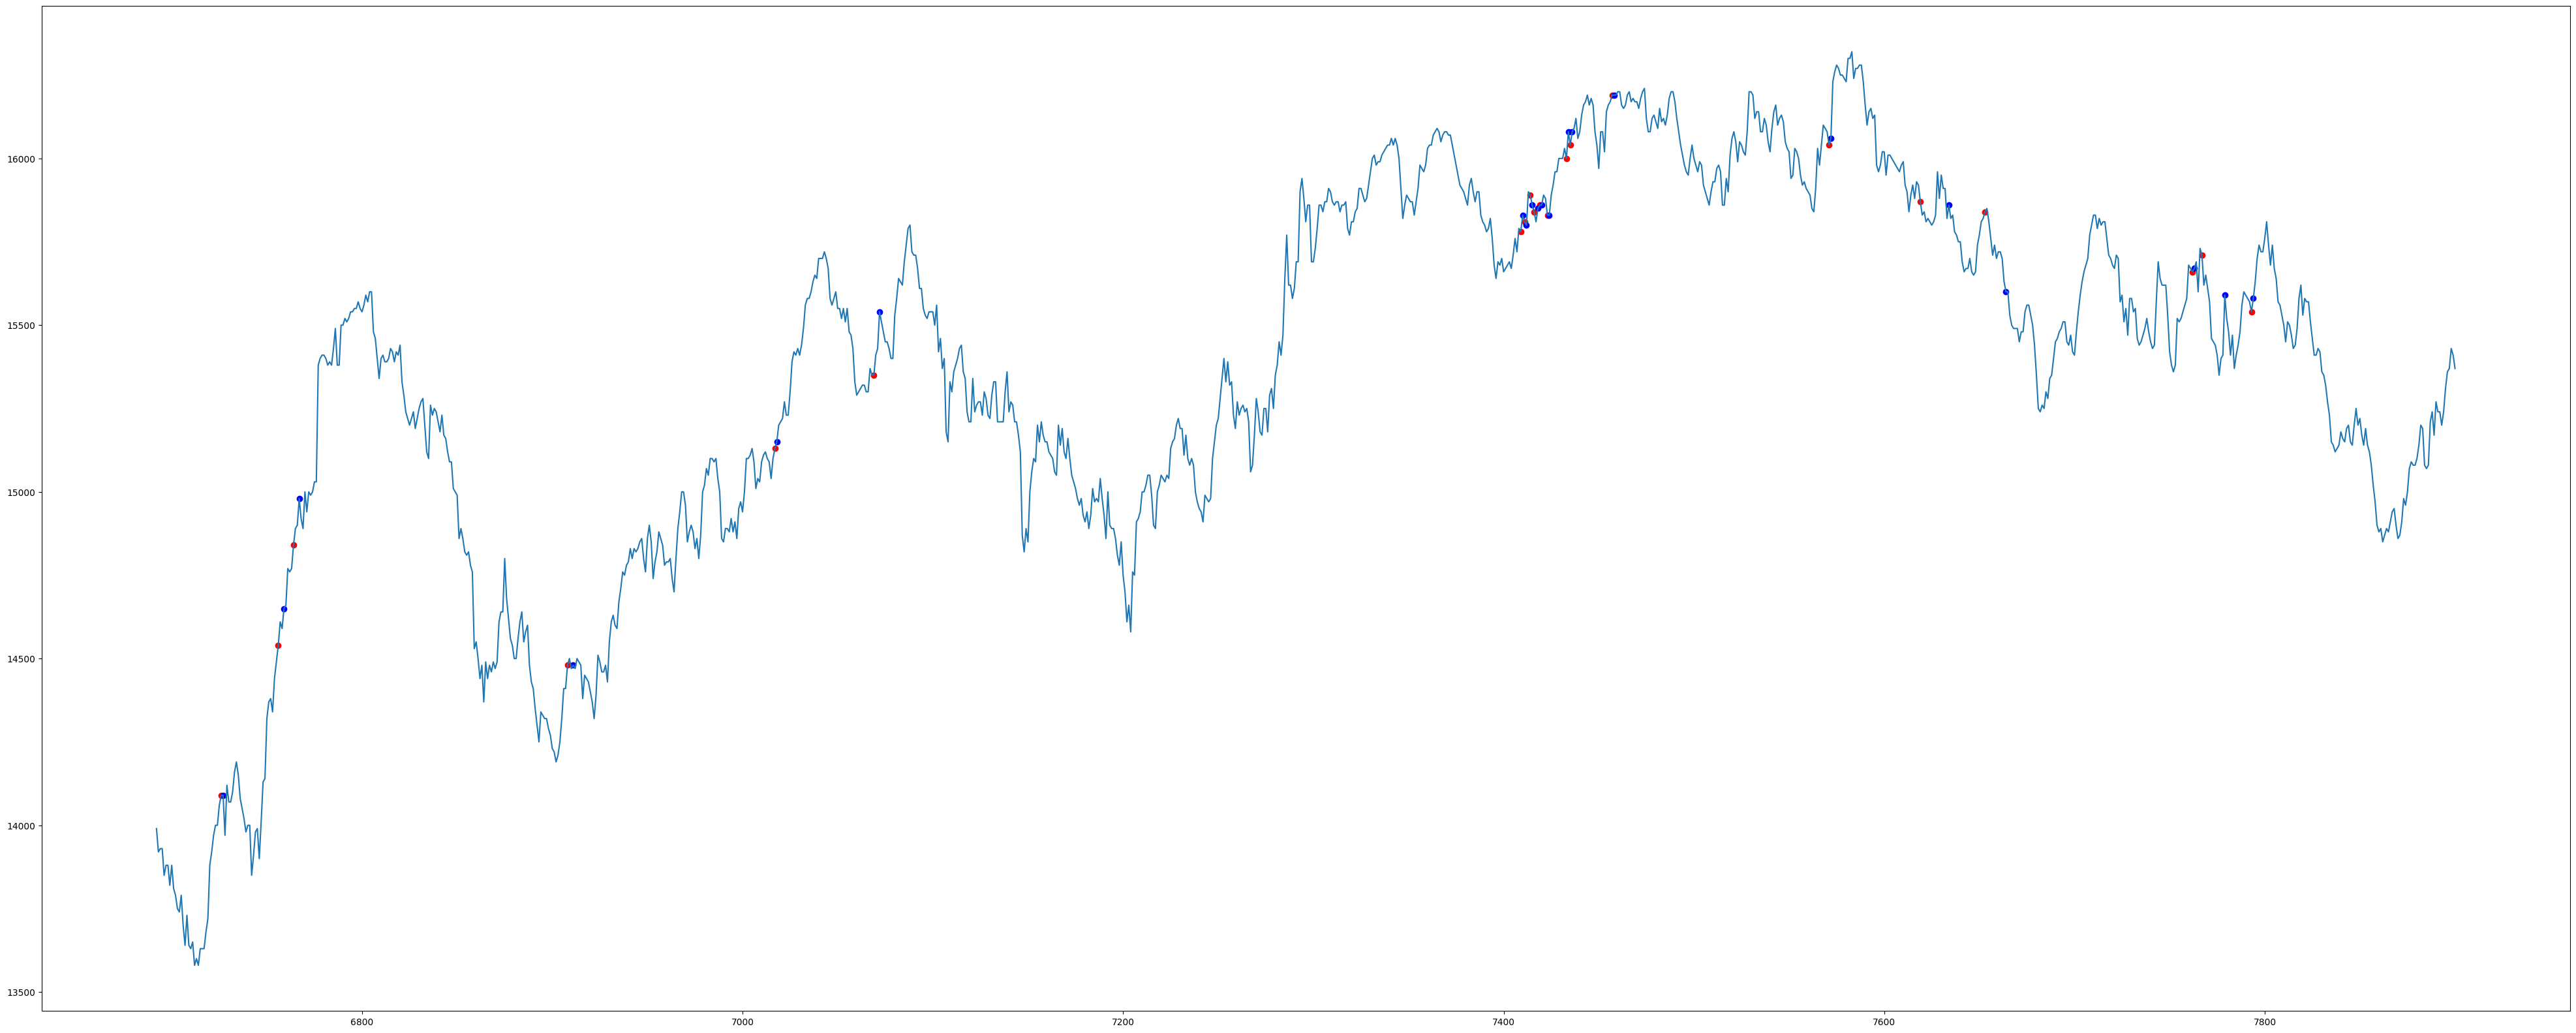

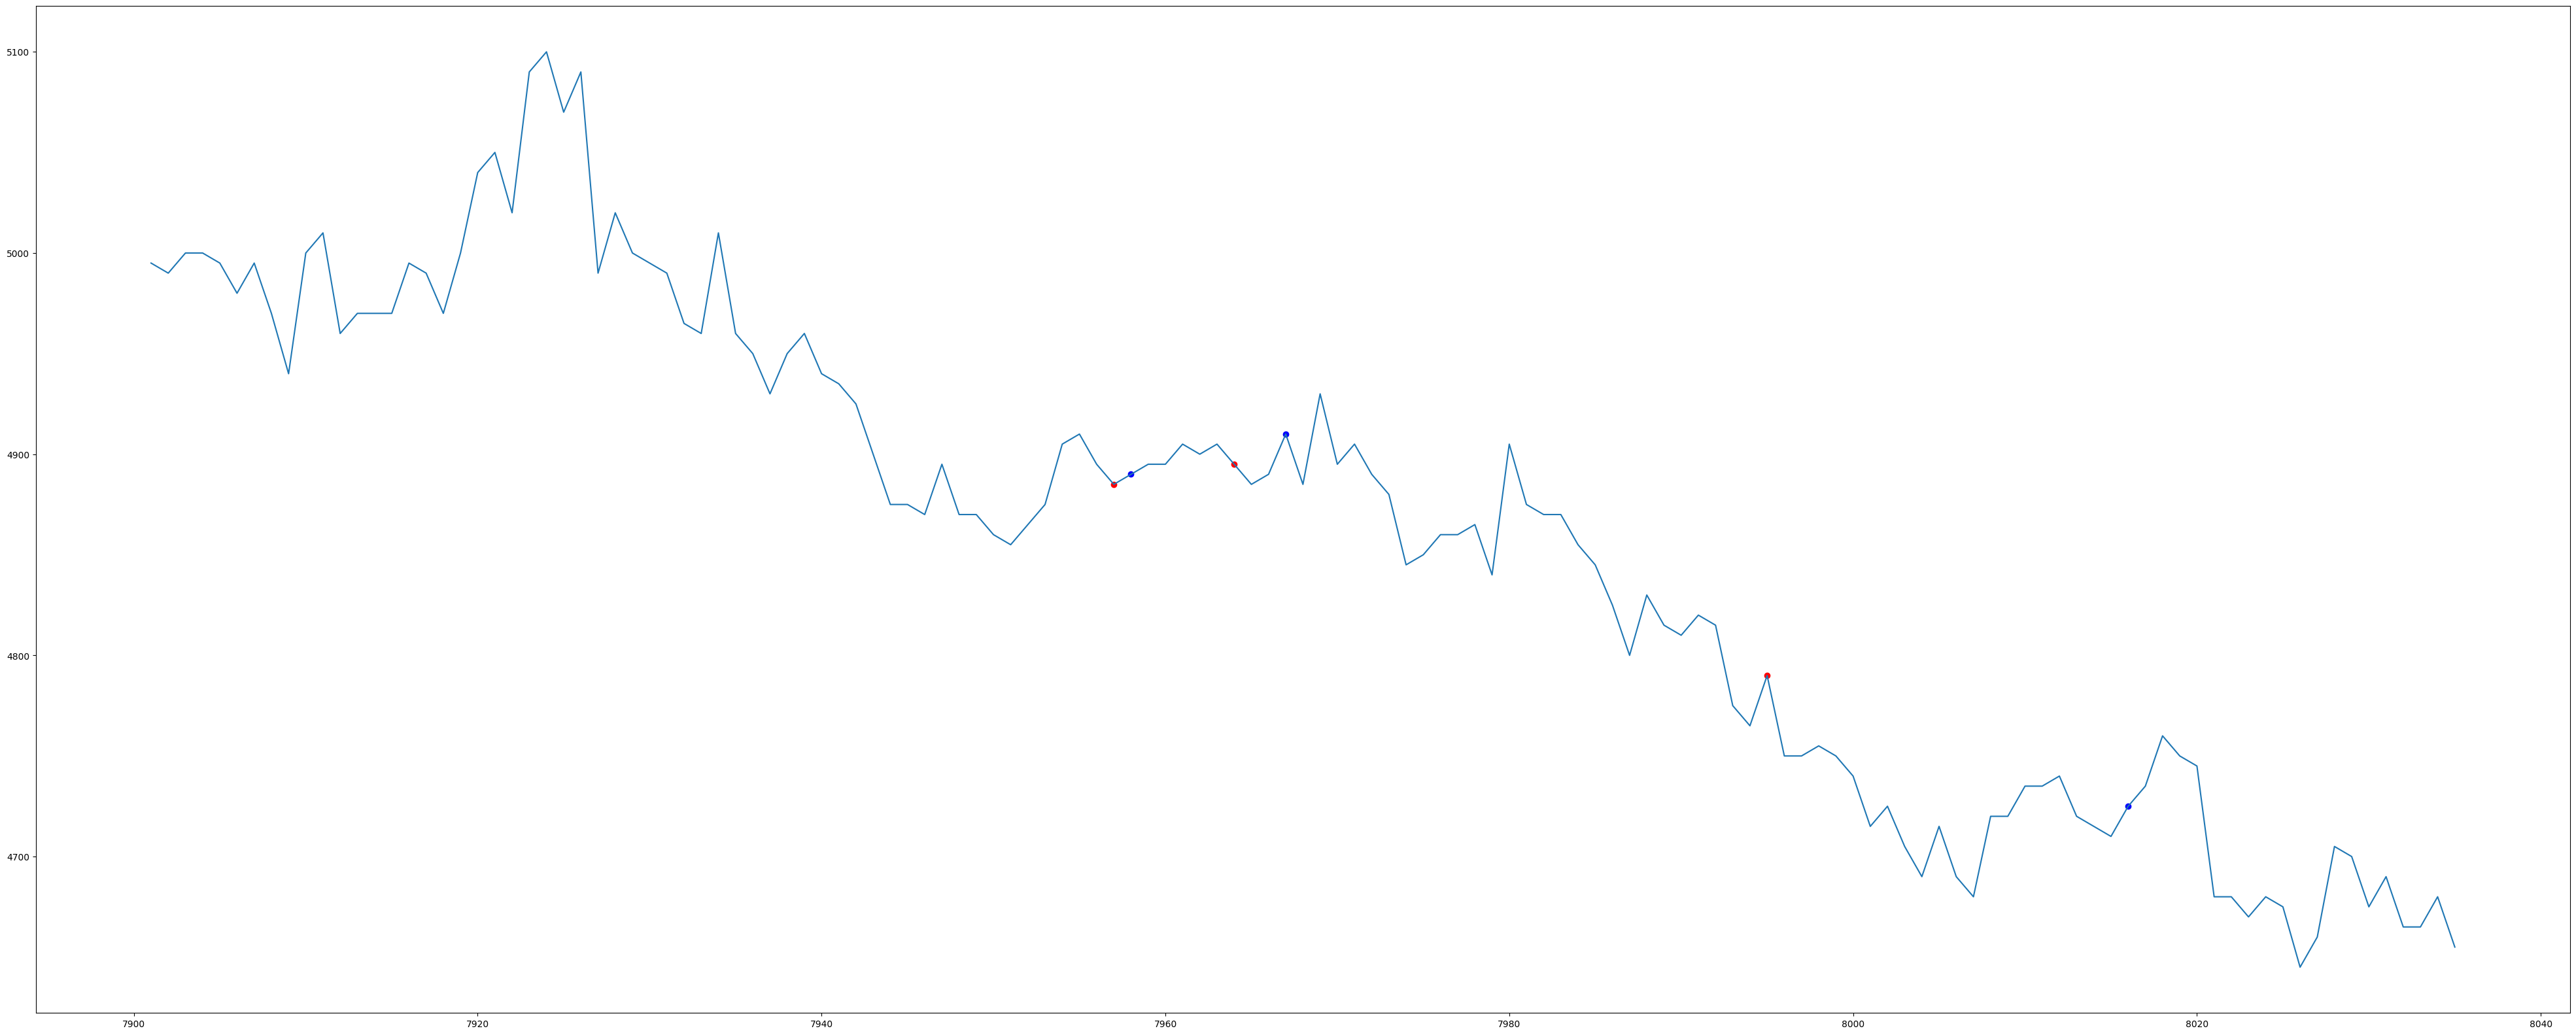

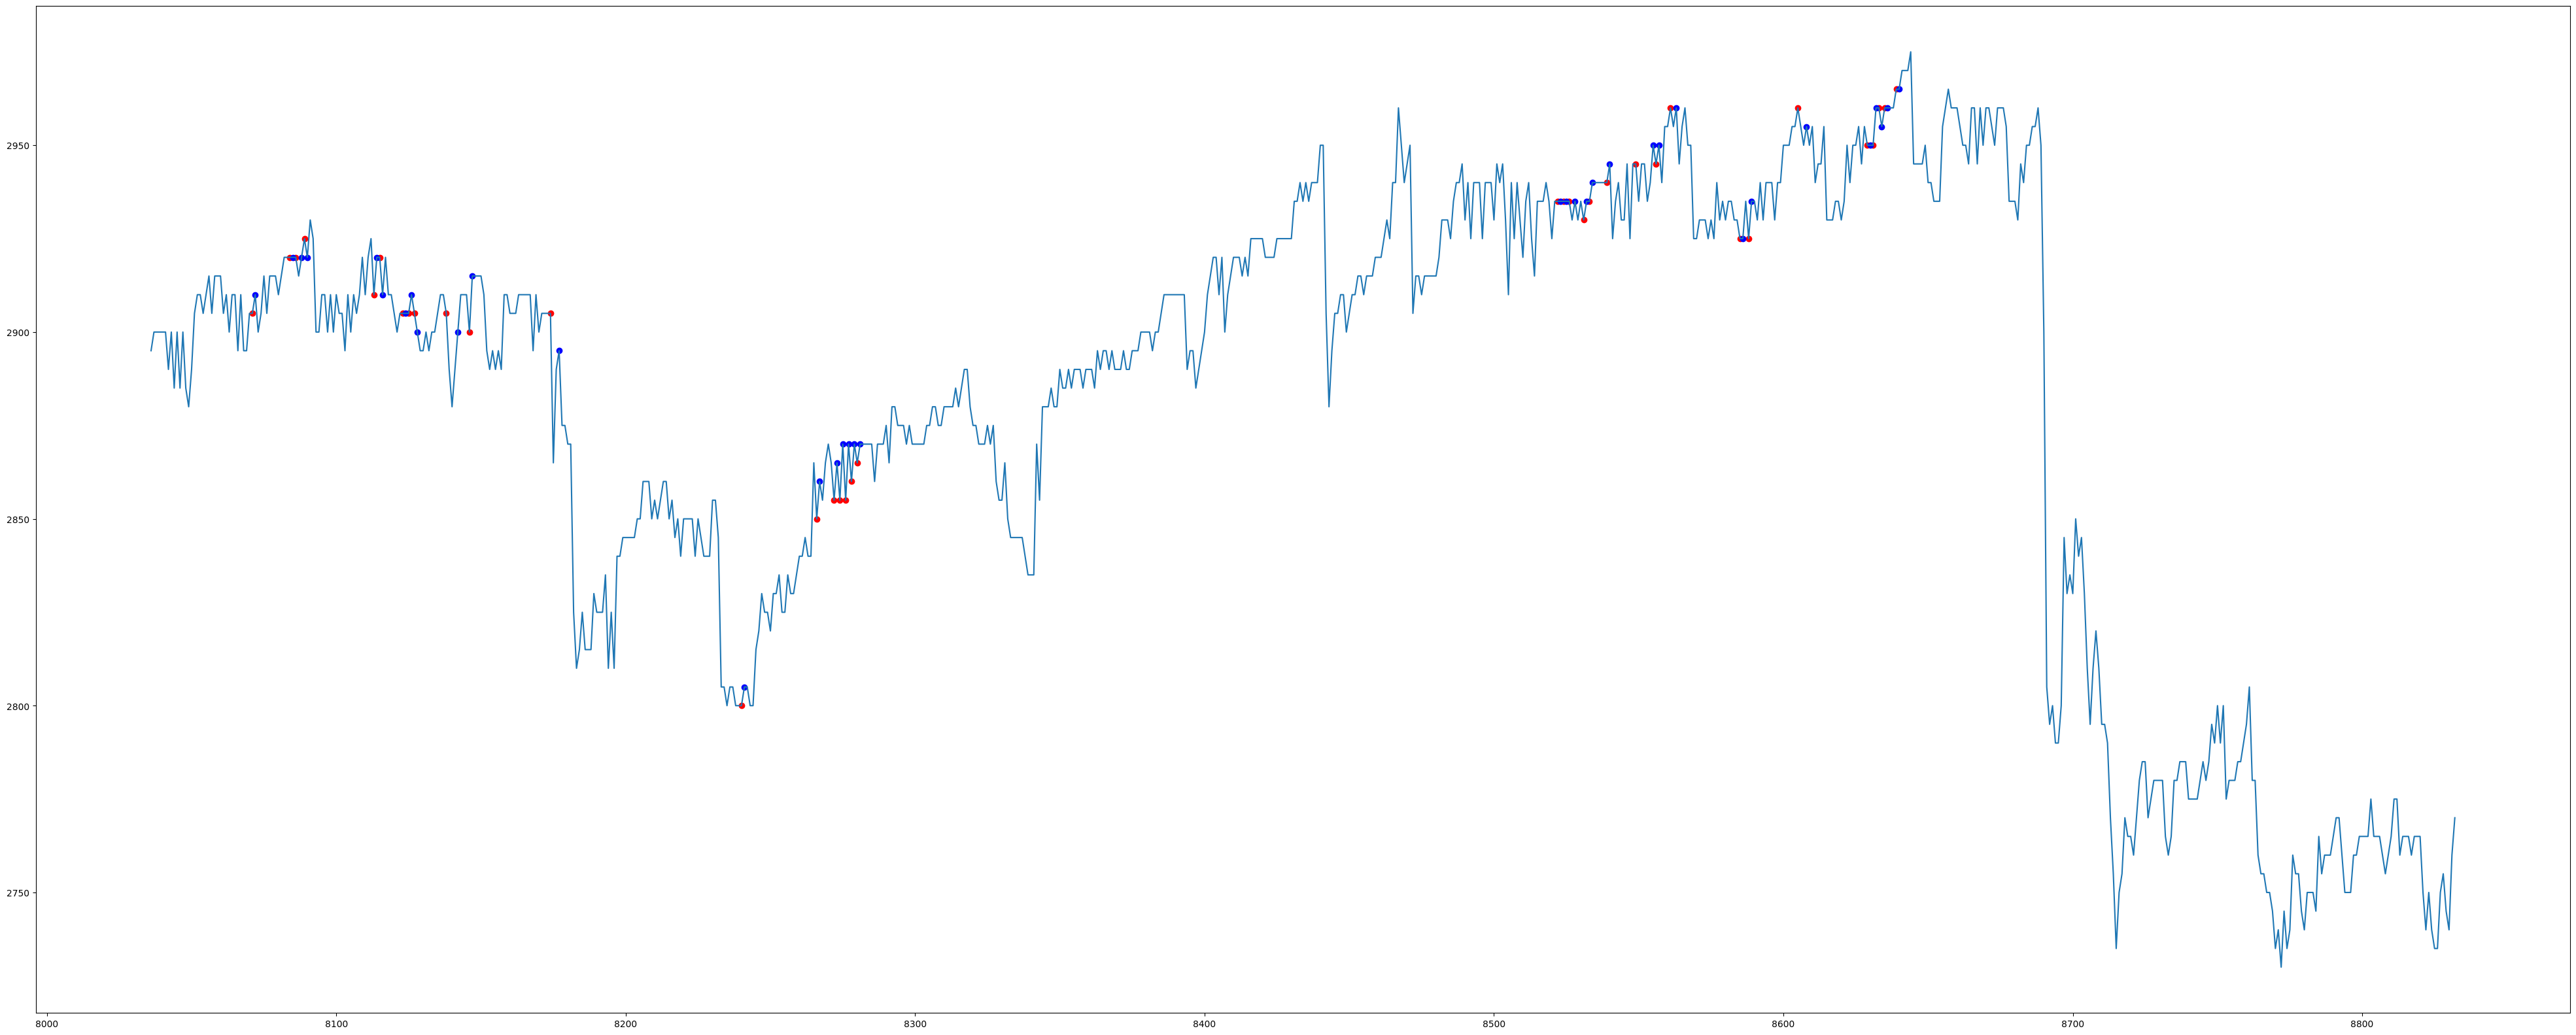

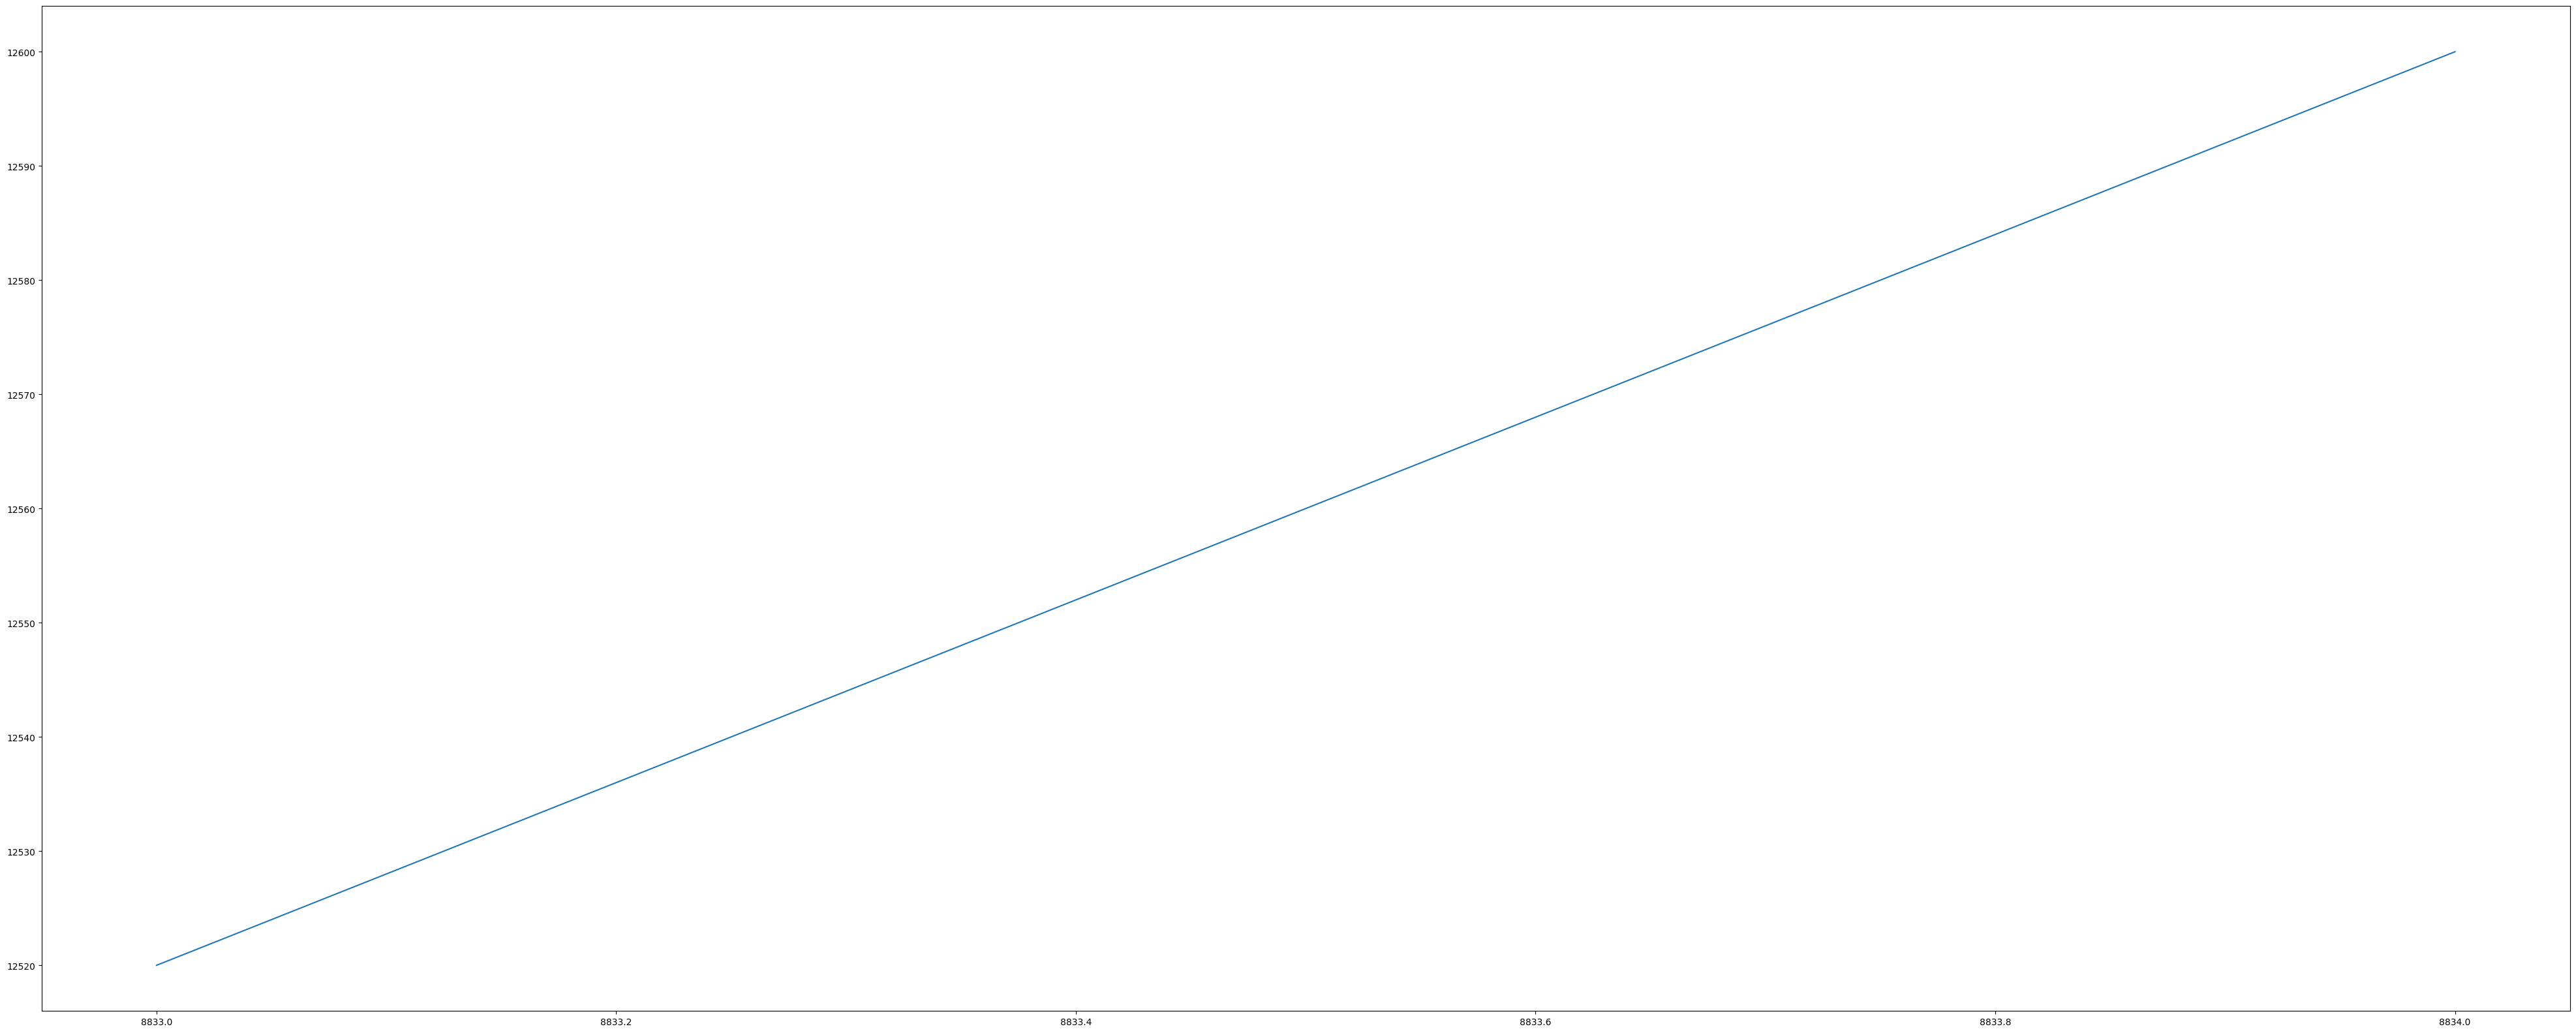

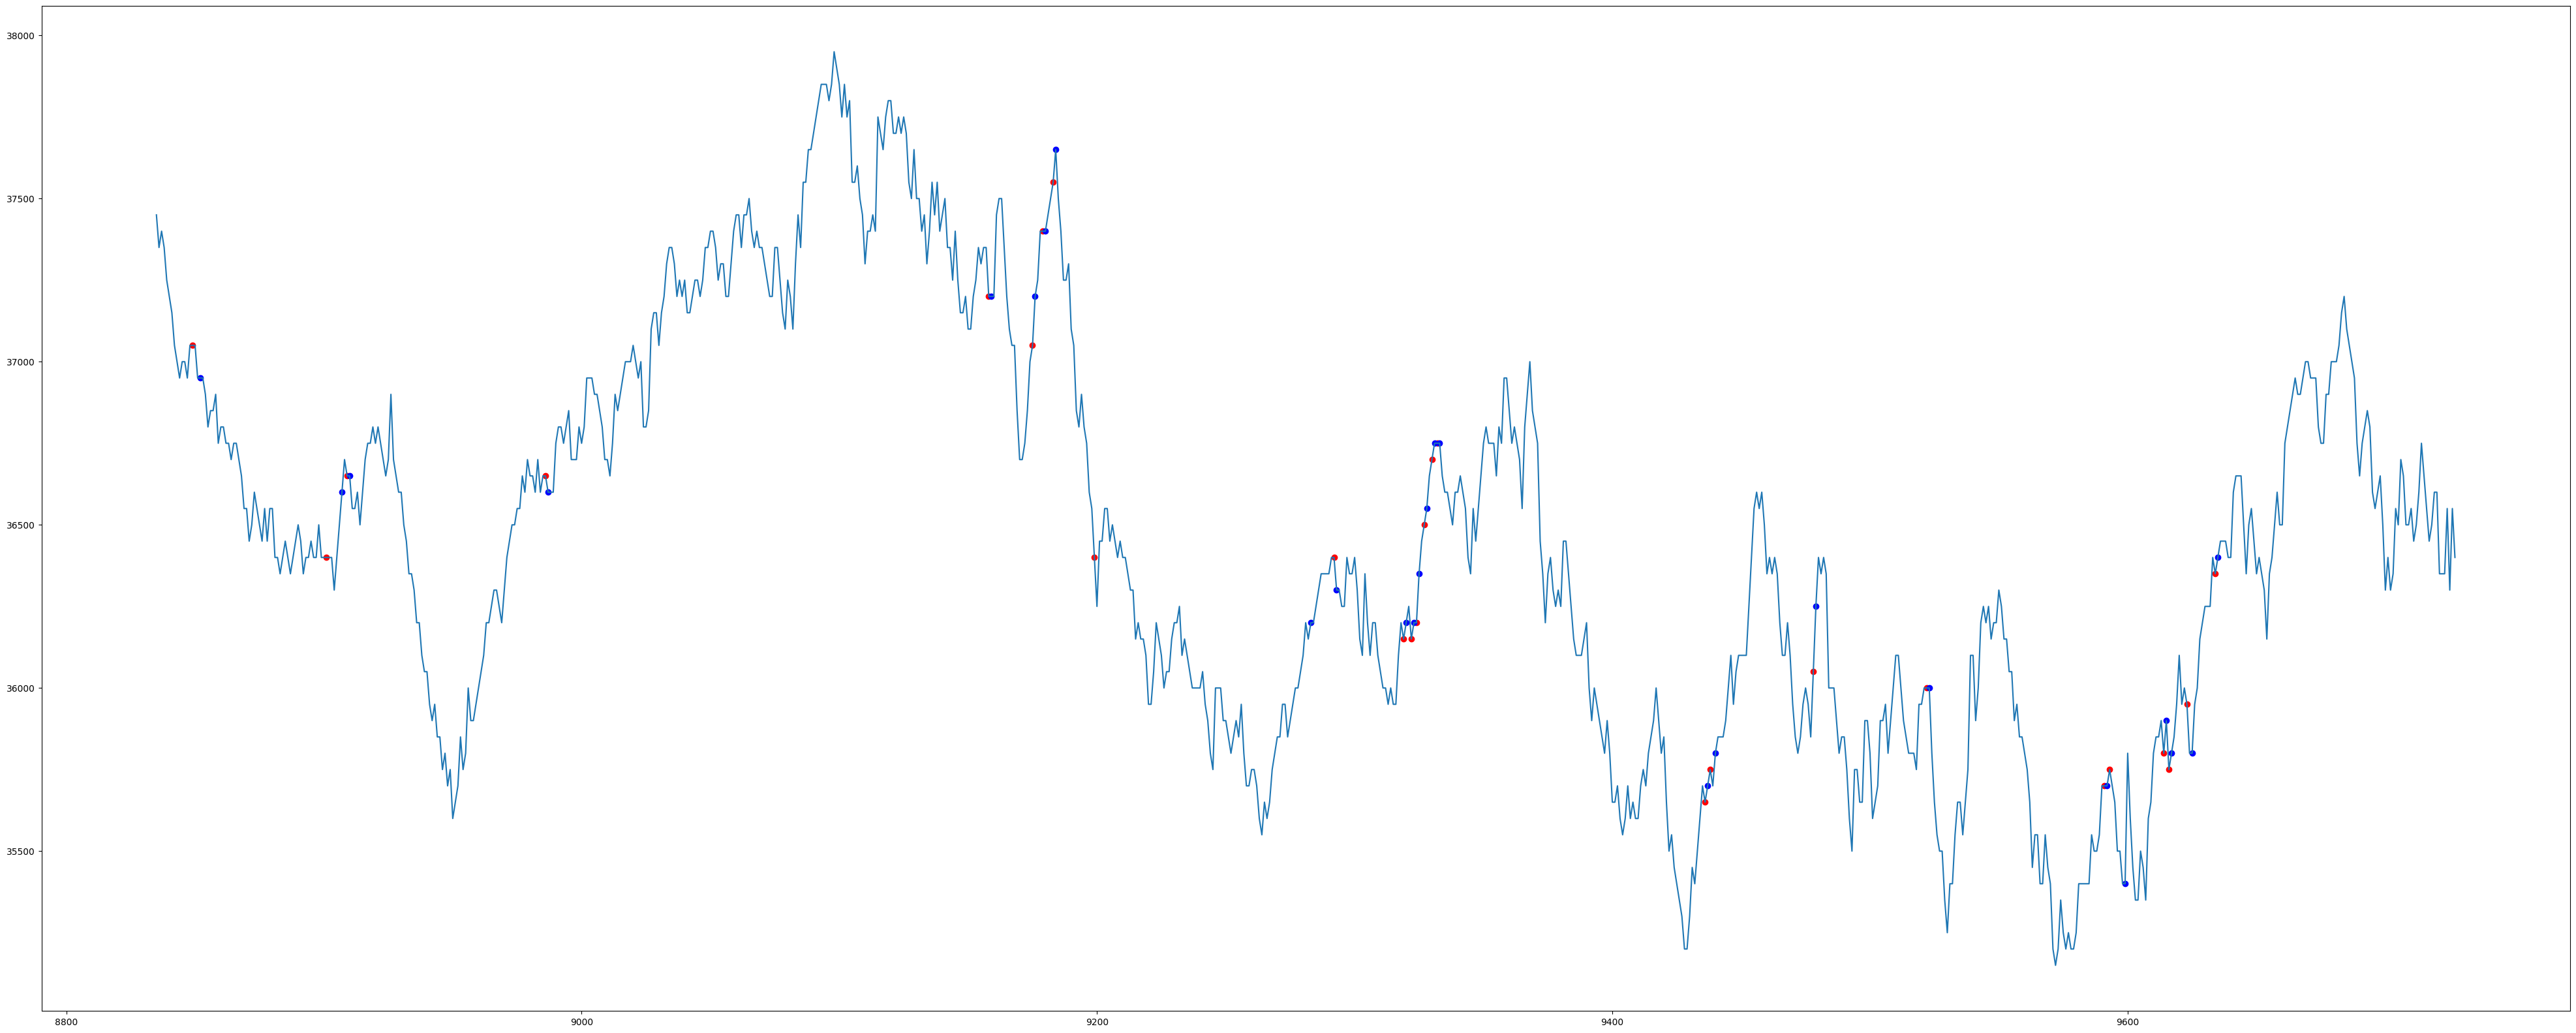

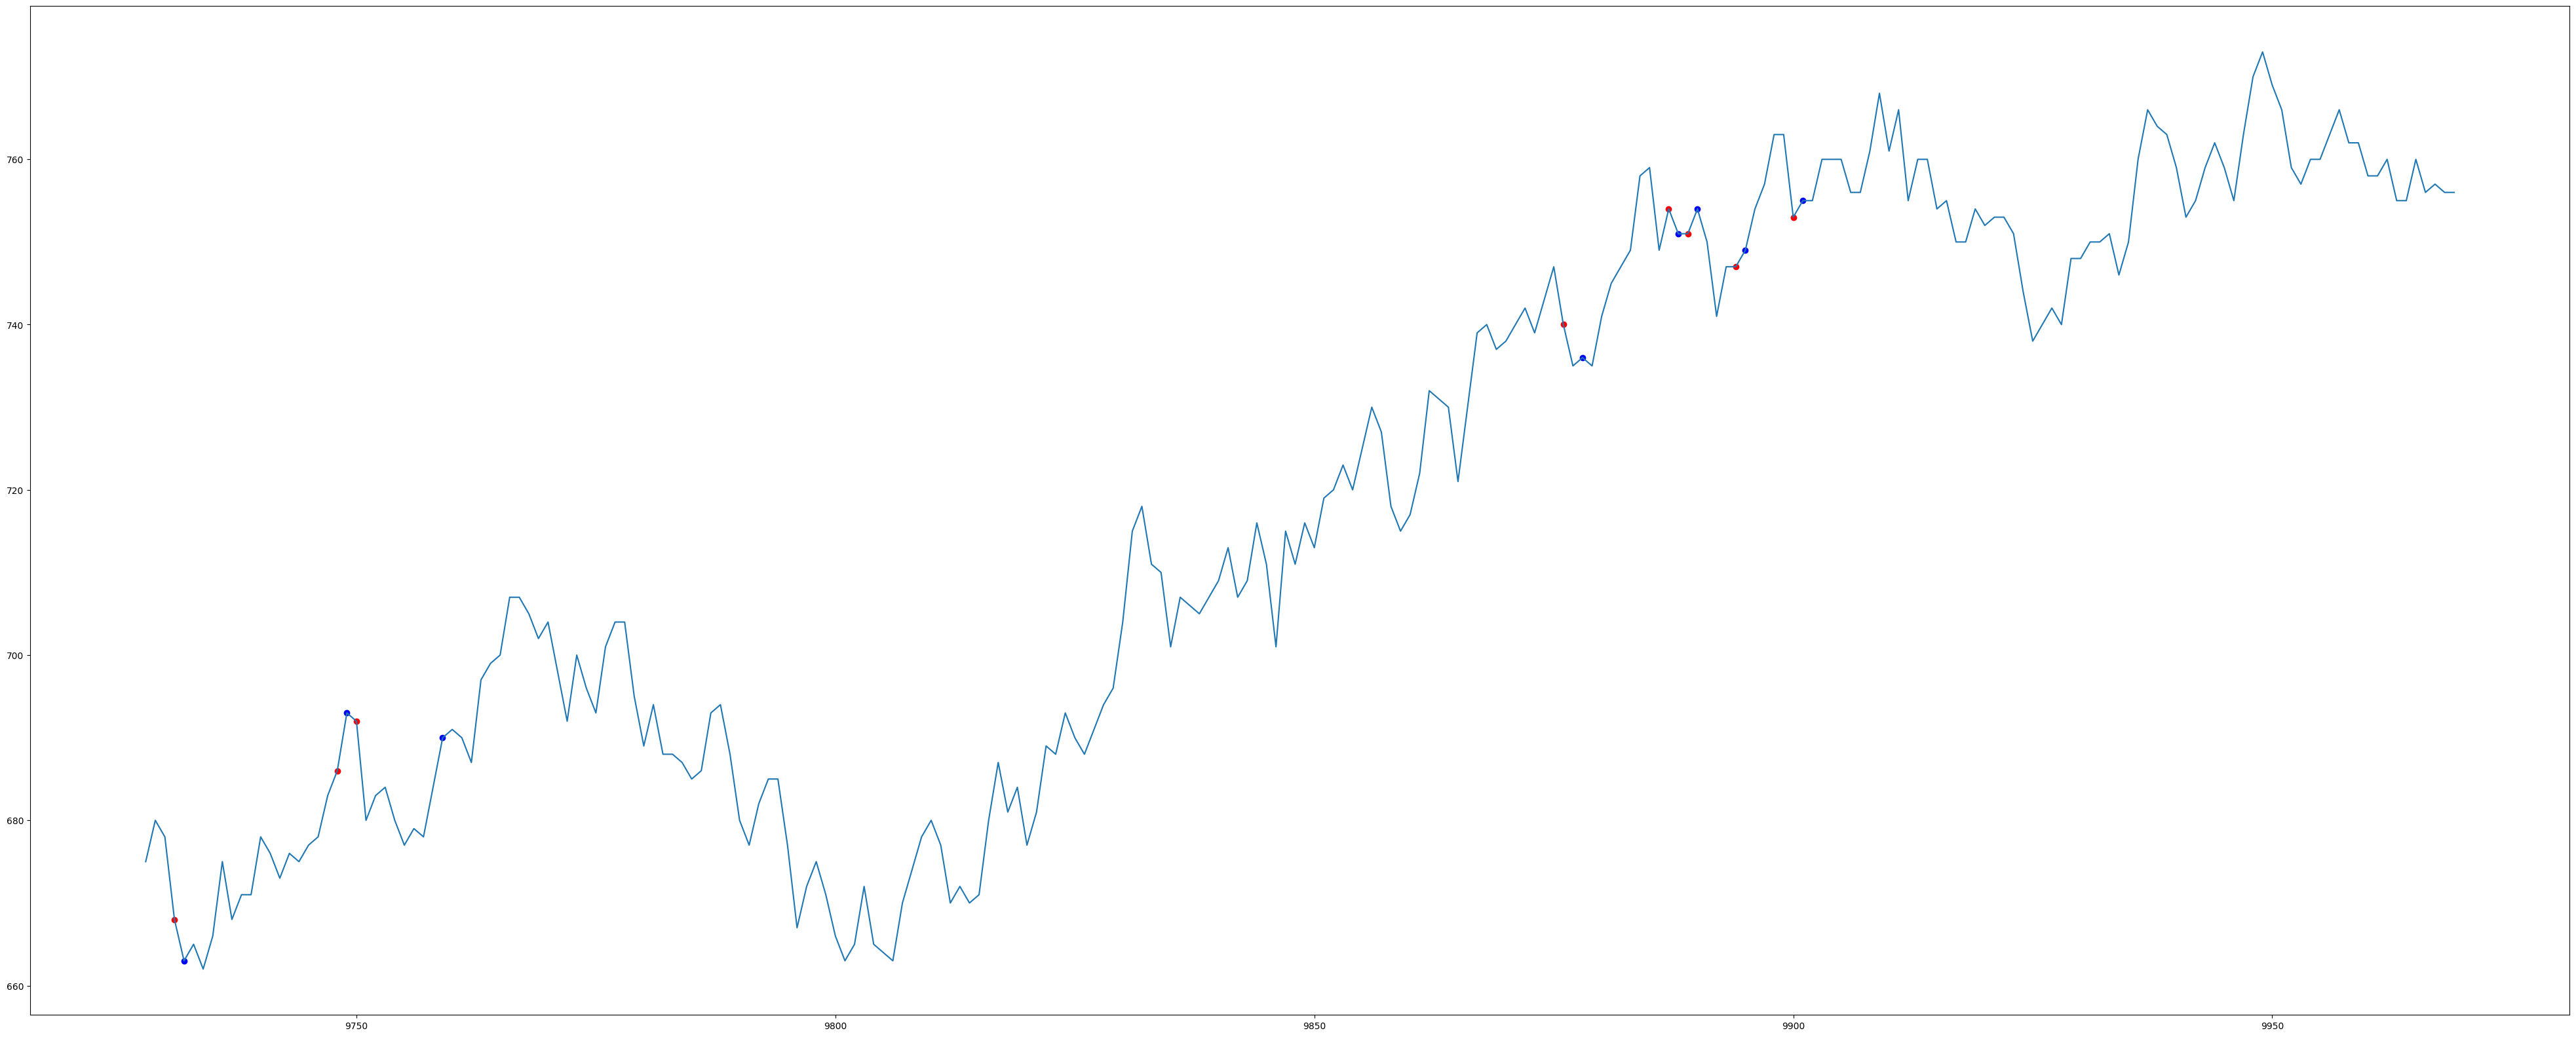

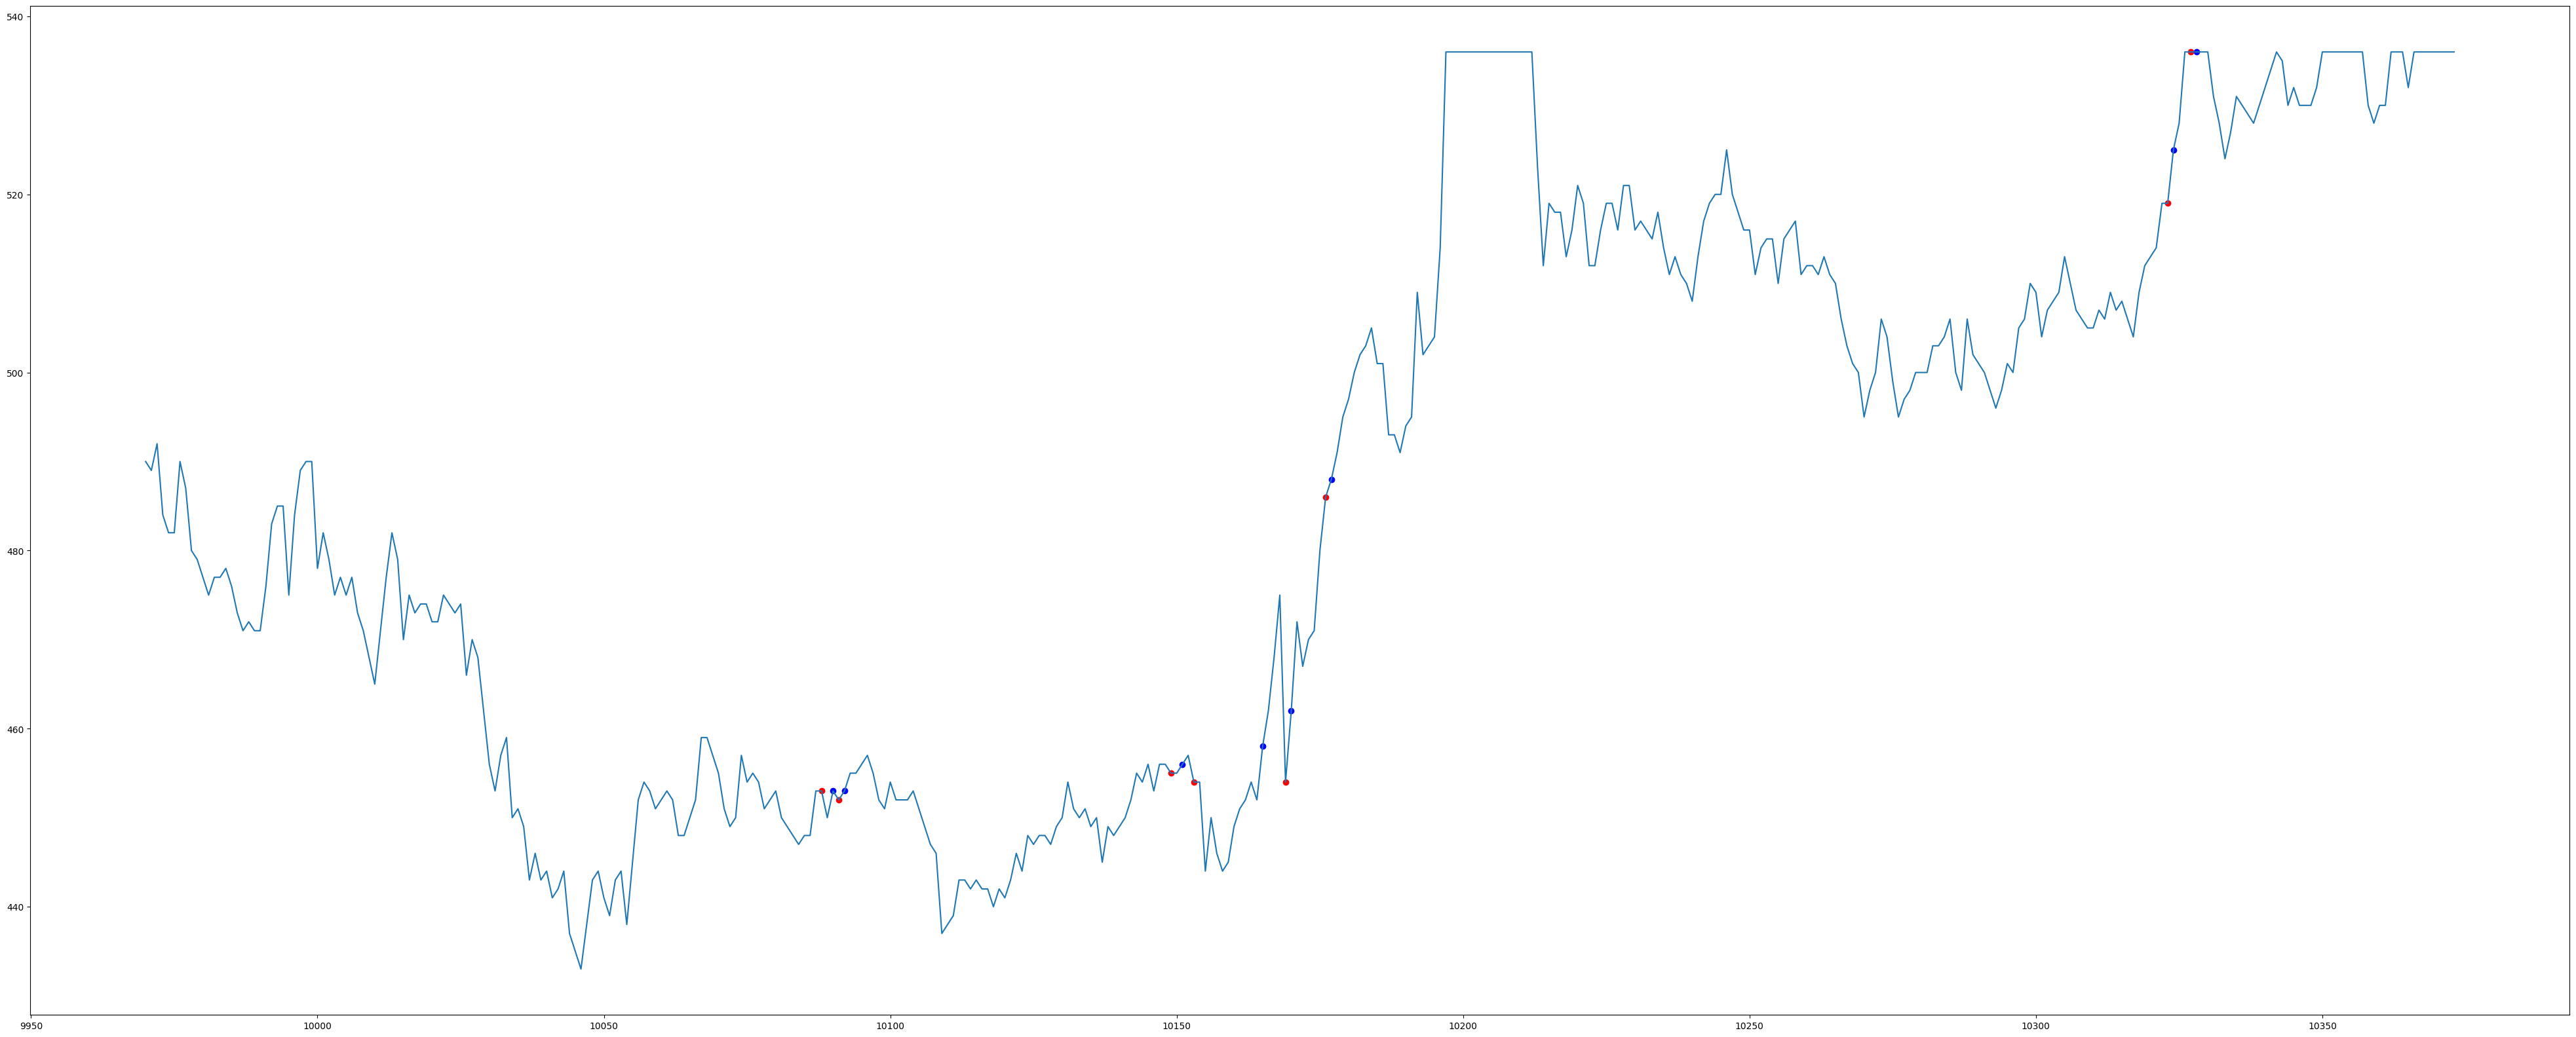

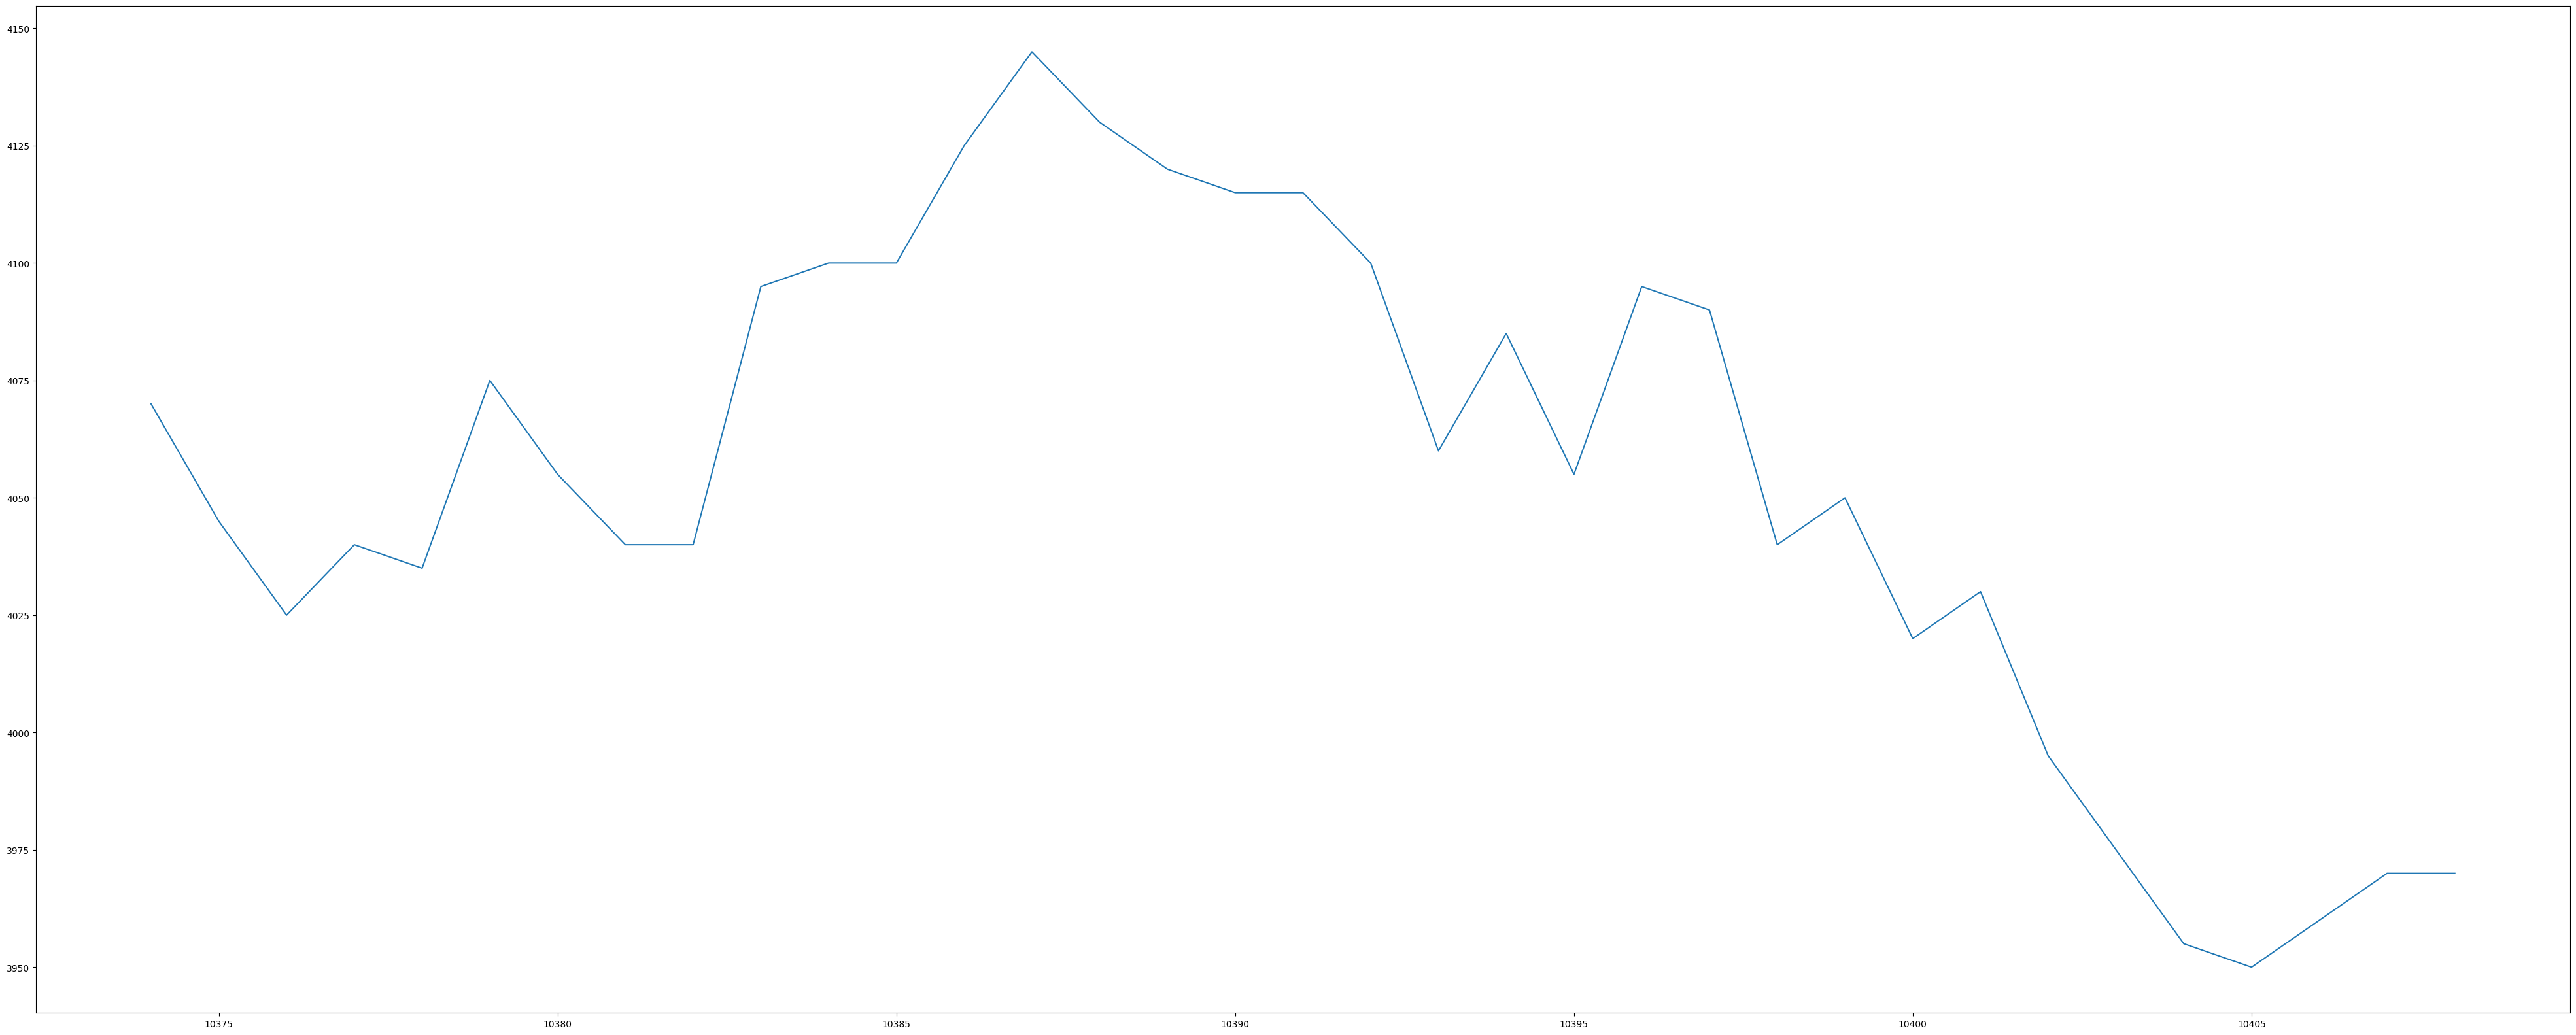

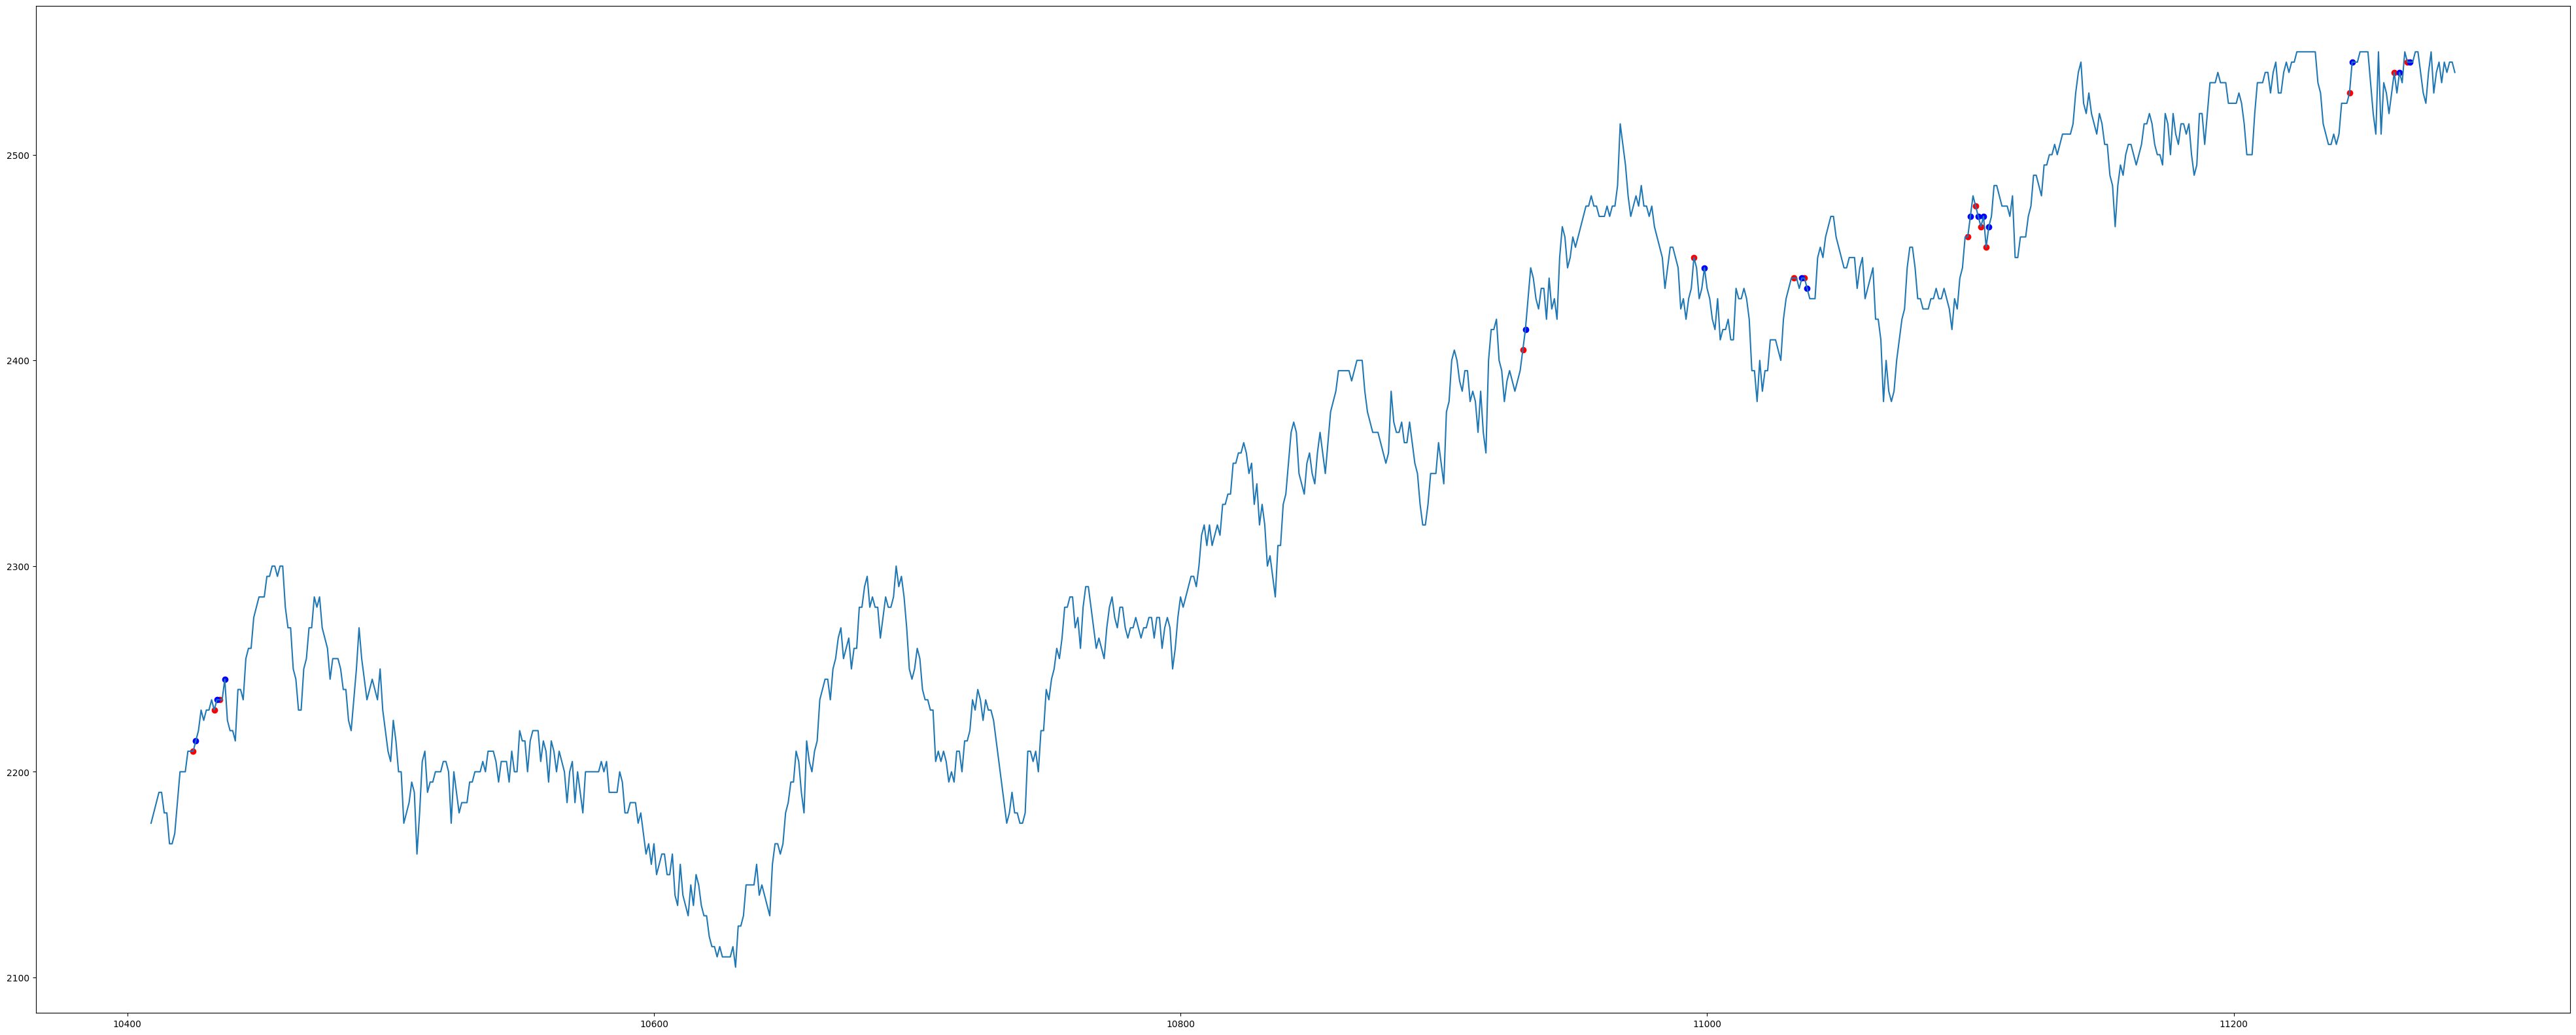

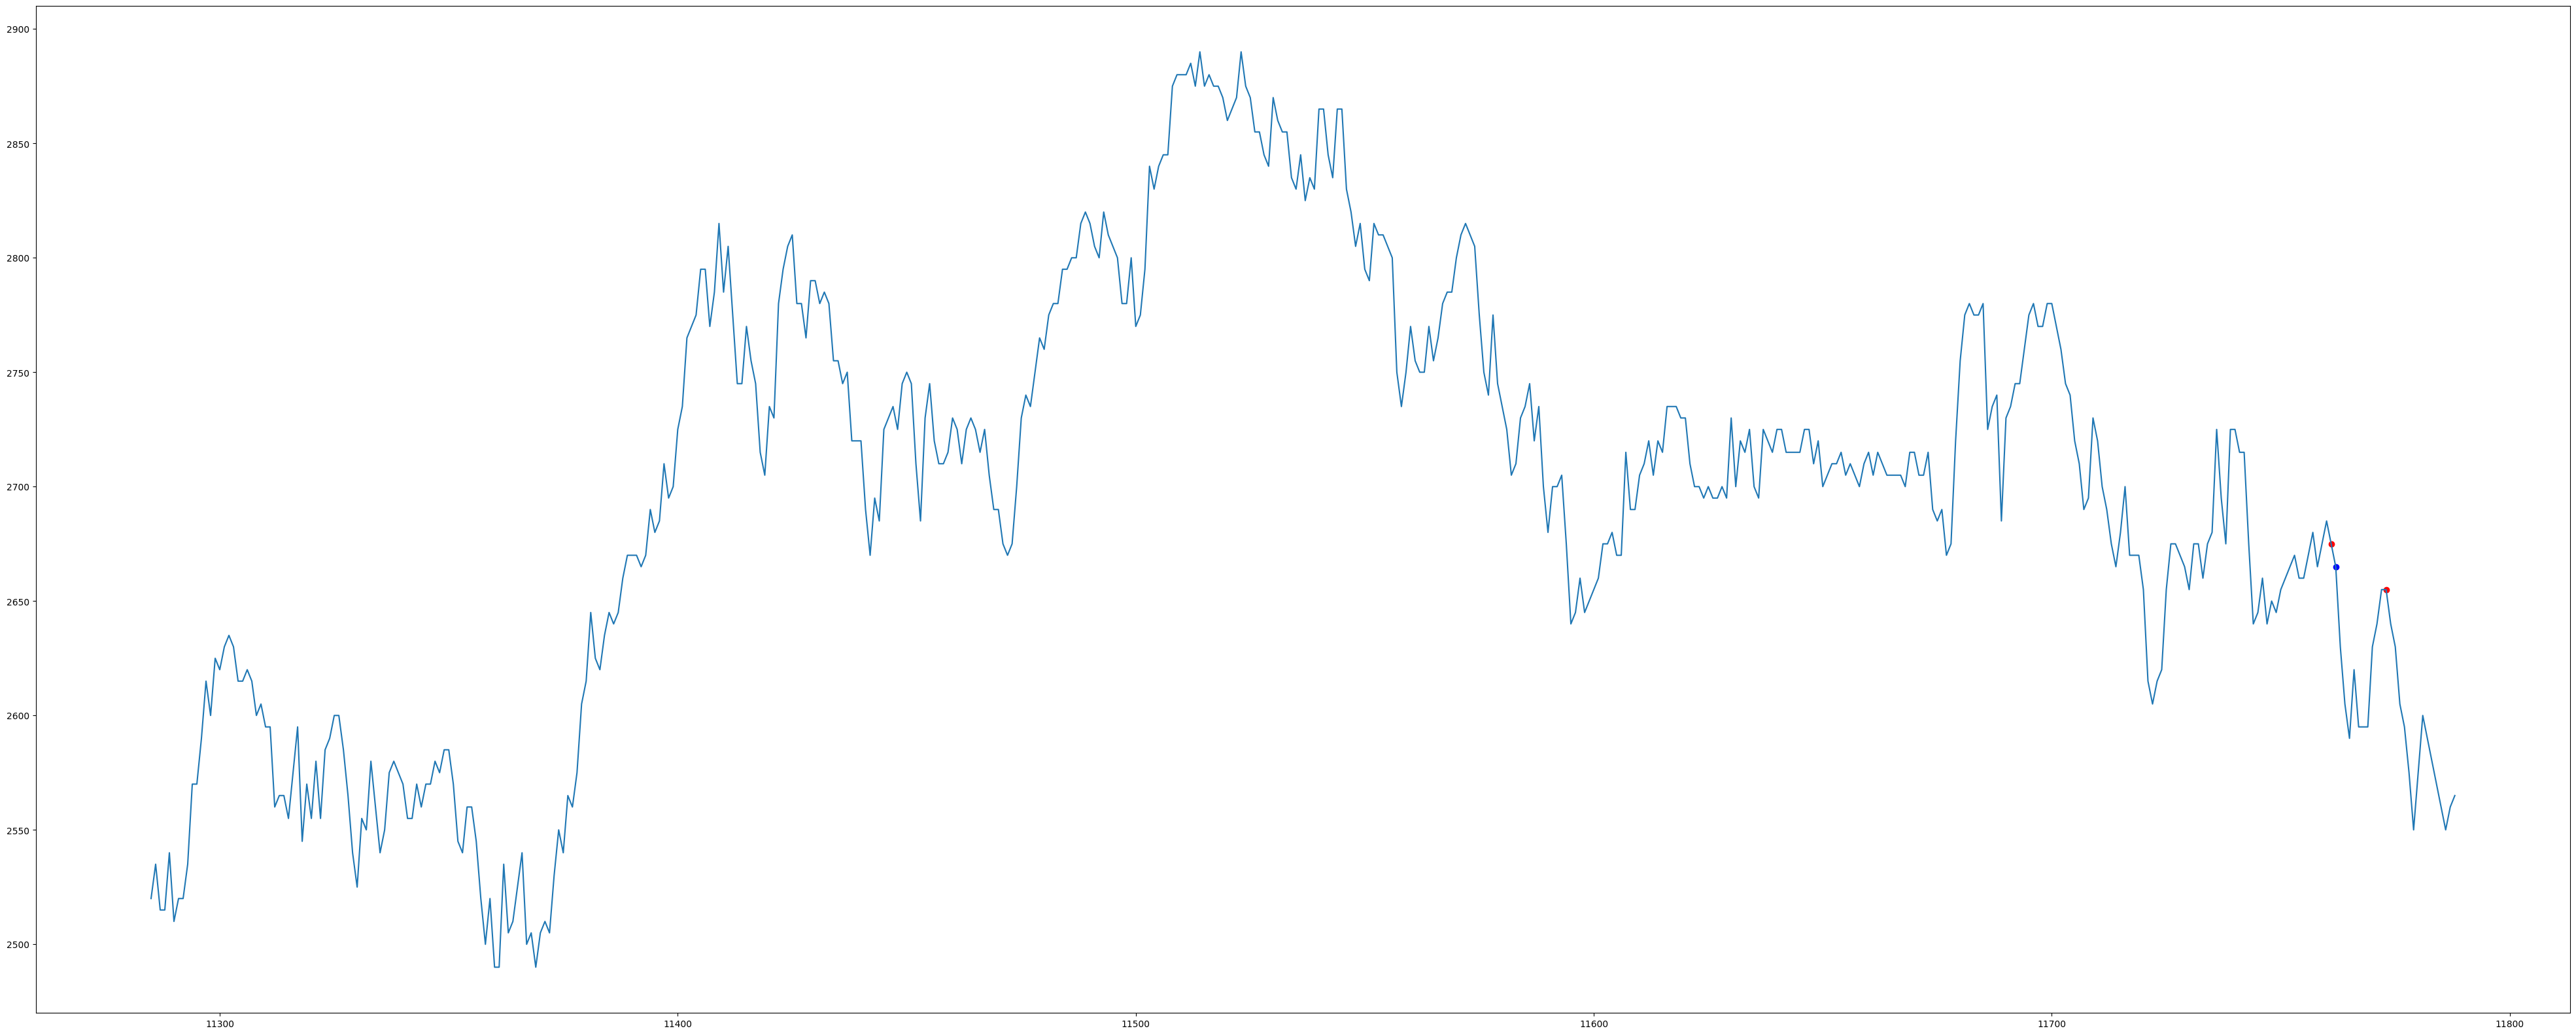

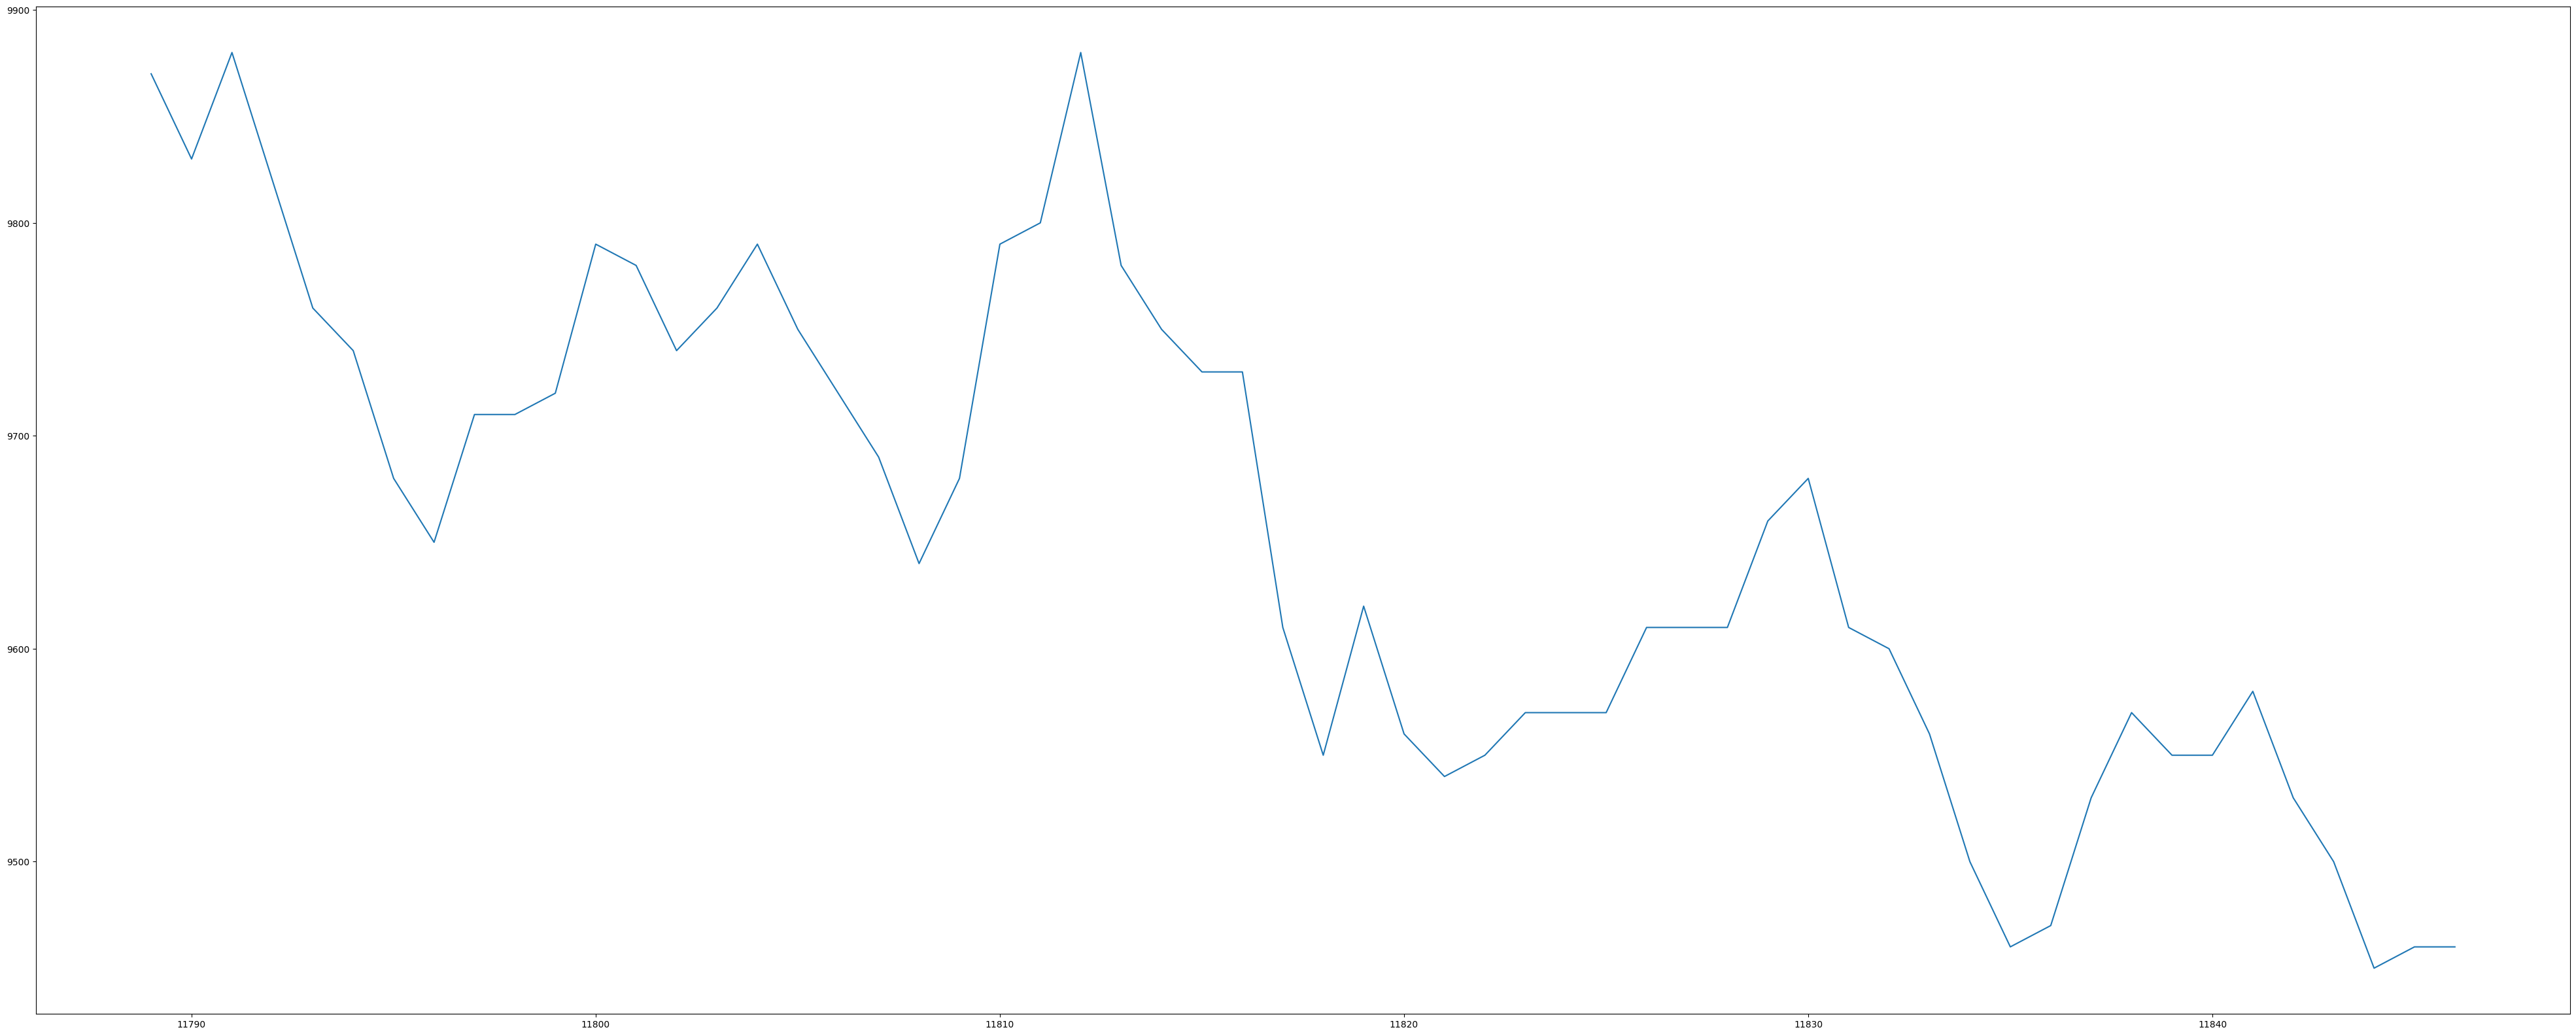

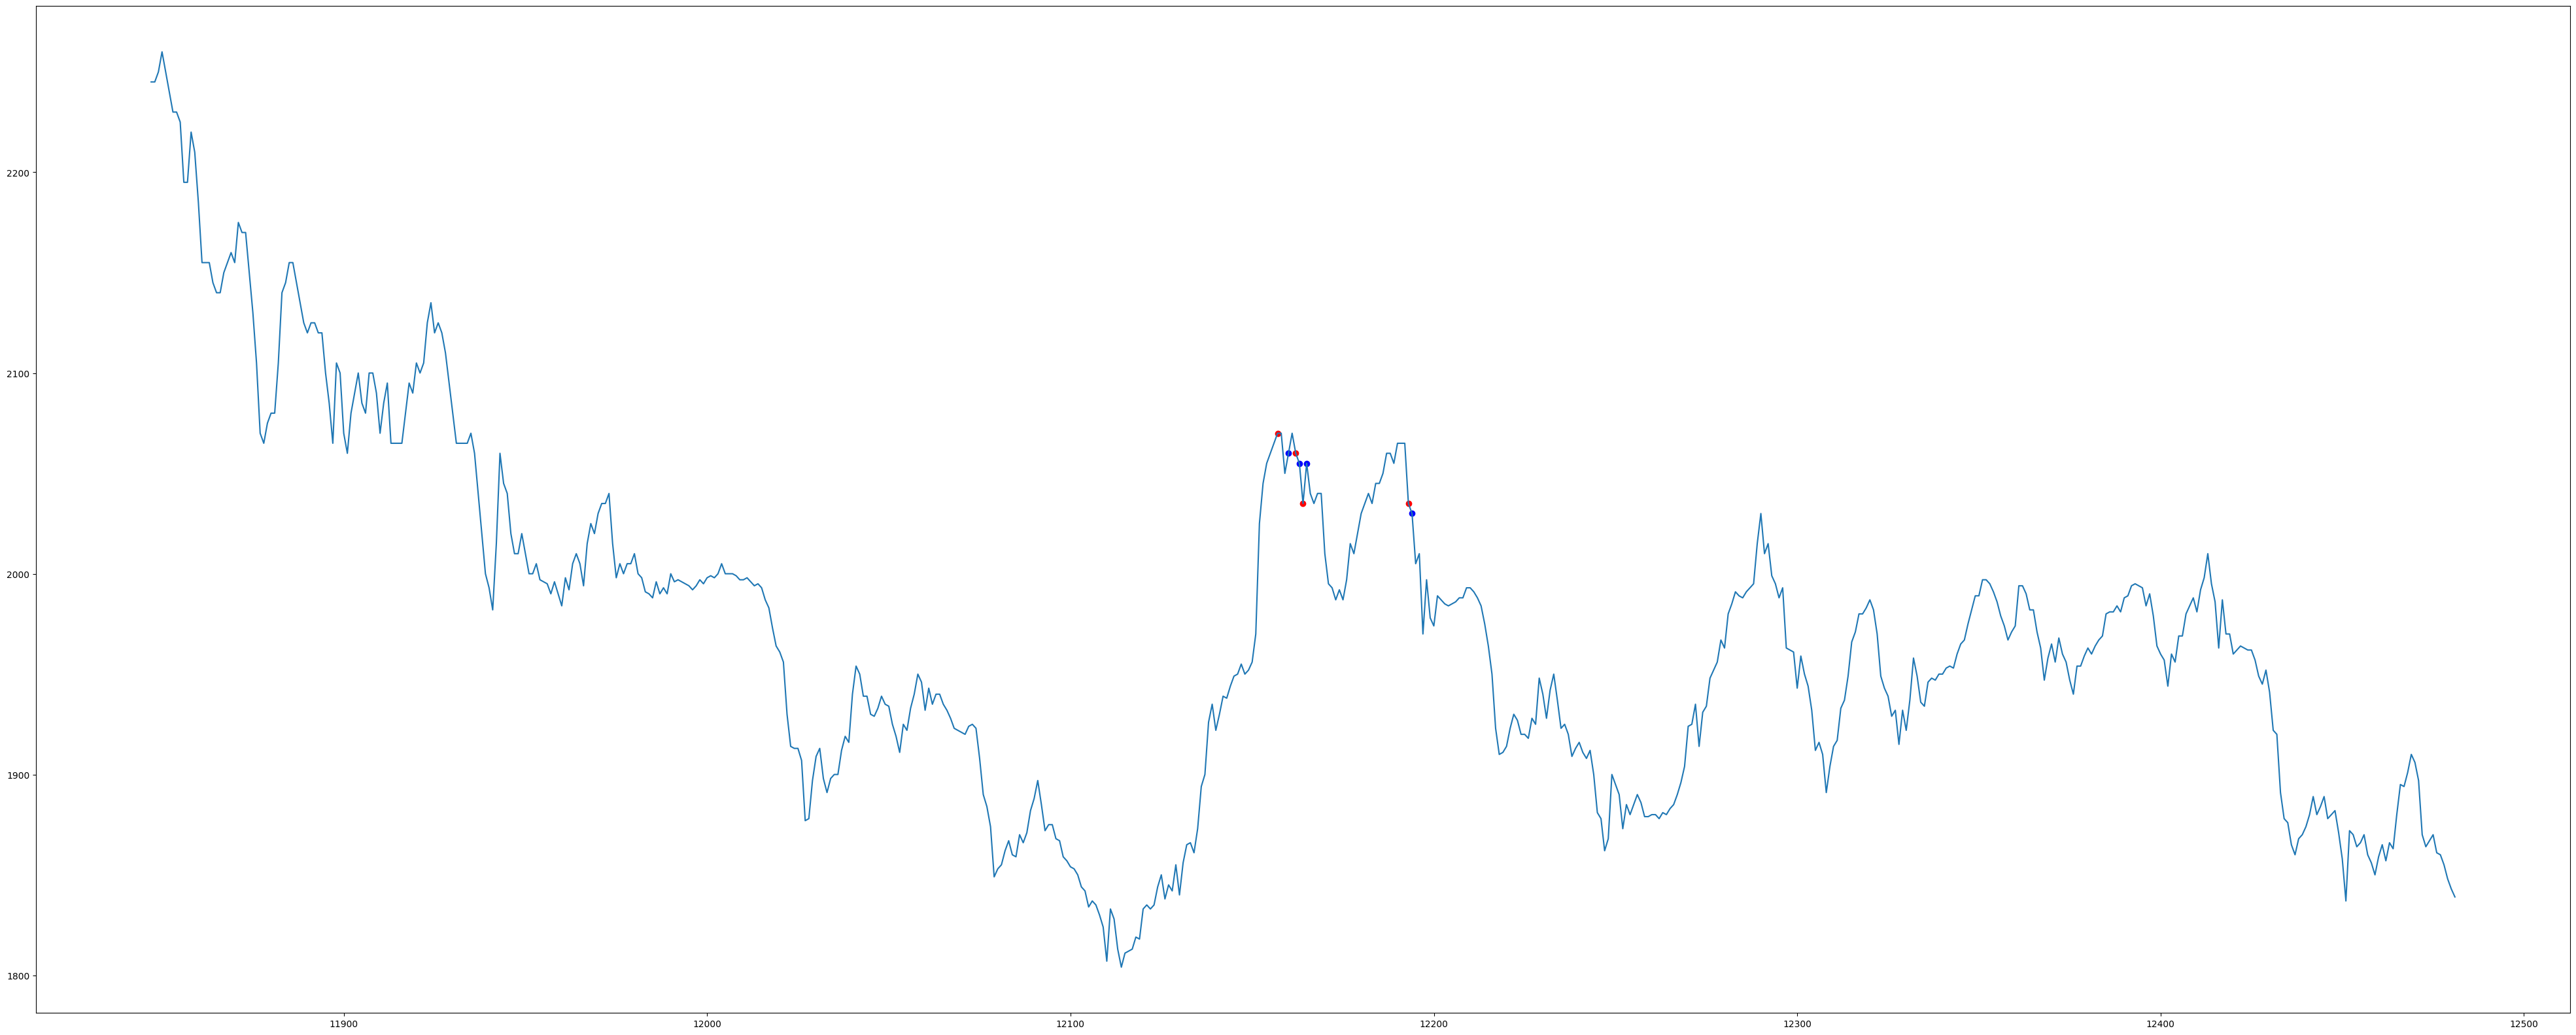

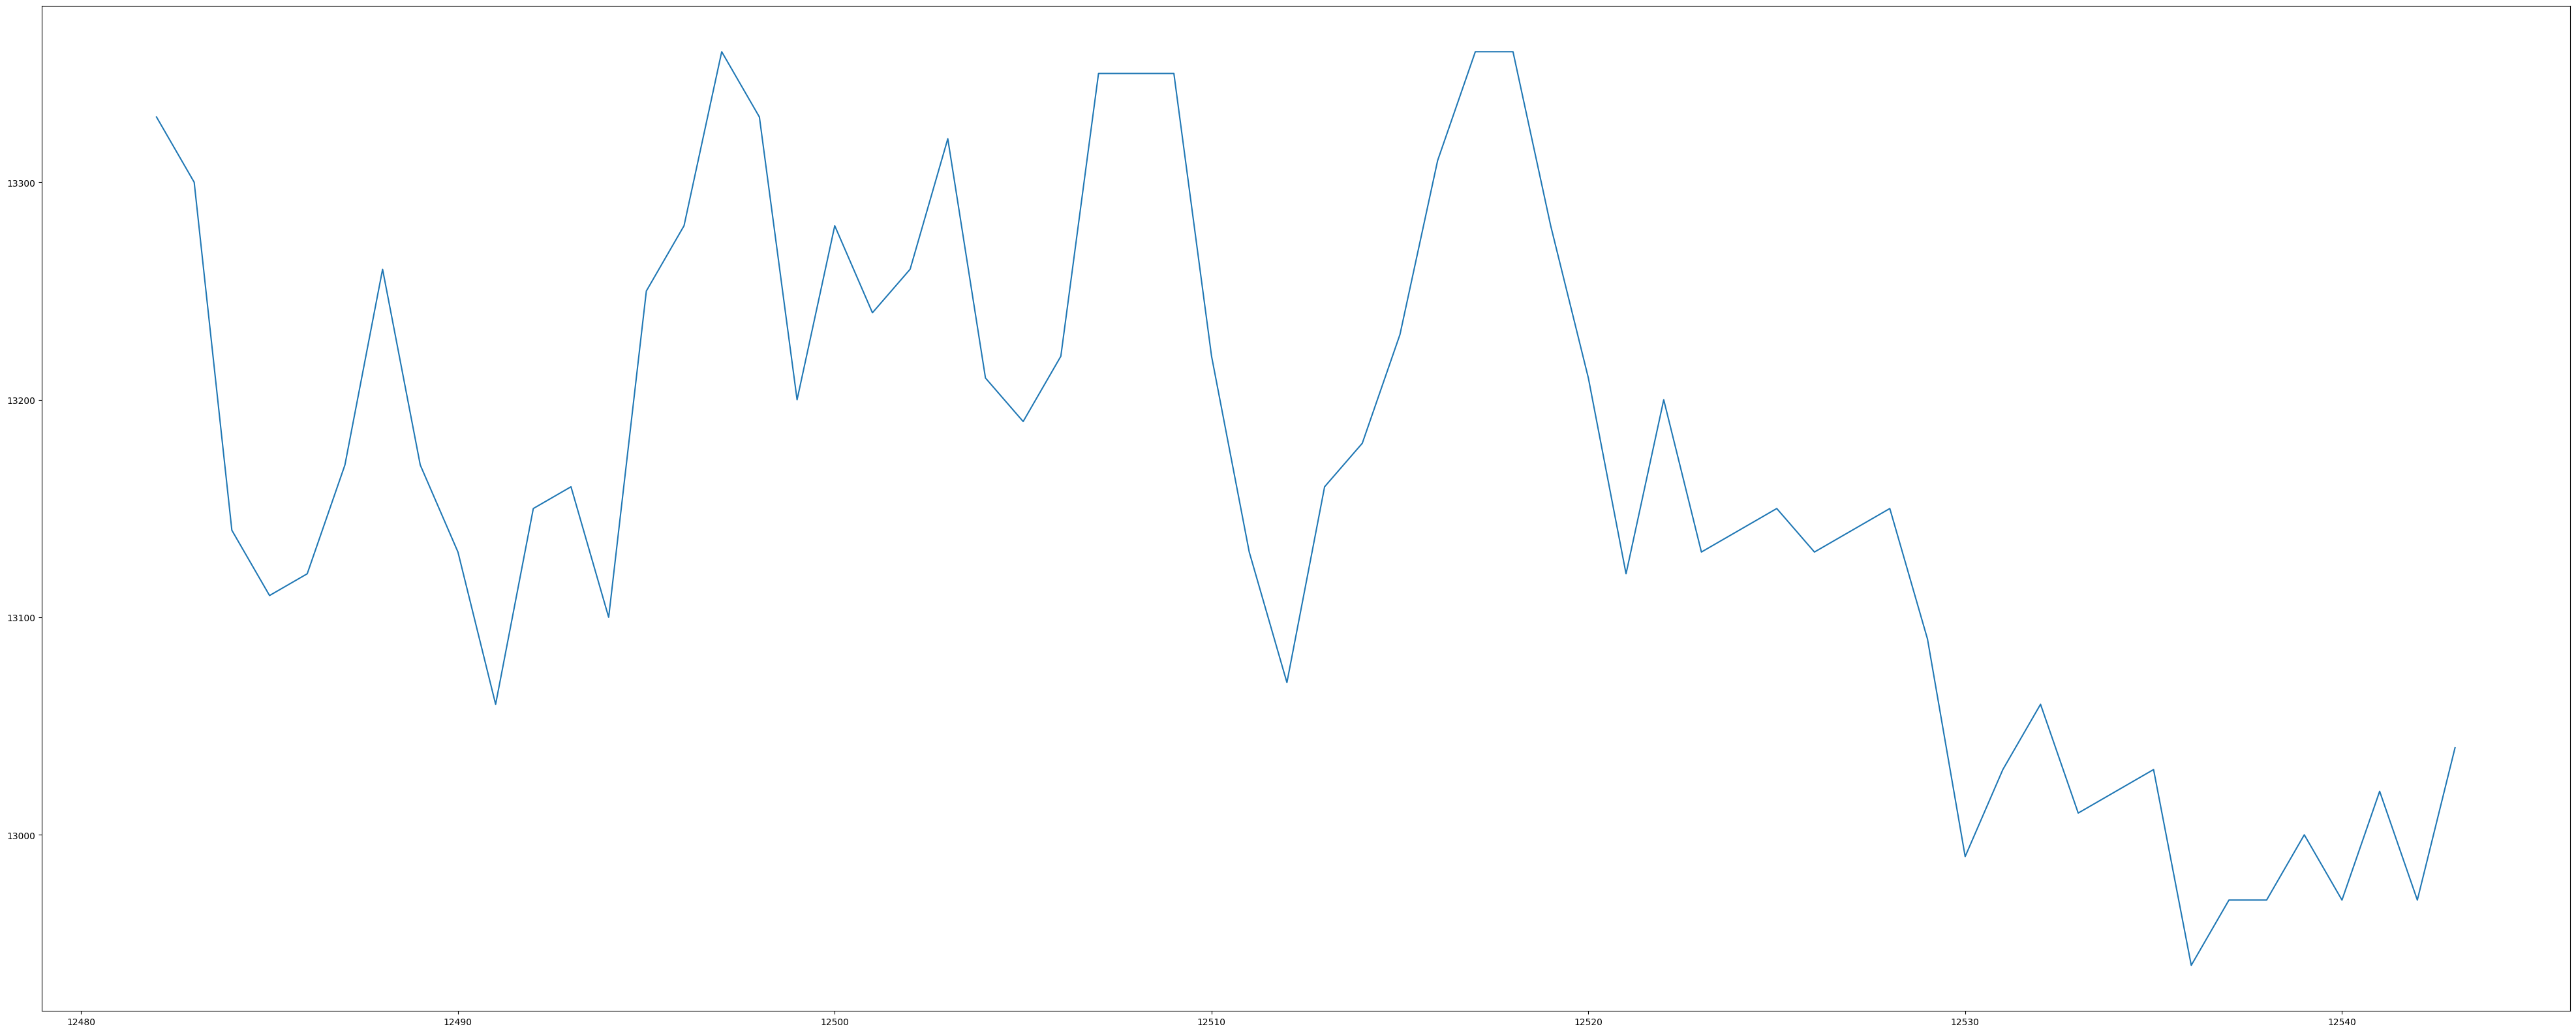

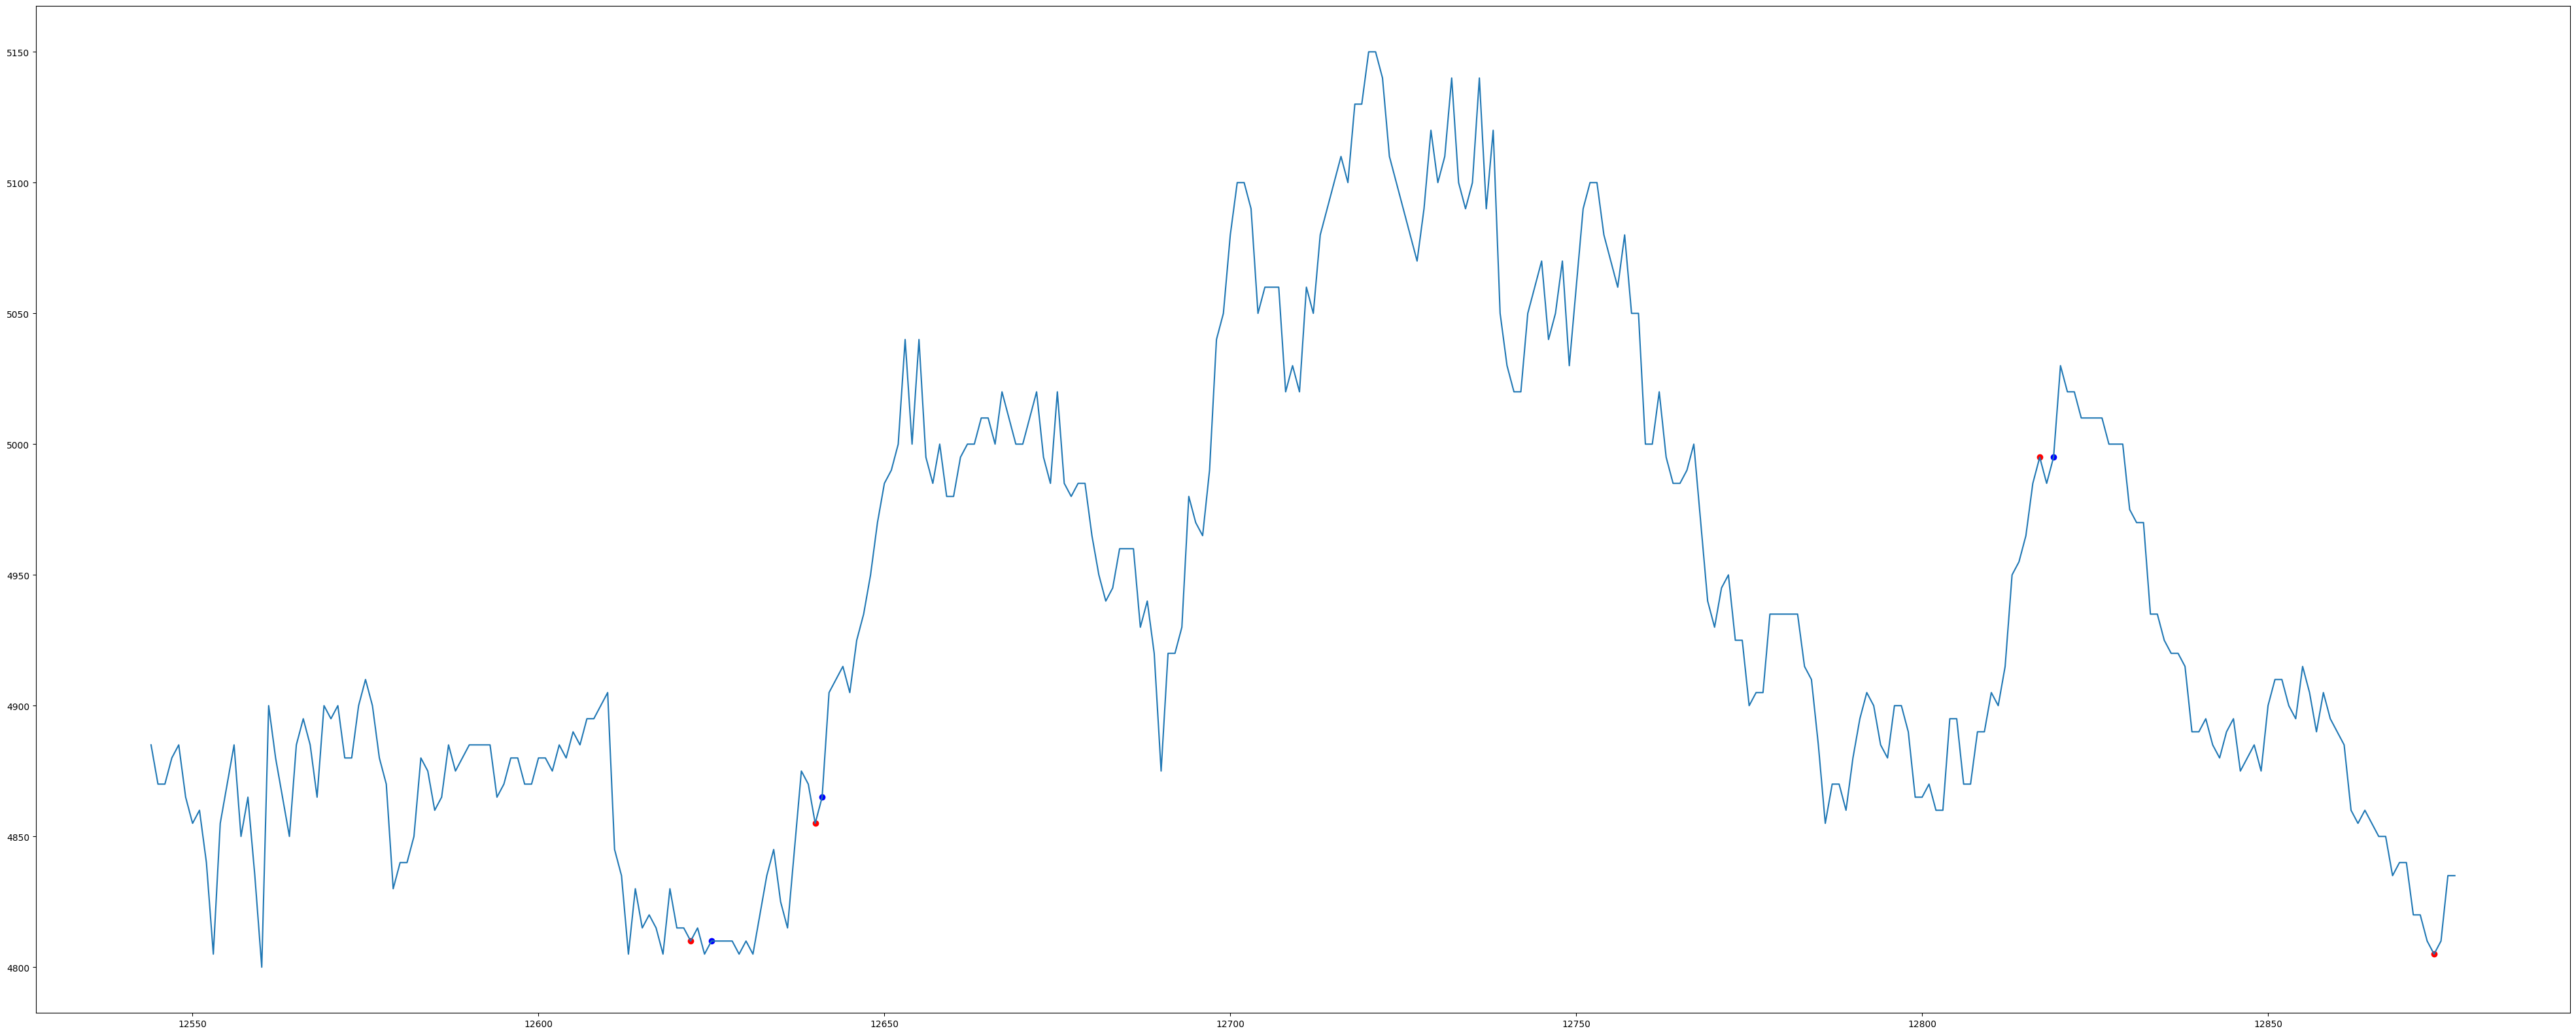

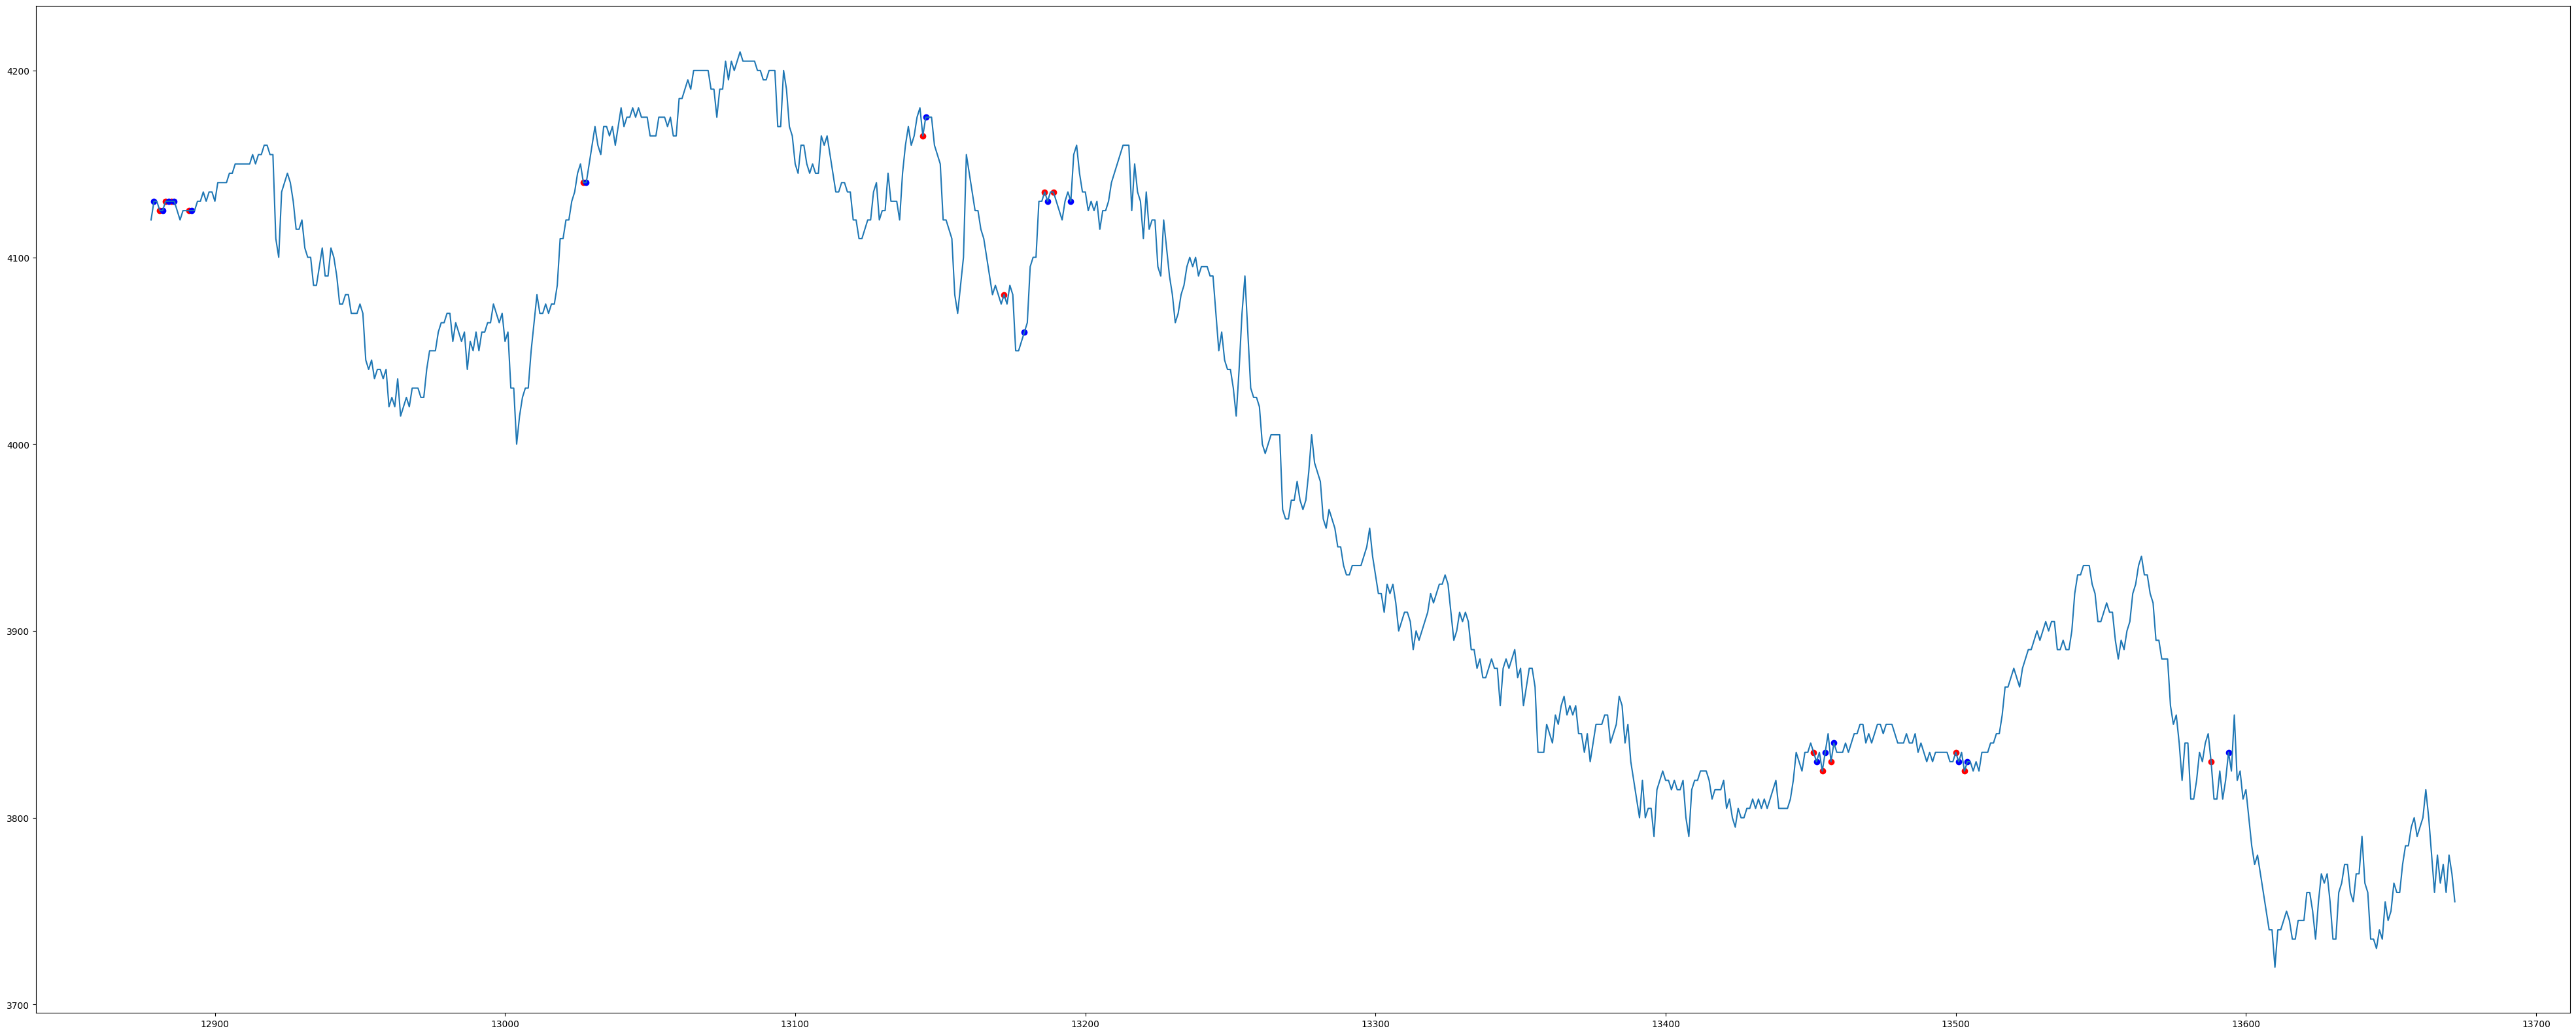

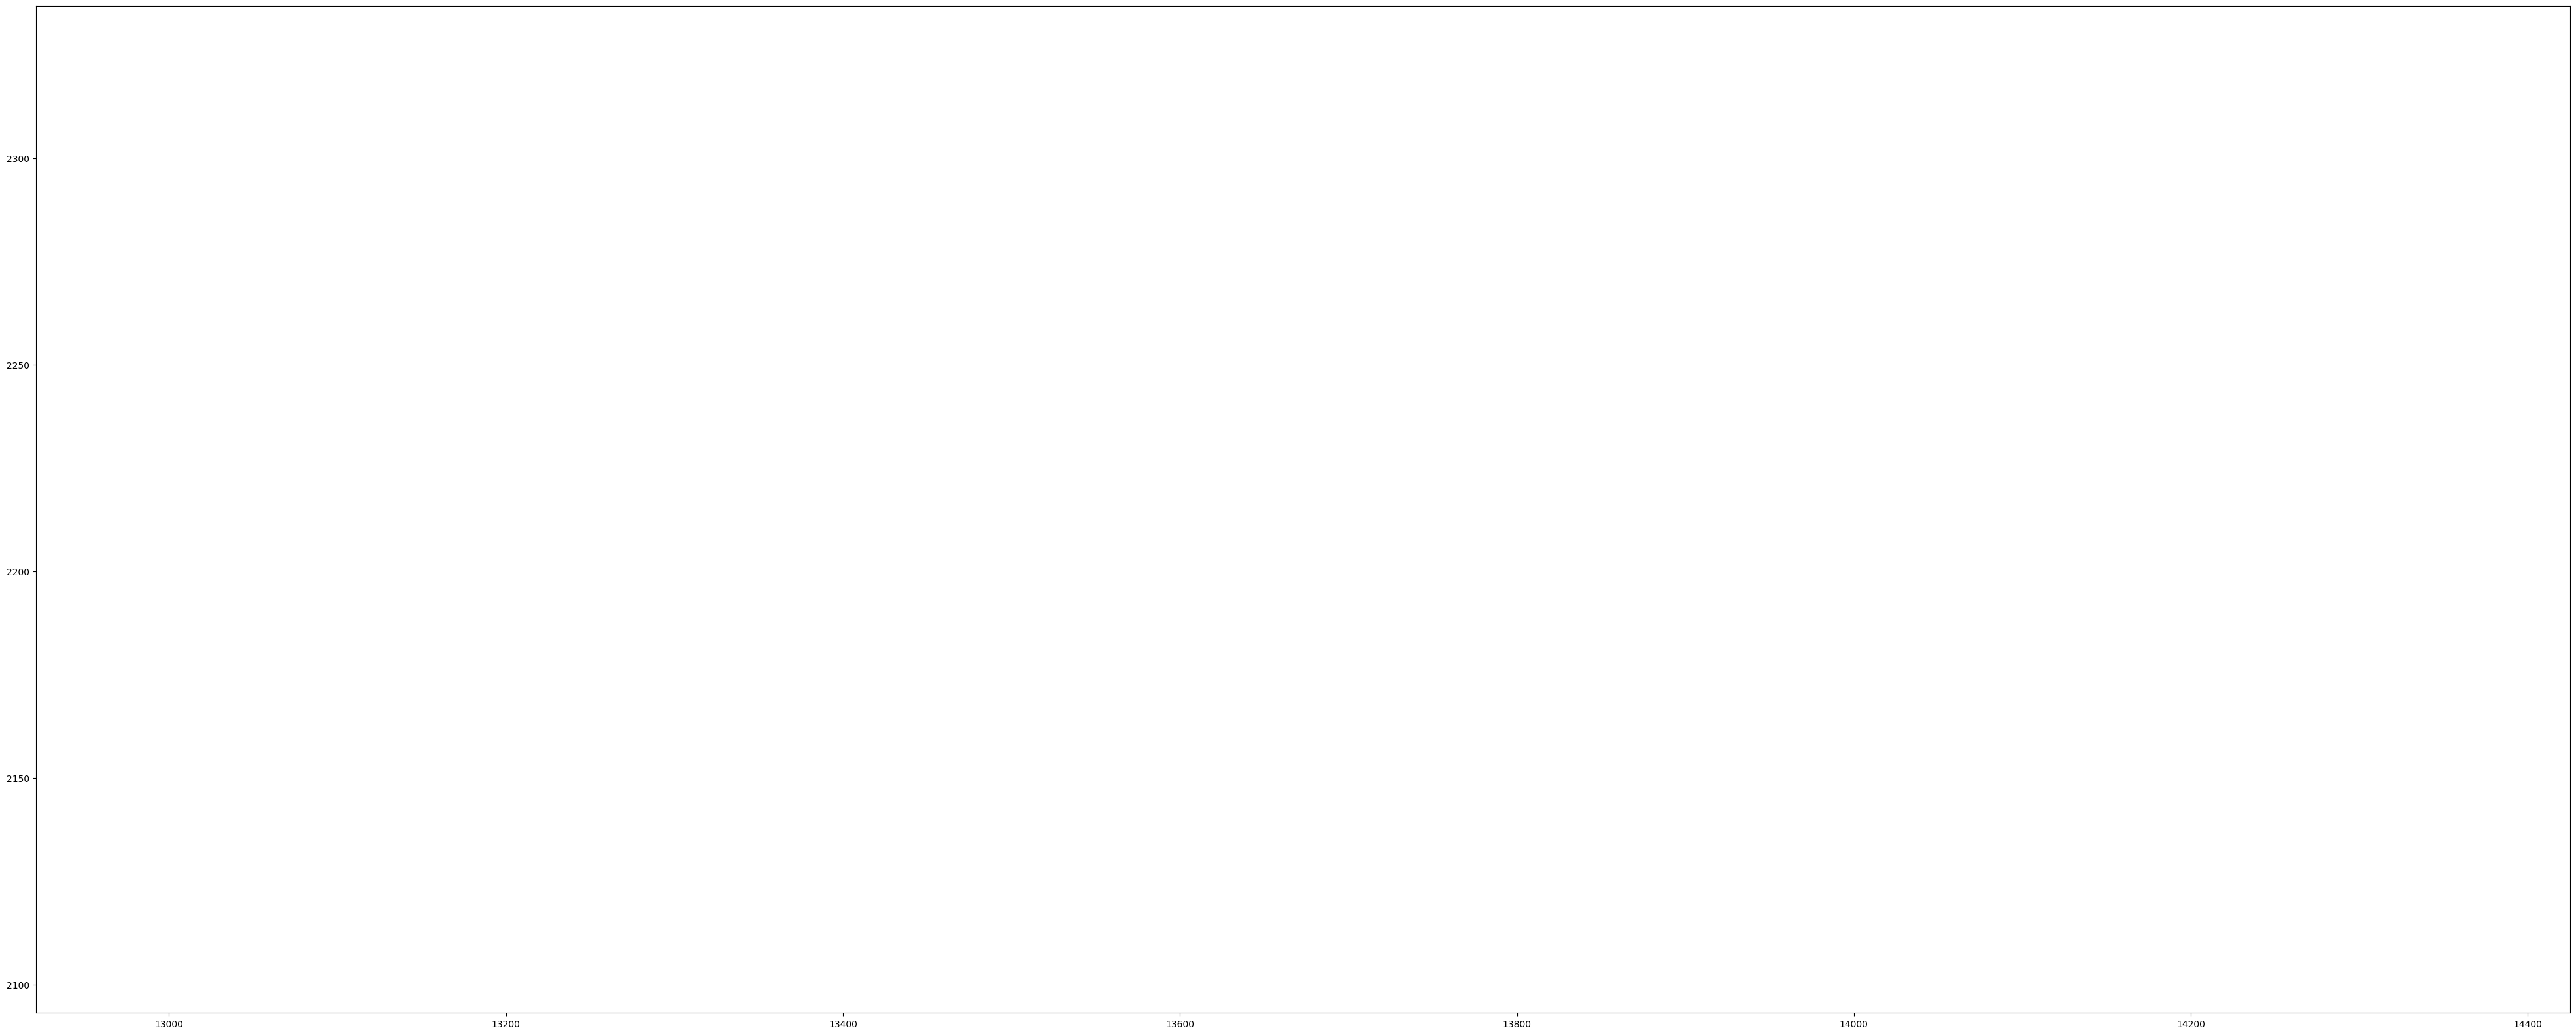

In [69]:
dummy = []
price_lst_tensor = torch.tensor(price_lst)

for i in range(len(next_idx) + 1):
    slice_start = next_idx[i-1] if i != 0 else 0
    slice_end = next_idx[i] if len(next_idx) != i else len(price_lst_tensor)

    dummy.append((list(range(slice_start, slice_end)), price_lst[slice_start:slice_end]))

bought_dummy = []
for i in range(len(next_idx) + 1):
    slice_start = next_idx[i-1] if i != 0 else 0
    slice_end = next_idx[i] if len(next_idx) != i else torch.inf

    bought_dummy.append([k for k in bought_idx if slice_start <= k <= slice_end])

sold_dummy = []
for i in range(len(next_idx) + 1):
    slice_start = next_idx[i-1] if i != 0 else 0
    slice_end = next_idx[i] if len(next_idx) != i else torch.inf

    sold_dummy.append([k for k in sold_idx if slice_start <= k <= slice_end])

for d_i in range(len(dummy)):
    fig, ax = plt.subplots(figsize=(50, 20))
    ax.plot(*dummy[d_i])
    ax.scatter(bought_dummy[d_i], price_lst_tensor[bought_dummy[d_i]], c='r')
    ax.scatter(sold_dummy[d_i], price_lst_tensor[sold_dummy[d_i]], c='b')
    

모델 경로

In [65]:
PATH1 = './policy_net.pt'
PATH2 = './target_net.pt'

모델 저장하기

In [66]:
torch.save(policy_net.state_dict(), PATH1)
torch.save(target_net.state_dict(), PATH2)

In [67]:
steps_done

193386

모델 불러오기

In [10]:
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load(PATH1))
policy_net.eval()

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(torch.load(PATH2))
target_net.eval()

RuntimeError: Error(s) in loading state_dict for DQN:
	Missing key(s) in state_dict: "layer1.weight", "layer1.bias", "layer2.weight", "layer2.bias", "layer3.weight", "layer3.bias". 
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2", "linear.weight", "linear.bias". 

In [12]:
policy_net.load_state_dict(torch.load(PATH1))
target_net.load_state_dict(torch.load(PATH2))
target_net.eval()

DQN_LSTM(
  (lstm): LSTM(6, 256, num_layers=3, batch_first=True)
  (linear): Linear(in_features=256, out_features=3, bias=True)
)